# 1. Importeren packages

In [1]:
# Importerting required packages
import pandas as pd
import numpy as np
import re

import stanza
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb

from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from transformers import RobertaTokenizer, RobertaModel

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-02 18:49:23.907767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 18:49:27.667369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Inladen dataset

In [50]:
Dataset = pd.read_pickle('ThesisDataset19nov.pkl')

In [3]:
Dataset.shape

(3688, 3)

# 3. Definiëren pipelines

## 3.1 Preprocessing

### 3.1.1. Creating data for each form of preprocessing

In [5]:
# Lower casing
def lower_case(text):
    return text.lower() if isinstance(text, str) else text.str.lower()

# Removing non-alphabetical characters
def remove_non_alpha(text):
    pattern = '[^a-zA-Z\s]'
    return re.sub(pattern, '', text) if isinstance(text, str) else text.str.replace(pattern, '', regex=True)

# Stemming
def stem_text(text, language='dutch'):
    stemmer = SnowballStemmer(language)
    return ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)])

# Removing stop words
def remove_stop_words(text, language='dutch'):
    stop_words = set(stopwords.words(language))
    return ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])

# Function to combine specific preprocessing steps
def apply_preprocessing(text, lower=False, alpha=False, stem=False, stop=False):
    if lower:
        text = lower_case(text)
    if alpha:
        text = remove_non_alpha(text)
    if stem:
        text = stem_text(text)
    if stop:
        text = remove_stop_words(text)
    return text

# Apply to Dataset
Dataset['Preprocessed'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, True, True, True, True))
Dataset['LowerCasing'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, True, False, False, False))
Dataset['Alphabetical'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, False, True, False, False))
Dataset['Stemming'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, False, False, True, False))
Dataset['StopWords'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, False, False, False, True))
Dataset['NoLower'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, False, True, True, True))
Dataset['NoAlpha'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, True, False, True, True))
Dataset['NoStem'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, True, True, False, True))
Dataset['NoStop'] = Dataset['Contents'].apply(lambda x: apply_preprocessing(x, True, True, True, False))

In [7]:
# Fit the vectorizer to the raw data and transform it
raw_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_raw = raw_vectorizer.fit_transform(Dataset['Contents'])
tfidf_raw_df = pd.DataFrame(tfidf_raw.toarray(), columns=raw_vectorizer.get_feature_names_out())

pre_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_pre = pre_vectorizer.fit_transform(Dataset['Preprocessed'])
tfidf_pre_df = pd.DataFrame(tfidf_pre.toarray(), columns=pre_vectorizer.get_feature_names_out())

low_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_low = low_vectorizer.fit_transform(Dataset['LowerCasing'])
tfidf_low_df = pd.DataFrame(tfidf_low.toarray(), columns=low_vectorizer.get_feature_names_out())

alp_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_alp = alp_vectorizer.fit_transform(Dataset['Alphabetical'])
tfidf_alp_df = pd.DataFrame(tfidf_alp.toarray(), columns=alp_vectorizer.get_feature_names_out())

ste_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_ste = ste_vectorizer.fit_transform(Dataset['Stemming'])
tfidf_ste_df = pd.DataFrame(tfidf_ste.toarray(), columns=ste_vectorizer.get_feature_names_out())

sto_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_sto = sto_vectorizer.fit_transform(Dataset['StopWords'])
tfidf_sto_df = pd.DataFrame(tfidf_sto.toarray(), columns=sto_vectorizer.get_feature_names_out())

nol_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_nol = nol_vectorizer.fit_transform(Dataset['NoLower'])
tfidf_nol_df = pd.DataFrame(tfidf_nol.toarray(), columns=nol_vectorizer.get_feature_names_out())

noa_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_noa = noa_vectorizer.fit_transform(Dataset['NoAlpha'])
tfidf_noa_df = pd.DataFrame(tfidf_noa.toarray(), columns=noa_vectorizer.get_feature_names_out())

nos_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_nos = nos_vectorizer.fit_transform(Dataset['NoStem'])
tfidf_nos_df = pd.DataFrame(tfidf_nos.toarray(), columns=nos_vectorizer.get_feature_names_out())

nos2_vectorizer = TfidfVectorizer(min_df = 100, lowercase=False)
tfidf_nos2 = nos2_vectorizer.fit_transform(Dataset['NoStop'])
tfidf_nos2_df = pd.DataFrame(tfidf_nos2.toarray(), columns=nos2_vectorizer.get_feature_names_out())

In [8]:
# Reset the indices of all DataFrames
Dataset.reset_index(drop=True, inplace=True)
tfidf_pre_df.reset_index(drop=True, inplace=True)
tfidf_raw_df.reset_index(drop=True, inplace=True)

# Joining the tf-idf vectors with the dataset
Raw_Tfidf = pd.concat([Dataset, tfidf_raw_df], axis=1)
Pre_Tfidf = pd.concat([Dataset, tfidf_pre_df], axis=1)
Low_Tfidf = pd.concat([Dataset, tfidf_low_df], axis=1)
Alp_Tfidf = pd.concat([Dataset, tfidf_alp_df], axis=1)
Ste_Tfidf = pd.concat([Dataset, tfidf_ste_df], axis=1)
Sto_Tfidf = pd.concat([Dataset, tfidf_sto_df], axis=1)
Nol_Tfidf = pd.concat([Dataset, tfidf_nol_df], axis=1)
Noa_Tfidf = pd.concat([Dataset, tfidf_noa_df], axis=1)
Nos_Tfidf = pd.concat([Dataset, tfidf_nos_df], axis=1)
Nos2_Tfidf = pd.concat([Dataset, tfidf_nos2_df], axis=1)

# Only keep the Label and the tf-idf vectors
Pre_Tfidf_Full = Pre_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Pre_Tfidf_Team = Pre_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Raw_Tfidf_Full = Raw_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Raw_Tfidf_Team = Raw_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Low_Tfidf_Full = Low_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Low_Tfidf_Team = Low_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Alp_Tfidf_Full  = Alp_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Alp_Tfidf_Team = Alp_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Ste_Tfidf_Full = Ste_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Ste_Tfidf_Team = Ste_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Sto_Tfidf_Full  = Sto_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Sto_Tfidf_Team  = Sto_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nol_Tfidf_Full  = Nol_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nol_Tfidf_Team  = Nol_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Noa_Tfidf_Full = Noa_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Noa_Tfidf_Team = Noa_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nos_Tfidf_Full  = Nos_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nos_Tfidf_Team  = Nos_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nos2_Tfidf_Full = Nos2_Tfidf.drop(columns=['Contents', 'Preprocessed', 'AfdelingLabel', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])
Nos2_Tfidf_Team = Nos2_Tfidf.drop(columns=['Contents', 'Preprocessed', 'Label', 'LowerCasing', 'Alphabetical', 'Stemming', 'StopWords', 'NoLower', 'NoAlpha', 'NoStem', 'NoStop'])

In [9]:
# List of dataframes
dataframes = {
    "Pre_Tfidf_Full": Pre_Tfidf_Full, 
    "Pre_Tfidf_Team": Pre_Tfidf_Team,
    "Raw_Tfidf_Full": Raw_Tfidf_Full,
    "Raw_Tfidf_Team": Raw_Tfidf_Team,
    "Low_Tfidf_Full": Low_Tfidf_Full,
    "Low_Tfidf_Team": Low_Tfidf_Team,
    "Alp_Tfidf_Full": Alp_Tfidf_Full,
    "Alp_Tfidf_Team": Alp_Tfidf_Team,
    "Ste_Tfidf_Full": Ste_Tfidf_Full,
    "Ste_Tfidf_Team": Ste_Tfidf_Team,
    "Sto_Tfidf_Full": Sto_Tfidf_Full,
    "Sto_Tfidf_Team": Sto_Tfidf_Team,
    "Nol_Tfidf_Full": Nol_Tfidf_Full,
    "Nol_Tfidf_Team": Nol_Tfidf_Team,
    "Noa_Tfidf_Full": Noa_Tfidf_Full,
    "Noa_Tfidf_Team": Noa_Tfidf_Team,
    "Nos_Tfidf_Full": Nos_Tfidf_Full,
    "Nos_Tfidf_Team": Nos_Tfidf_Team,
    "Nos2_Tfidf_Full": Nos2_Tfidf_Full,
    "Nos2_Tfidf_Team": Nos2_Tfidf_Team
}

# Print the shape of each dataframe
for name, df in dataframes.items():
    print(f"Shape of {name}: {df.shape}")


Shape of Pre_Tfidf_Full: (3688, 992)
Shape of Pre_Tfidf_Team: (3688, 992)
Shape of Raw_Tfidf_Full: (3688, 1459)
Shape of Raw_Tfidf_Team: (3688, 1459)
Shape of Low_Tfidf_Full: (3688, 1326)
Shape of Low_Tfidf_Team: (3688, 1326)
Shape of Alp_Tfidf_Full: (3688, 1261)
Shape of Alp_Tfidf_Team: (3688, 1261)
Shape of Ste_Tfidf_Full: (3688, 1260)
Shape of Ste_Tfidf_Team: (3688, 1260)
Shape of Sto_Tfidf_Full: (3688, 1378)
Shape of Sto_Tfidf_Team: (3688, 1378)
Shape of Nol_Tfidf_Full: (3688, 992)
Shape of Nol_Tfidf_Team: (3688, 992)
Shape of Noa_Tfidf_Full: (3688, 1194)
Shape of Noa_Tfidf_Team: (3688, 1194)
Shape of Nos_Tfidf_Full: (3688, 1046)
Shape of Nos_Tfidf_Team: (3688, 1046)
Shape of Nos2_Tfidf_Full: (3688, 1061)
Shape of Nos2_Tfidf_Team: (3688, 1061)


# 5. Splitting the data identically

In [10]:
# Function to split data and assign to global variables
def split_and_assign_data(df, label_column, prefix):
    # Split the data into train, validation, and test sets
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        df.drop(label_column, axis=1), 
        df[label_column], 
        test_size=0.4, 
        random_state=42, 
        stratify=df[label_column]
    )

    val_data, test_data, val_labels, test_labels = train_test_split(
        temp_data, 
        temp_labels, 
        test_size=0.5, 
        random_state=42, 
        stratify=temp_labels
    )

    # Assigning to variables with dynamic names
    globals()[f'{prefix}_train_data'] = train_data
    globals()[f'{prefix}_train_labels'] = train_labels
    globals()[f'{prefix}_test_data'] = test_data
    globals()[f'{prefix}_test_labels'] = test_labels
    globals()[f'{prefix}_val_data'] = val_data
    globals()[f'{prefix}_val_labels'] = val_labels

# Dataframes and their corresponding label columns
datasets = {
    "Raw_Tfidf_Full": ("Raw_Tfidf_Full", "Label", "RawFull"),
    "Raw_Tfidf_Team": ("Raw_Tfidf_Team", "AfdelingLabel", "RawTeam"),
    "Pre_Tfidf_Full": ("Pre_Tfidf_Full", "Label", "PreFull"),
    "Pre_Tfidf_Team": ("Pre_Tfidf_Team", "AfdelingLabel", "PreTeam"),
    "Low_Tfidf_Full": ("Low_Tfidf_Full", "Label", "LowFull"),
    "Low_Tfidf_Team": ("Low_Tfidf_Team", "AfdelingLabel", "LowTeam"),
    "Alp_Tfidf_Full": ("Alp_Tfidf_Full", "Label", "AlpFull"),
    "Alp_Tfidf_Team": ("Alp_Tfidf_Team", "AfdelingLabel", "AlpTeam"),
    "Ste_Tfidf_Full": ("Ste_Tfidf_Full", "Label", "SteFull"),
    "Ste_Tfidf_Team": ("Ste_Tfidf_Team", "AfdelingLabel", "SteTeam"),
    "Sto_Tfidf_Full": ("Sto_Tfidf_Full", "Label", "StoFull"),
    "Sto_Tfidf_Team": ("Sto_Tfidf_Team", "AfdelingLabel", "StoTeam"),
    "Nol_Tfidf_Full": ("Nol_Tfidf_Full", "Label", "NolFull"),
    "Nol_Tfidf_Team": ("Nol_Tfidf_Team", "AfdelingLabel", "NolTeam"),
    "Noa_Tfidf_Full": ("Noa_Tfidf_Full", "Label", "NoaFull"),
    "Noa_Tfidf_Team": ("Noa_Tfidf_Team", "AfdelingLabel", "NoaTeam"),
    "Nos_Tfidf_Full": ("Nos_Tfidf_Full", "Label", "NosFull"),
    "Nos_Tfidf_Team": ("Nos_Tfidf_Team", "AfdelingLabel", "NosTeam"),
    "Nos2_Tfidf_Full": ("Nos2_Tfidf_Full", "Label", "Nos2Full"),
    "Nos2_Tfidf_Team": ("Nos2_Tfidf_Team", "AfdelingLabel", "Nos2Team")
}

# Apply split_and_assign_data function to each dataset
for df_name, label_col, prefix in datasets.values():
    split_and_assign_data(globals()[df_name], label_col, prefix)


# 6. Training our three types of models

## 6.1 Support Vector Machine

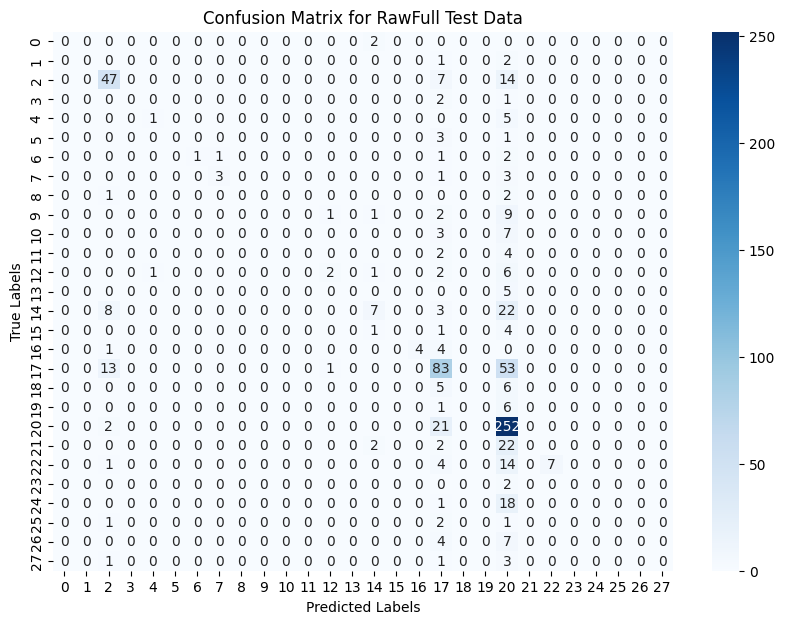

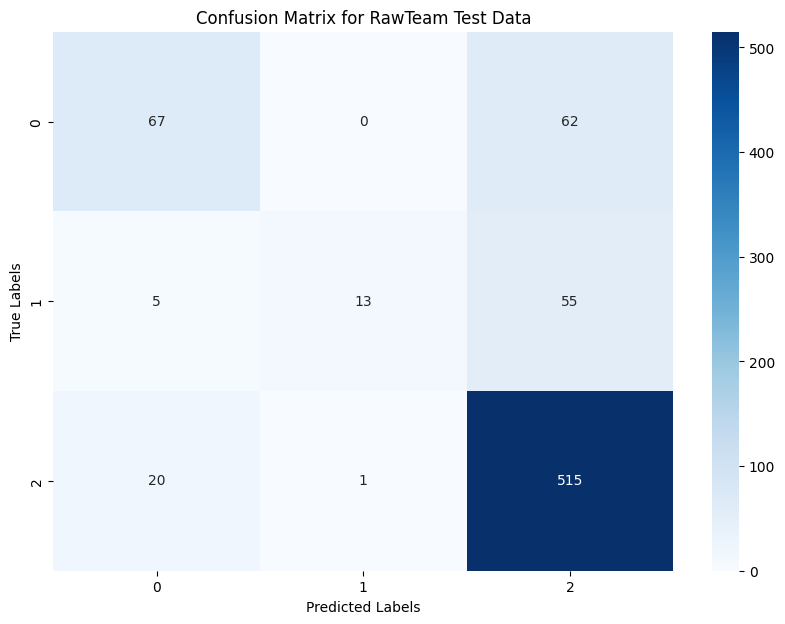

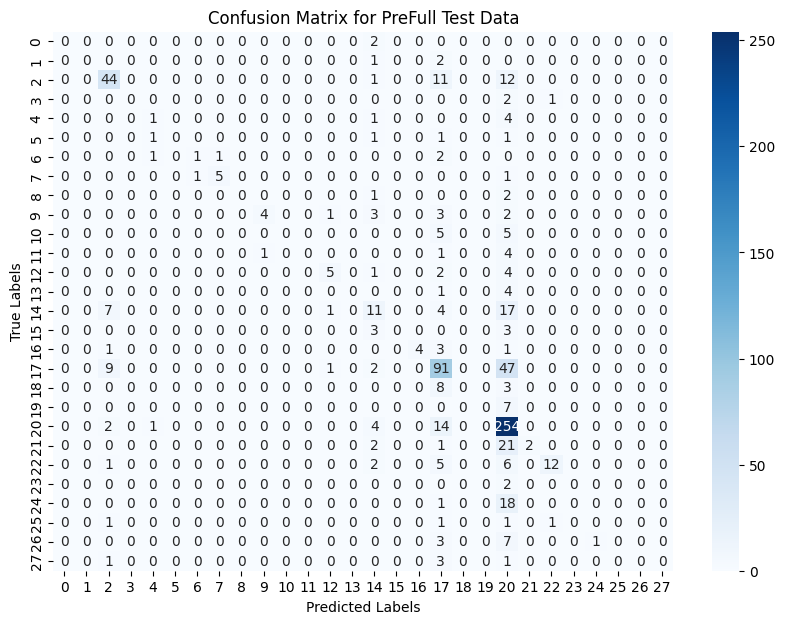

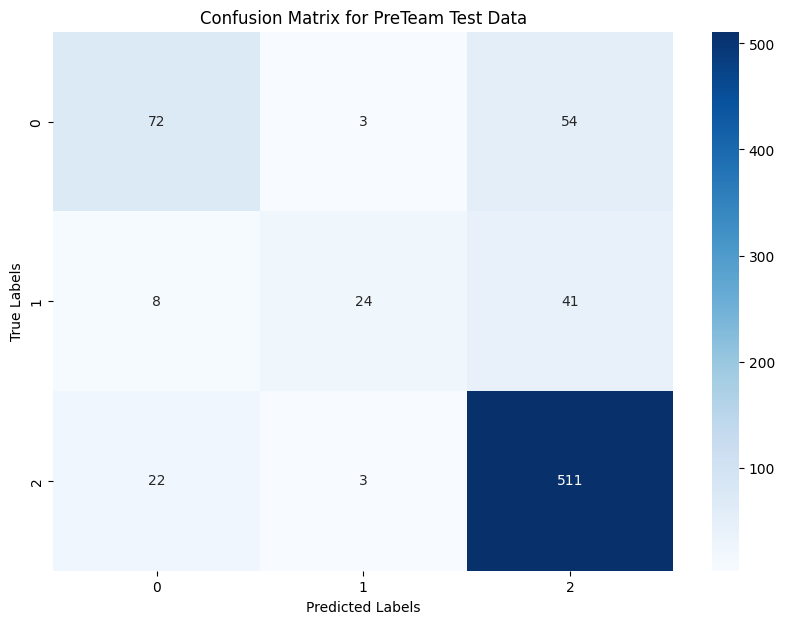

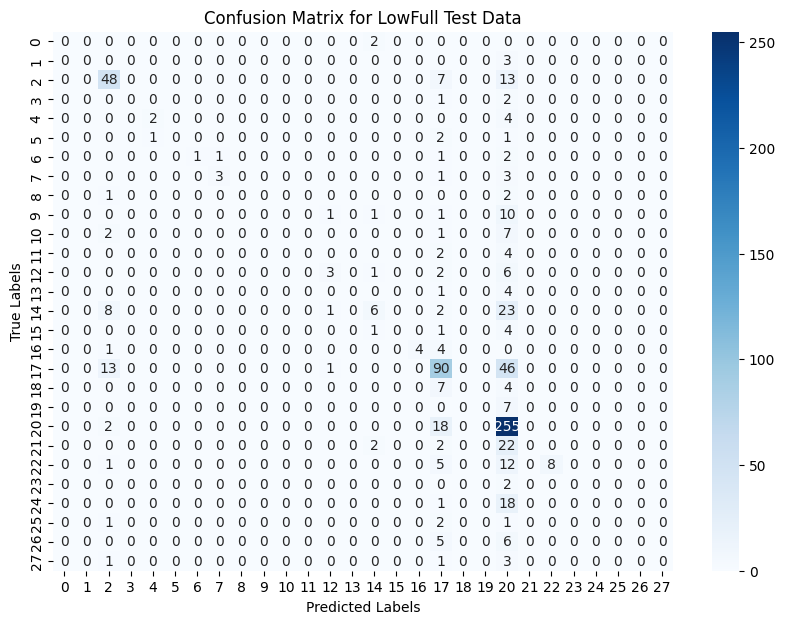

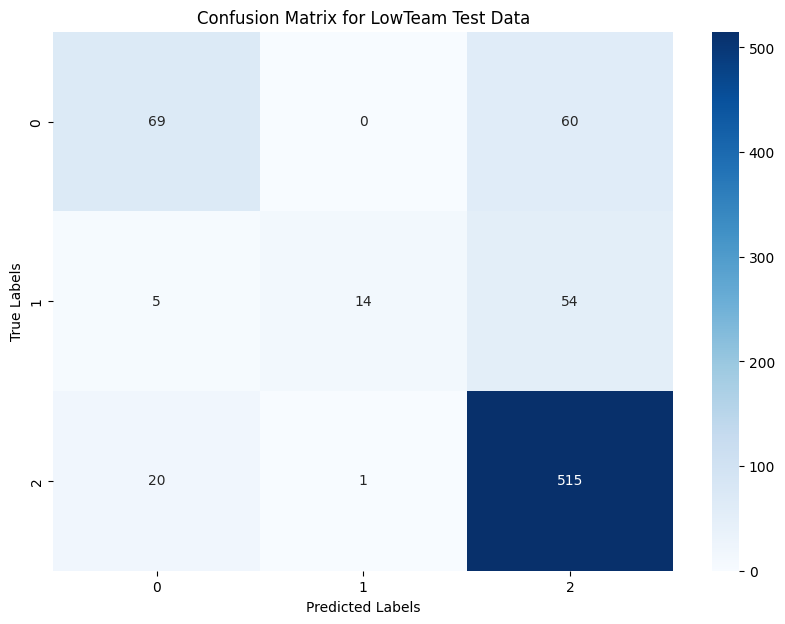

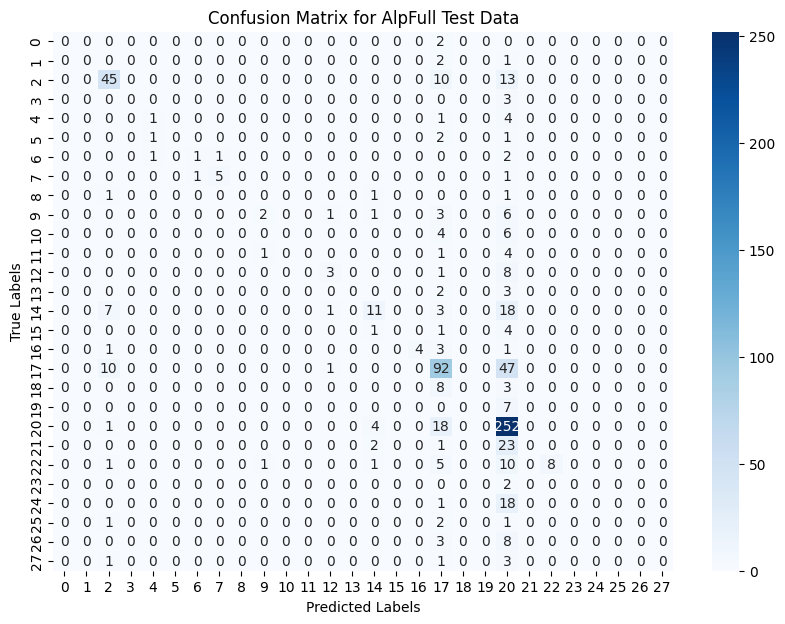

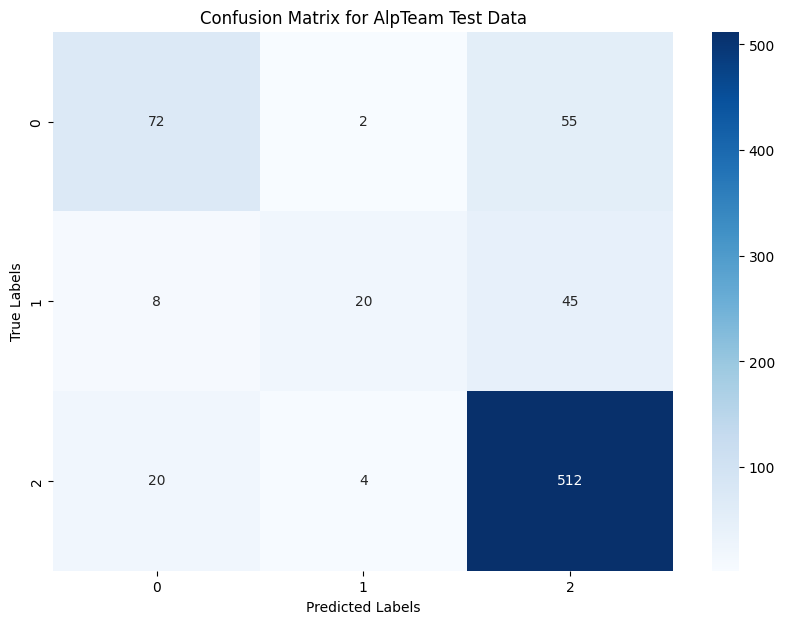

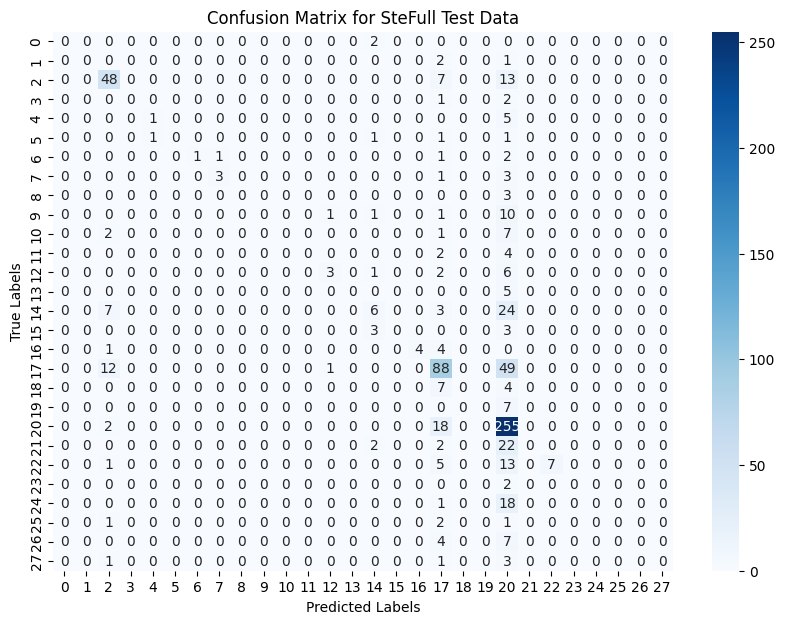

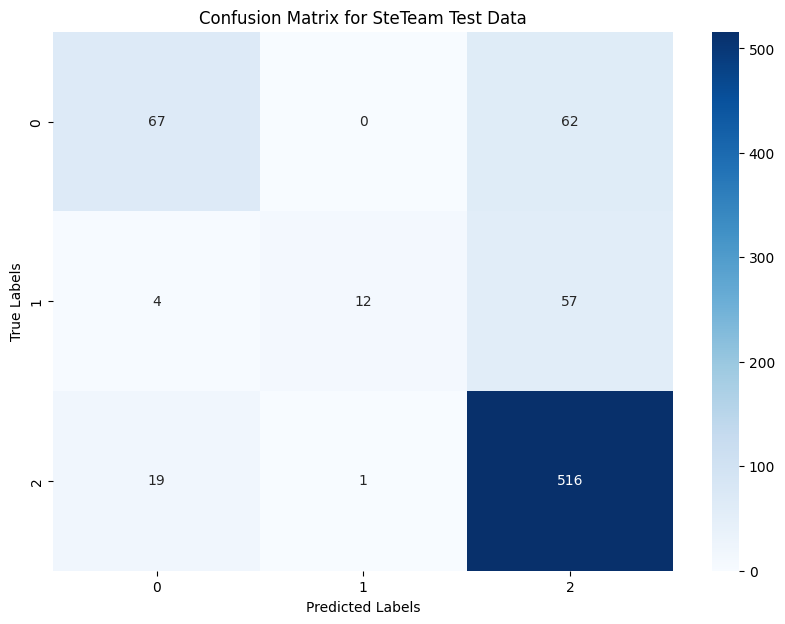

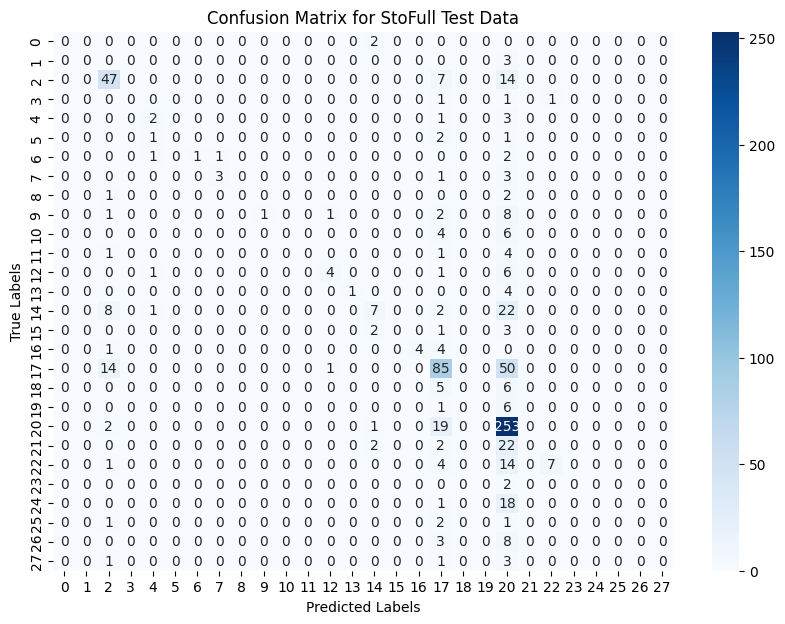

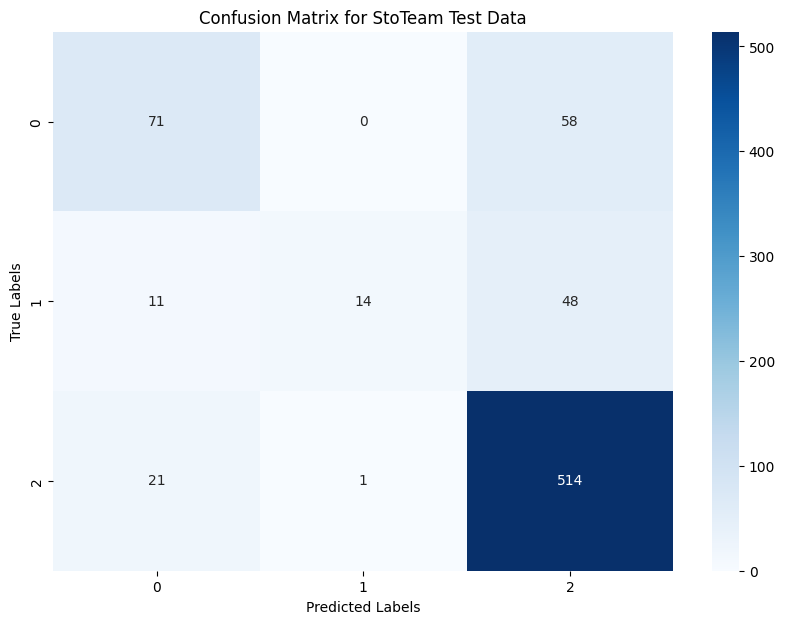

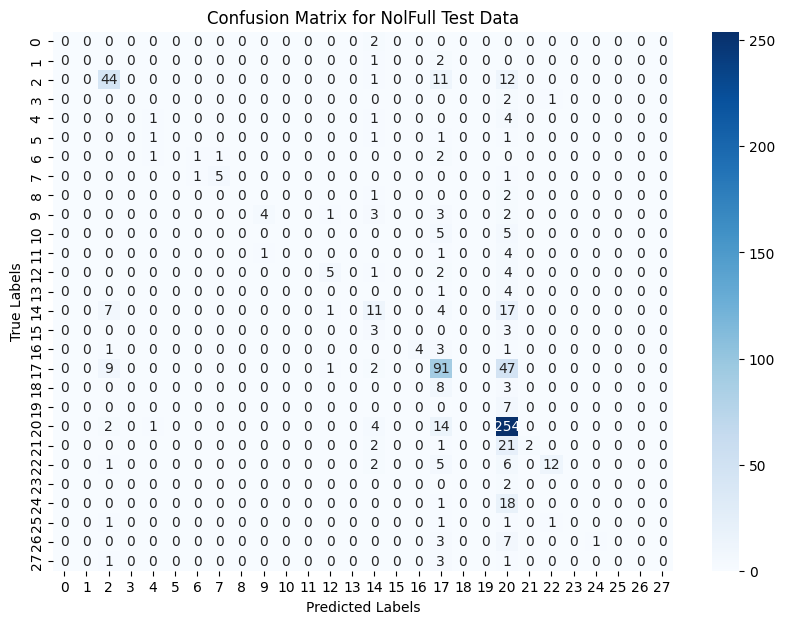

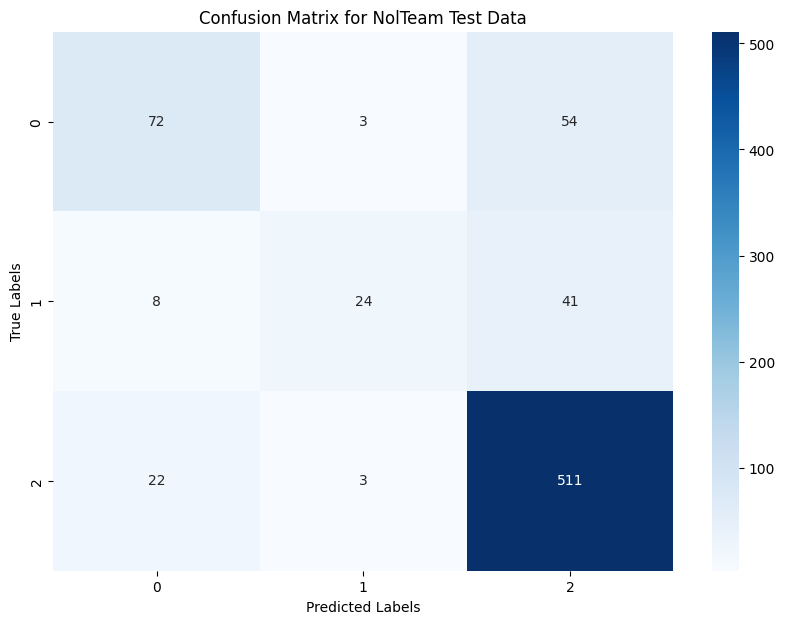

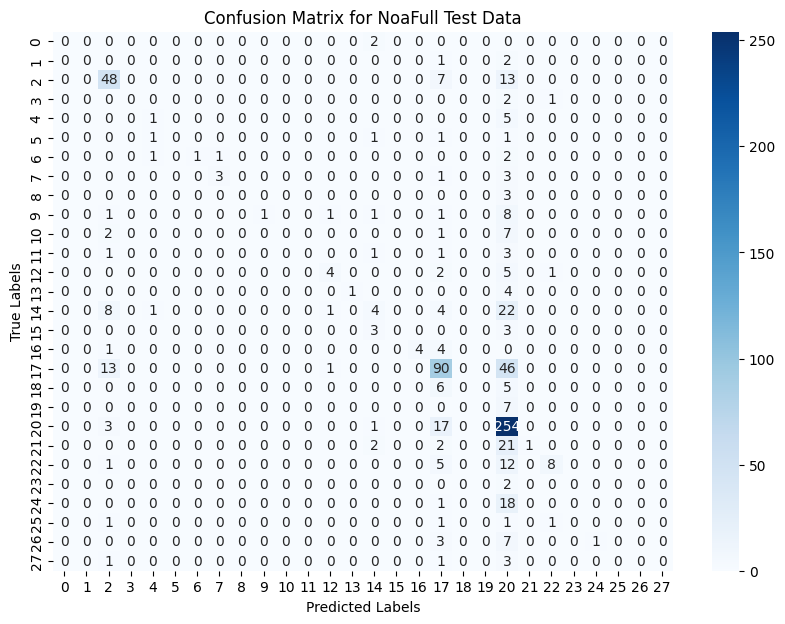

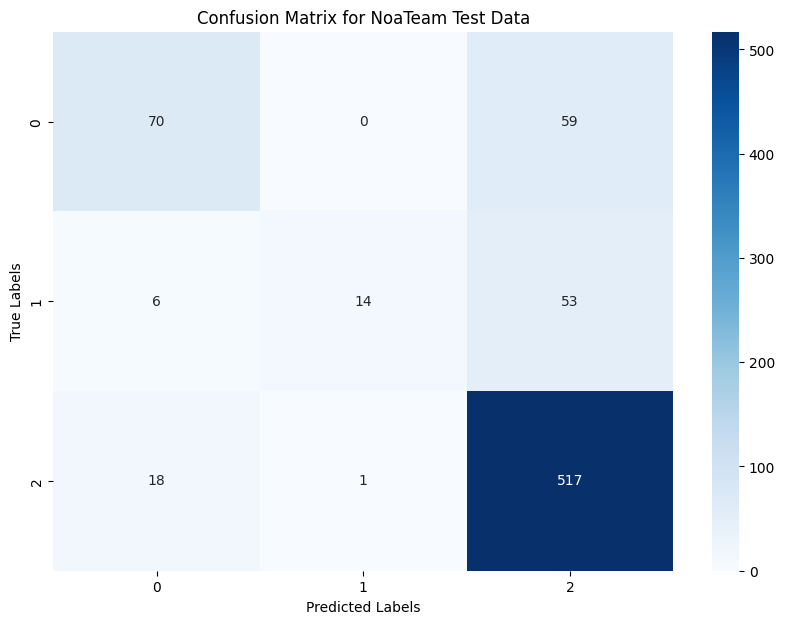

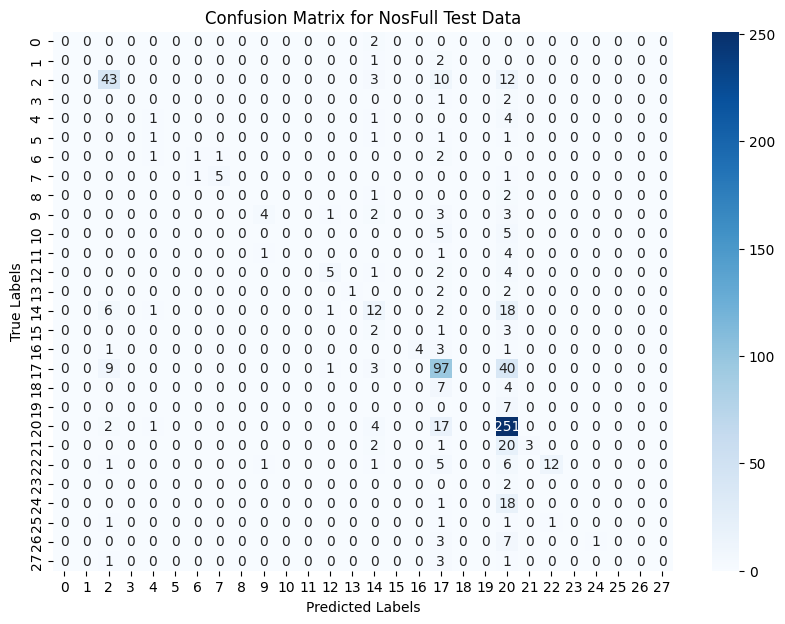

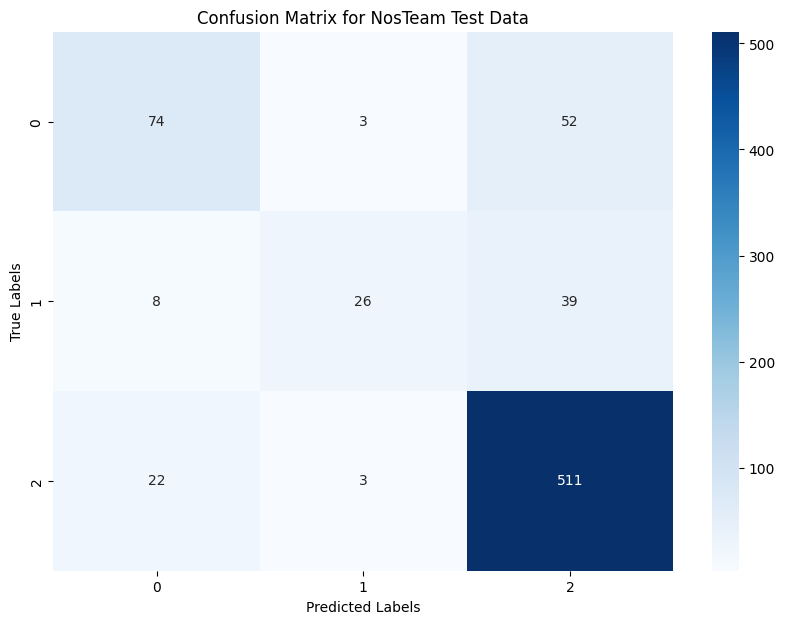

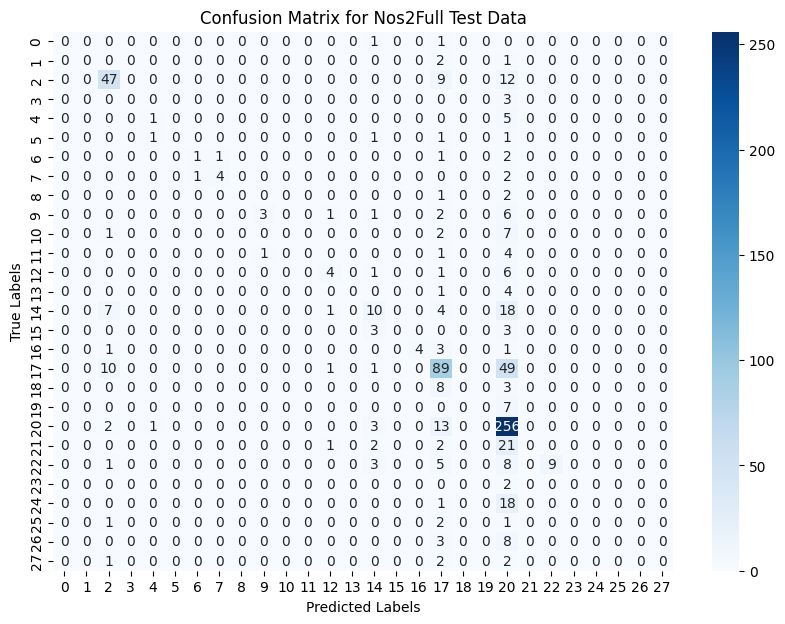

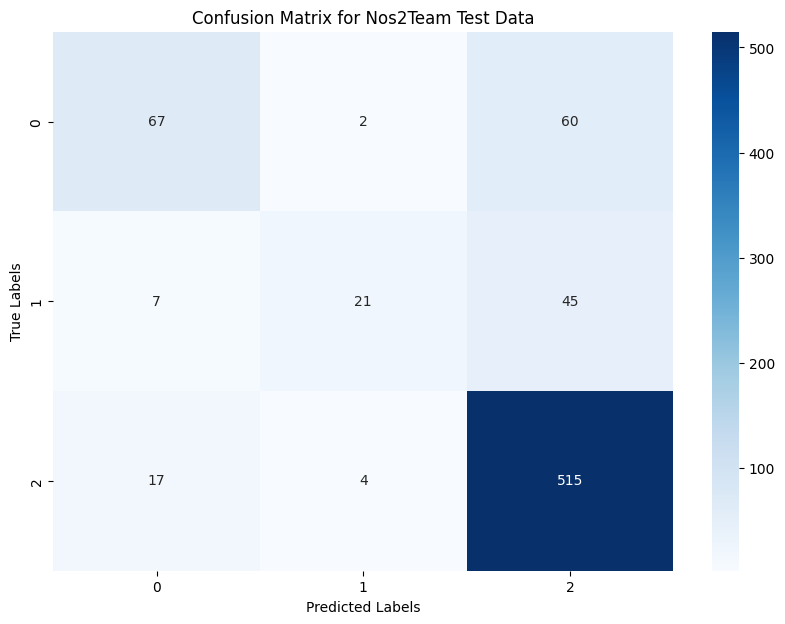

     Dataset  Validation Accuracy  Validation F1 Score  Test Accuracy  \
0    RawFull             0.569106             0.487944       0.551491   
1    RawTeam             0.819783             0.788595       0.806233   
2    PreFull             0.602981             0.539737       0.588076   
3    PreTeam             0.829268             0.812697       0.822493   
4    LowFull             0.570461             0.488073       0.569106   
5    LowTeam             0.821138             0.791216       0.810298   
6    AlpFull             0.582656             0.511566       0.574526   
7    AlpTeam             0.819783             0.793177       0.818428   
8    SteFull             0.573171             0.494434       0.563686   
9    SteTeam             0.822493             0.793516       0.806233   
10   StoFull             0.567751             0.491024       0.562331   
11   StoTeam             0.817073             0.789761       0.811653   
12   NolFull             0.602981             0.539

In [28]:
def train_and_evaluate_svm(prefix):
    # Retrieve the dataset using dynamic variable names
    train_data = globals()[f'{prefix}_train_data']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data']
    test_labels = globals()[f'{prefix}_test_labels']

    # Train the SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(train_data, train_labels)

    # Evaluate on the validation set
    val_predictions = svm_model.predict(val_data)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions, average='weighted')

    # Evaluate on the test set
    test_predictions = svm_model.predict(test_data)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Compute the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Validation F1 Score': [val_f1],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df   

# Dataset prefixes from the 'datasets' dictionary
prefixes = [prefix for _, _, prefix in datasets.values()]

# Combine results from all datasets
combined_results = pd.DataFrame()

for prefix in prefixes:
    results = train_and_evaluate_svm(prefix)
    combined_results = pd.concat([combined_results, results], ignore_index=True)

# Display the combined results
print(combined_results)

## 6.2 XGBoost

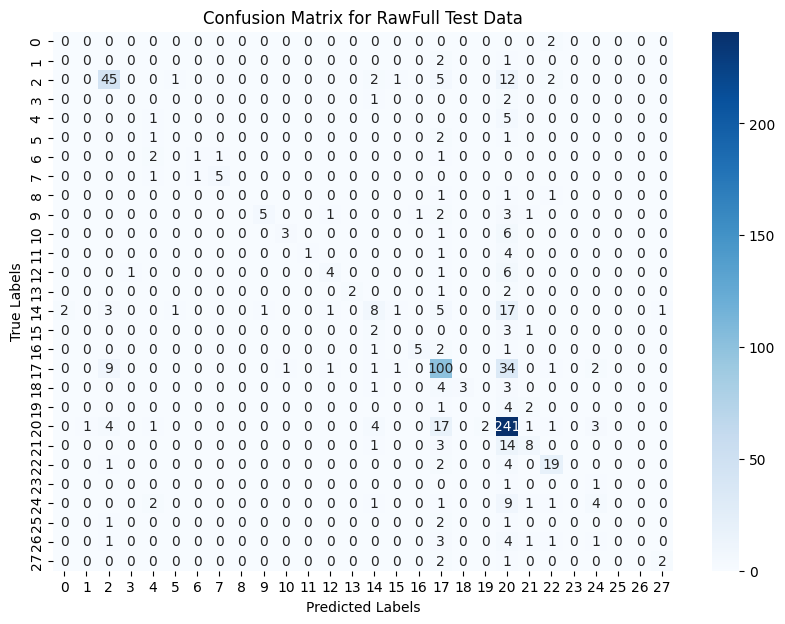

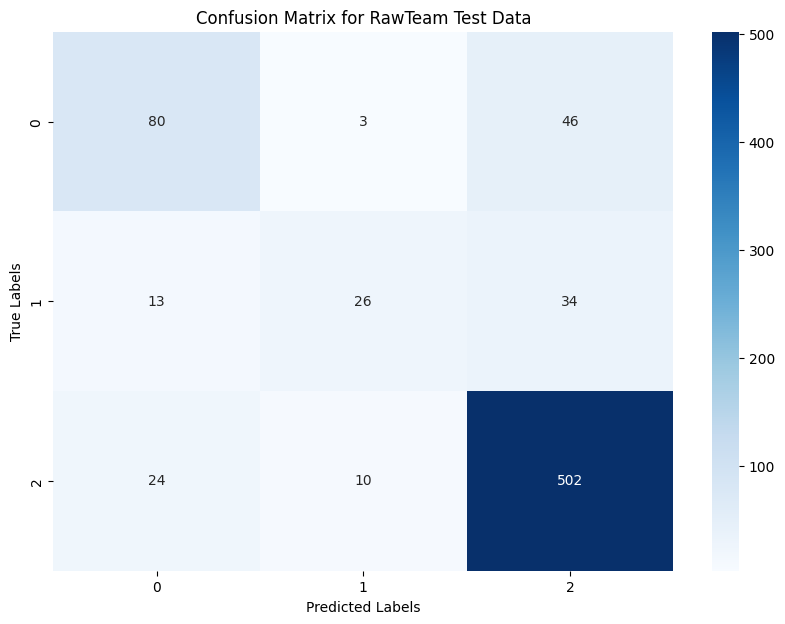

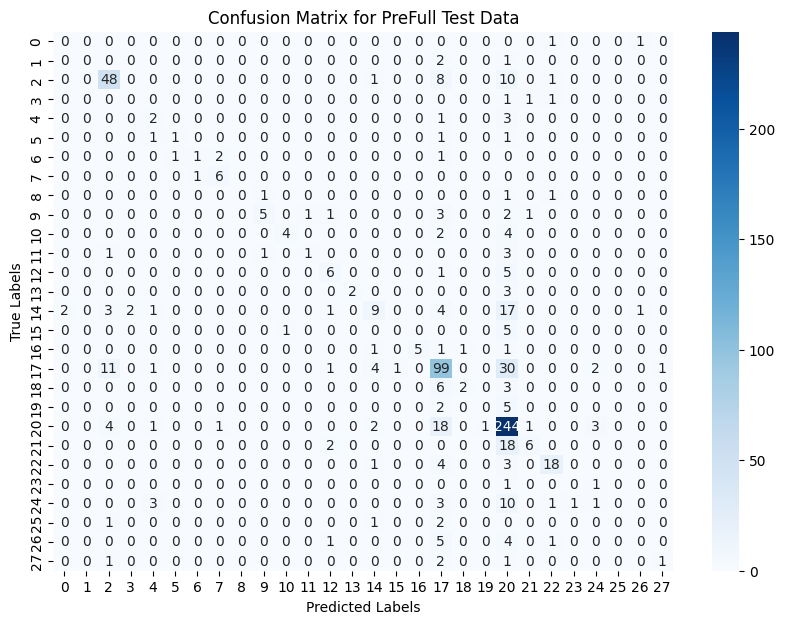

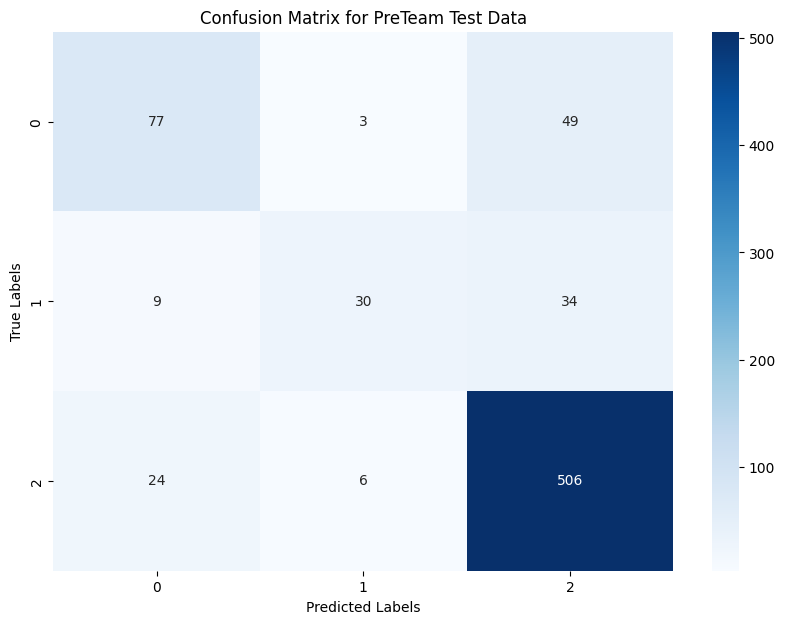

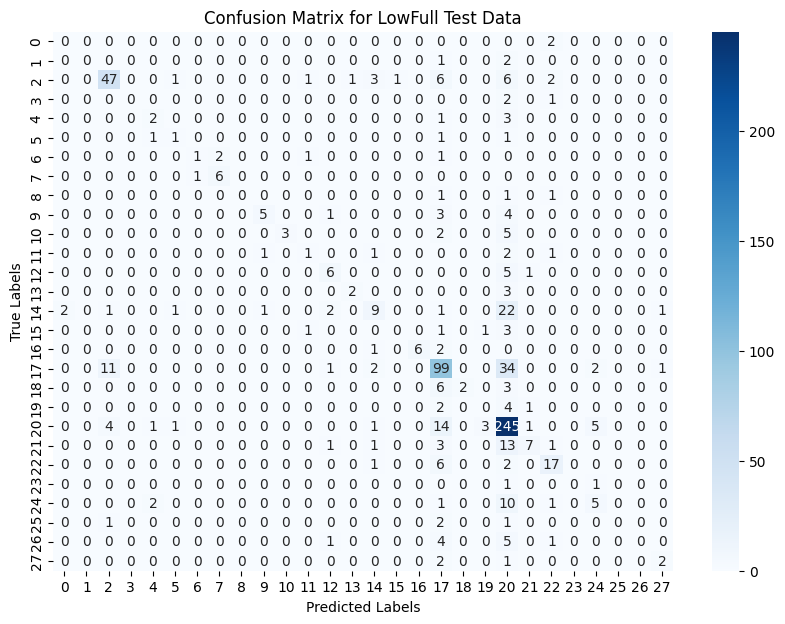

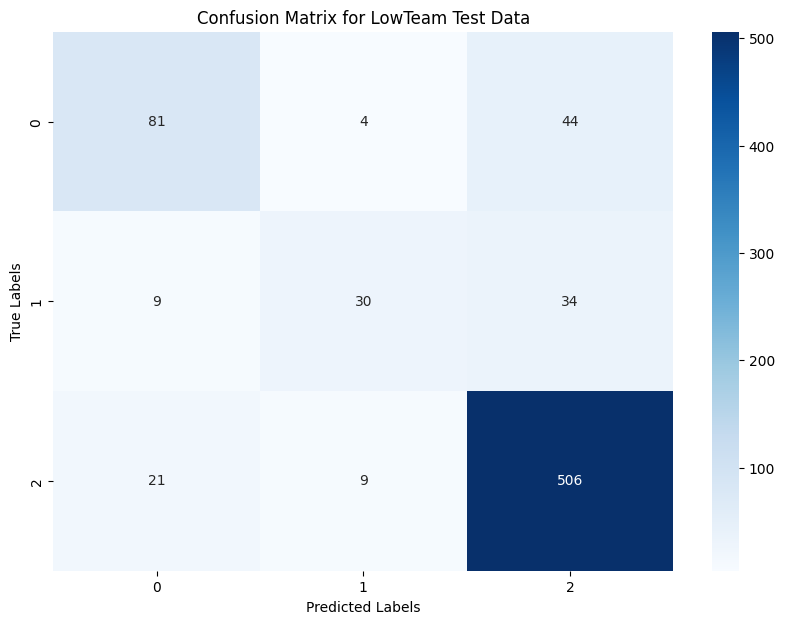

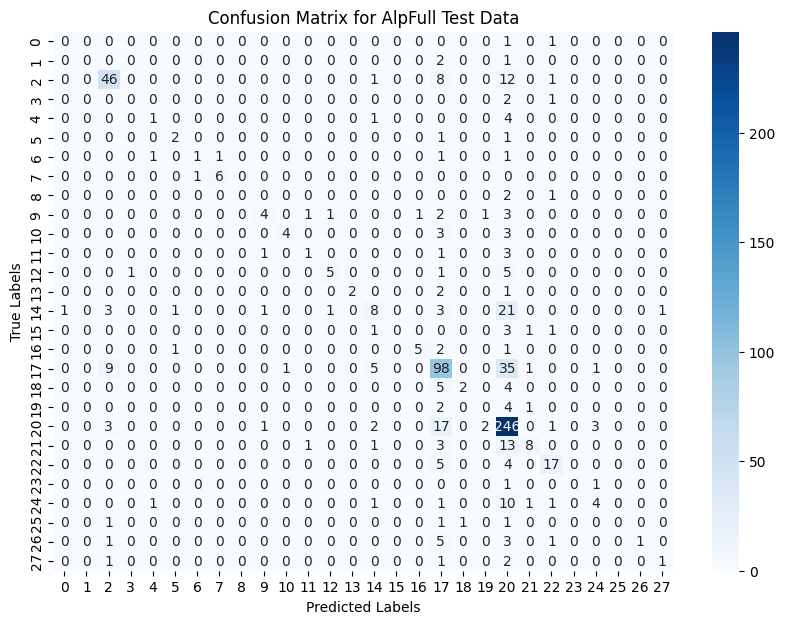

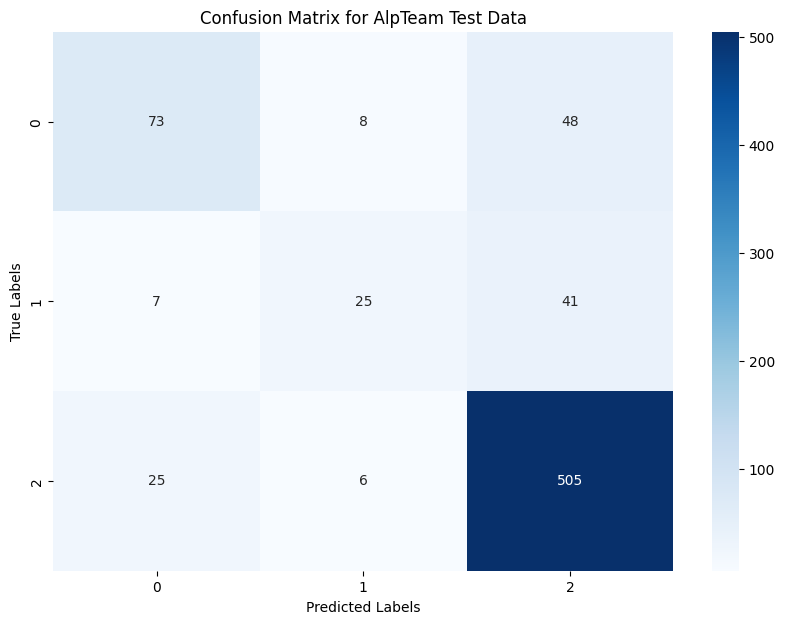

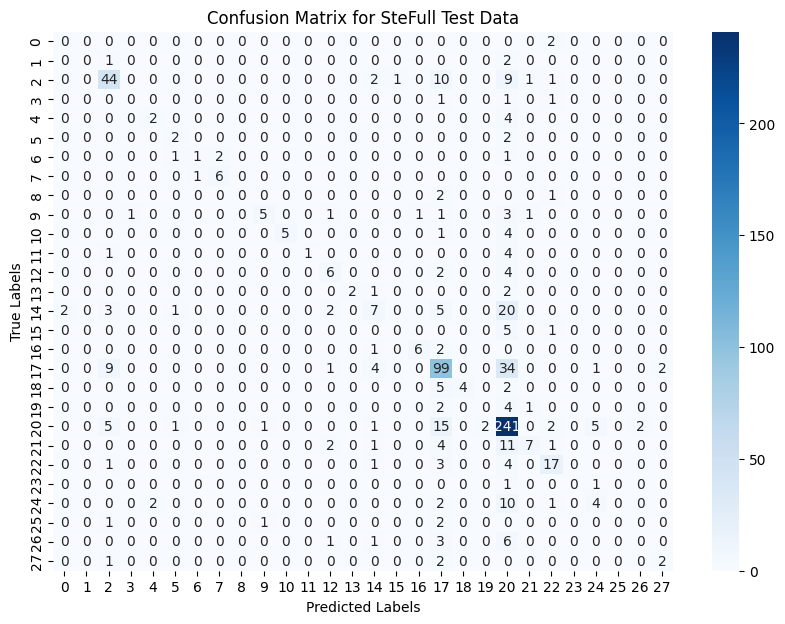

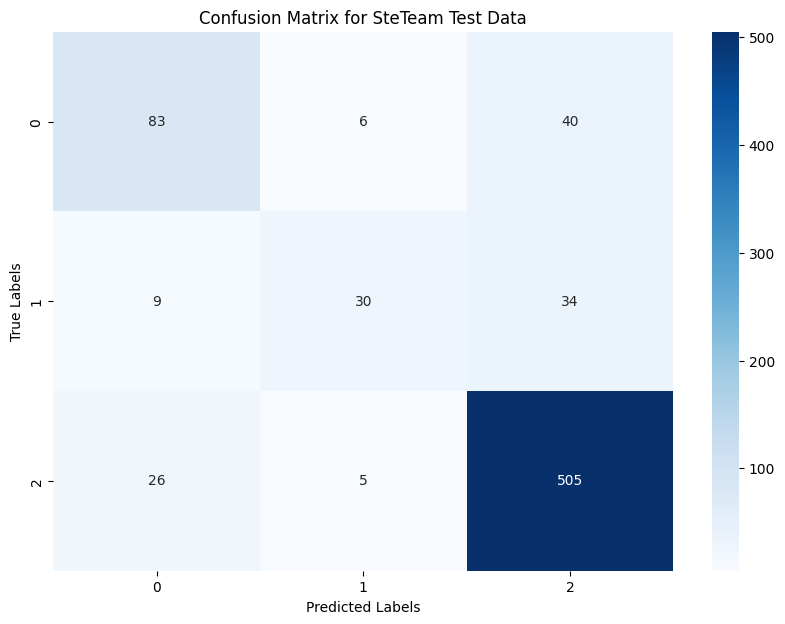

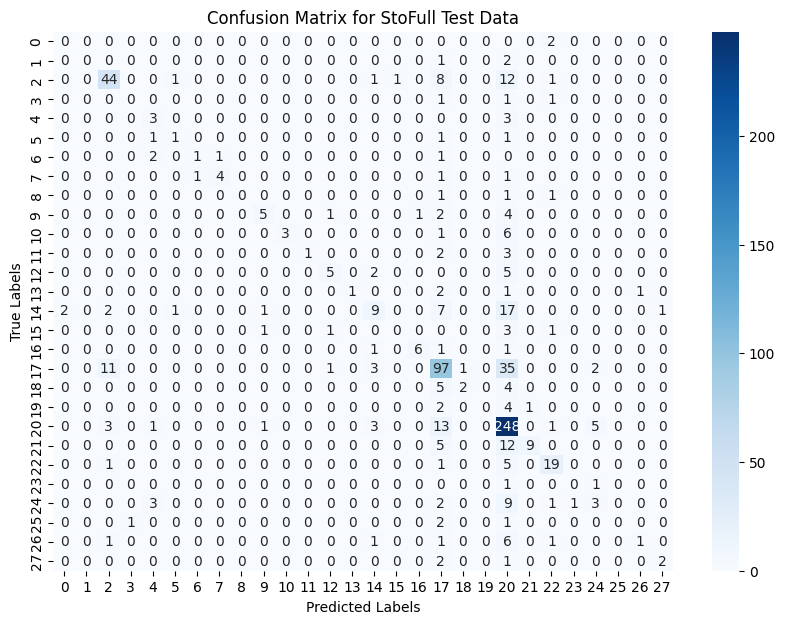

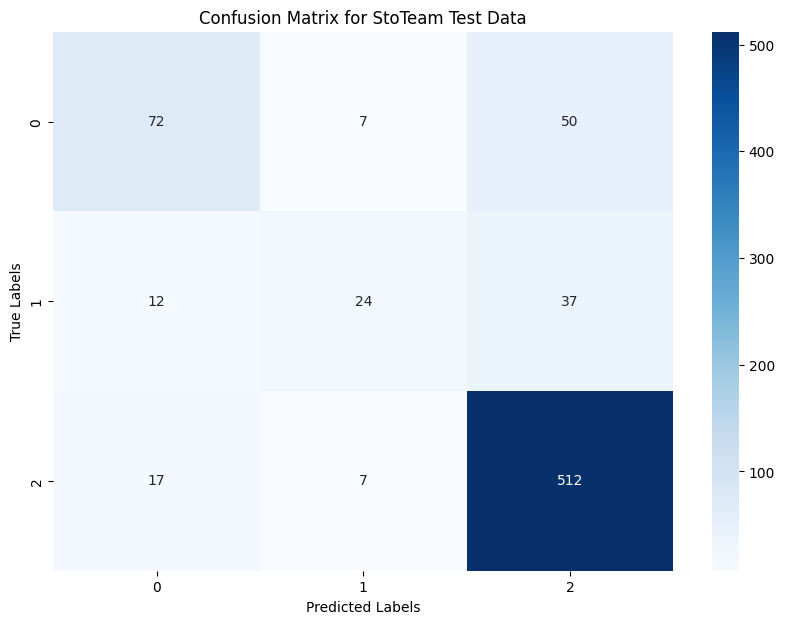

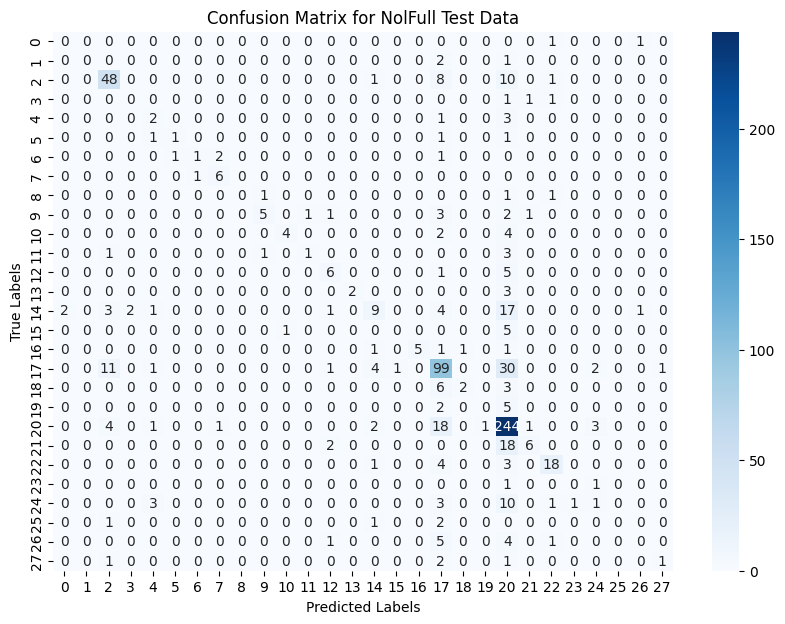

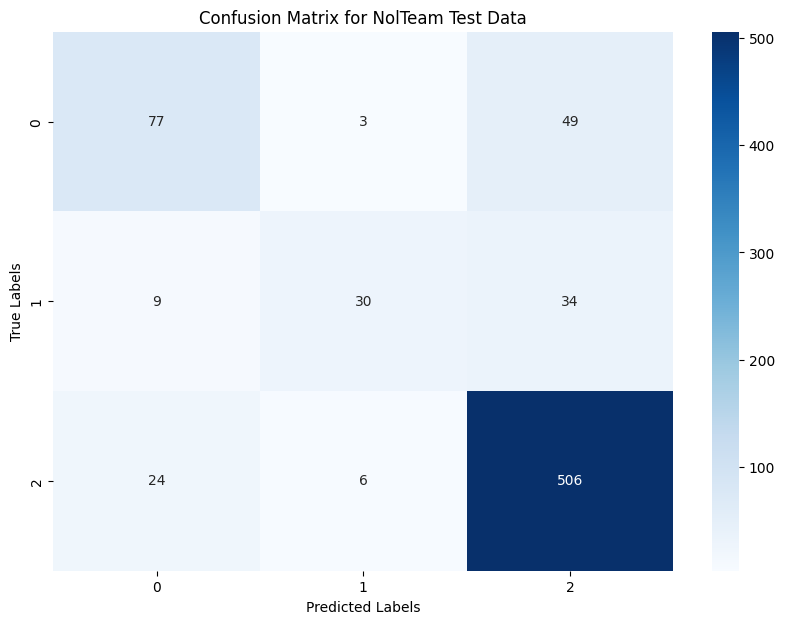

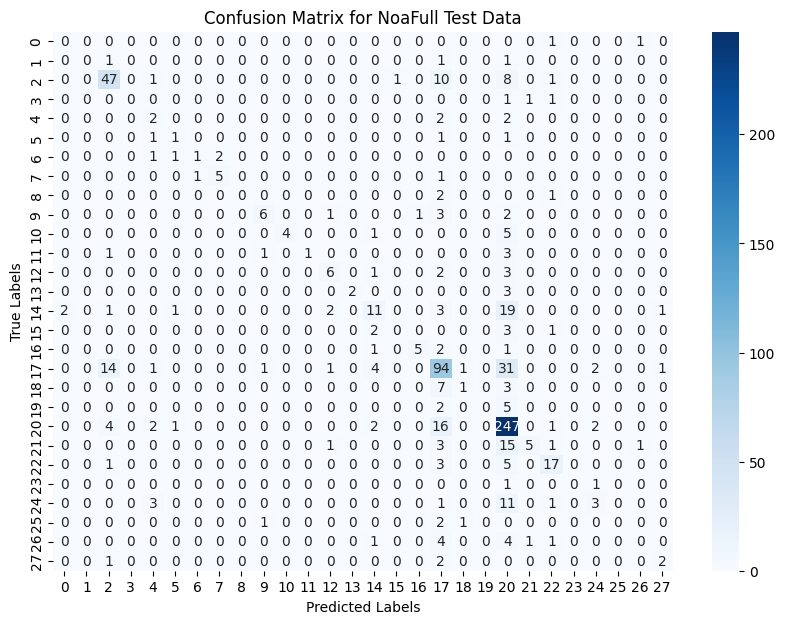

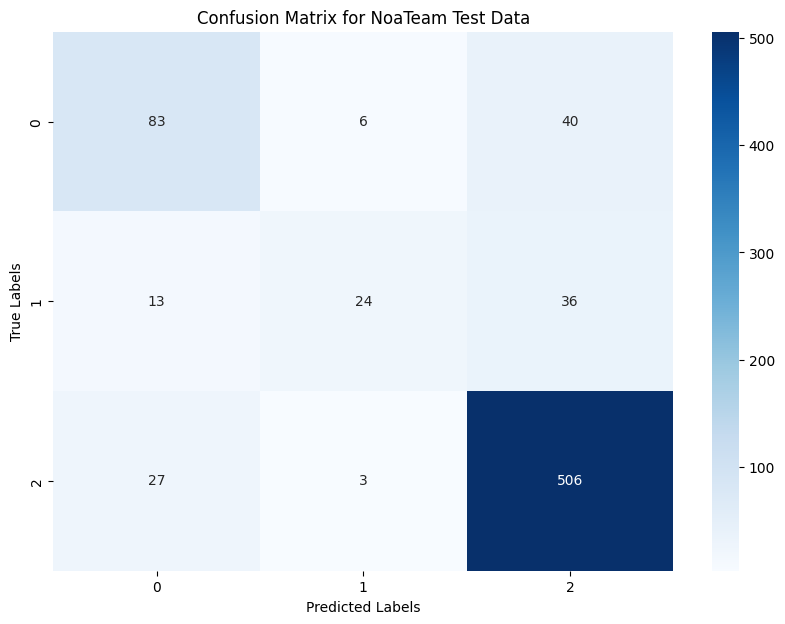

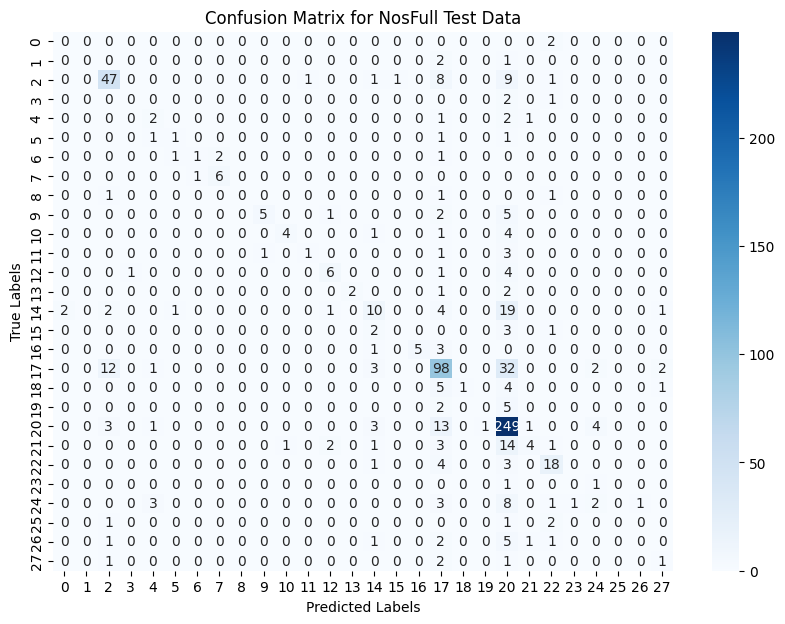

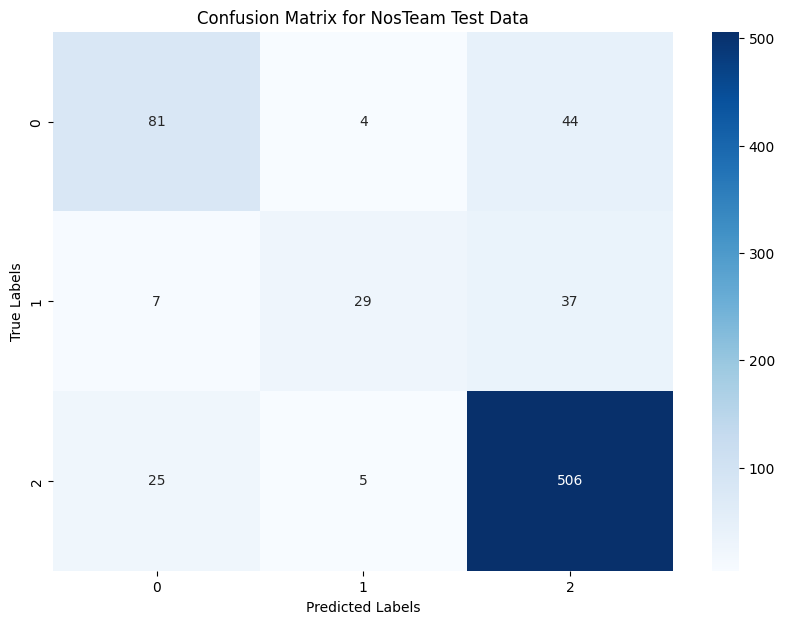

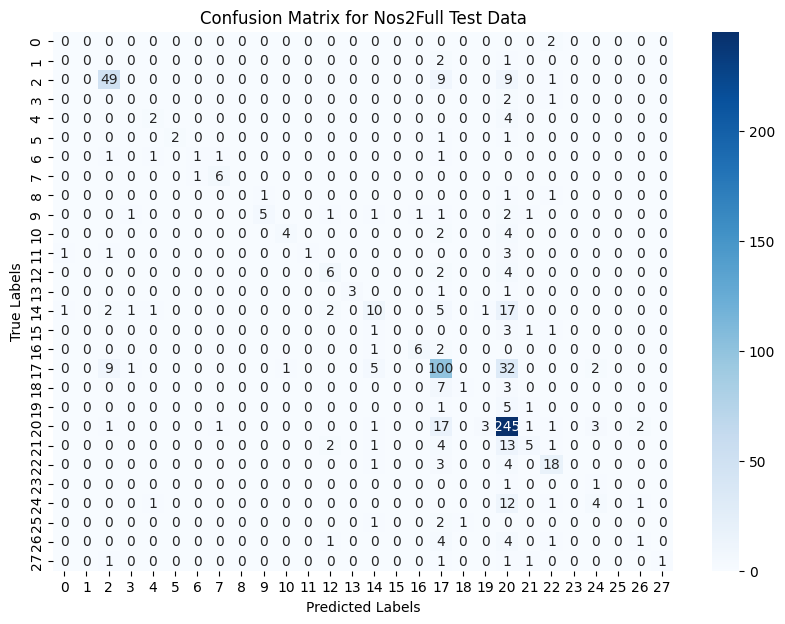

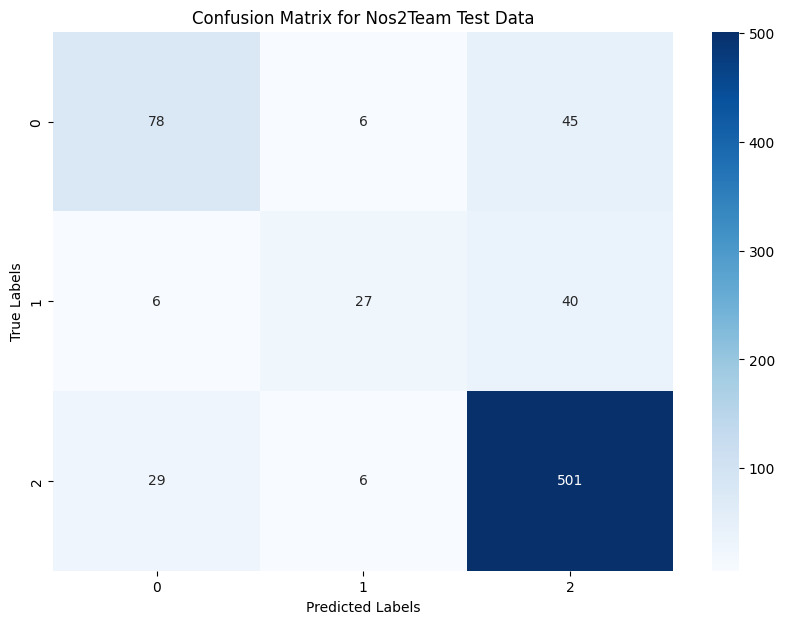

     Dataset  Validation Accuracy  Test Accuracy  Test F1 Score
0    RawFull             0.593496       0.619241       0.584398
1    RawTeam             0.829268       0.823848       0.811844
2    PreFull             0.609756       0.624661       0.585612
3    PreTeam             0.841463       0.830623       0.818957
4    LowFull             0.611111       0.631436       0.595499
5    LowTeam             0.846883       0.836043       0.825404
6    AlpFull             0.604336       0.626016       0.588059
7    AlpTeam             0.837398       0.817073       0.802380
8    SteFull             0.605691       0.624661       0.589816
9    SteTeam             0.848238       0.837398       0.827428
10   StoFull             0.601626       0.628726       0.592282
11   StoTeam             0.840108       0.823848       0.807471
12   NolFull             0.609756       0.624661       0.585612
13   NolTeam             0.841463       0.830623       0.818957
14   NoaFull             0.600271       

In [30]:
def train_and_evaluate_xgboost(prefix):
    # Retrieve the dataset using dynamic variable names
    train_data = globals()[f'{prefix}_train_data']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data']
    test_labels = globals()[f'{prefix}_test_labels']

    # Encoding labels
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    val_labels_encoded = label_encoder.transform(val_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Train the XGBoost model
    xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(train_data, train_labels_encoded)

    # Evaluate on the validation set
    val_predictions = xgb_model.predict(val_data)
    val_accuracy = accuracy_score(val_labels_encoded, val_predictions)
    val_f1 = f1_score(val_labels_encoded, val_predictions, average='weighted')

    # Evaluate on the test set
    test_predictions = xgb_model.predict(test_data)
    test_accuracy = accuracy_score(test_labels_encoded, test_predictions)
    test_f1 = f1_score(test_labels_encoded, test_predictions, average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels_encoded, test_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df   

# Dataset prefixes from the 'datasets' dictionary
prefixes = [prefix for _, _, prefix in datasets.values()]

# Combine results from all datasets
combined_results = pd.DataFrame()

for prefix in prefixes:
    results = train_and_evaluate_xgboost(prefix)
    combined_results = pd.concat([combined_results, results], ignore_index=True)

# Display the combined results
print(combined_results)

## 6.3 CNN

24/24 [==============================] - 0s 7ms/step


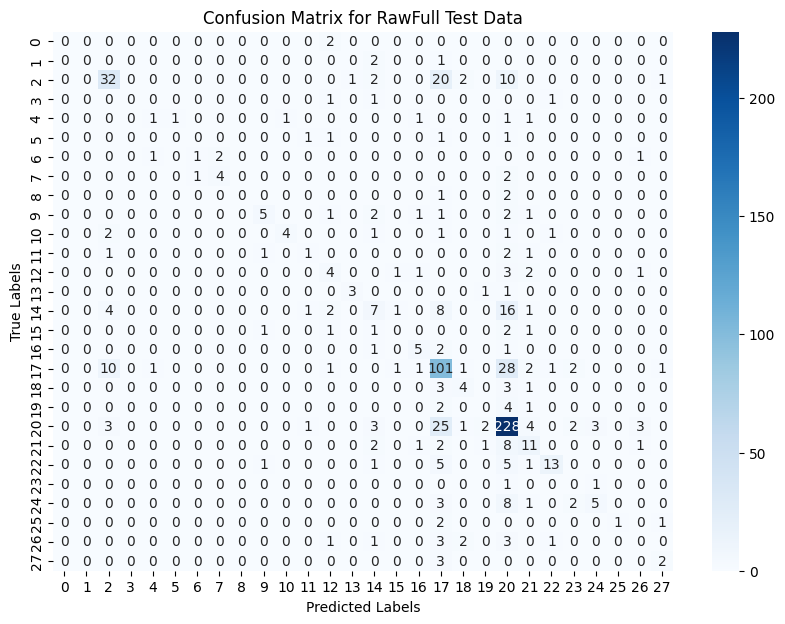

24/24 [==============================] - 0s 6ms/step


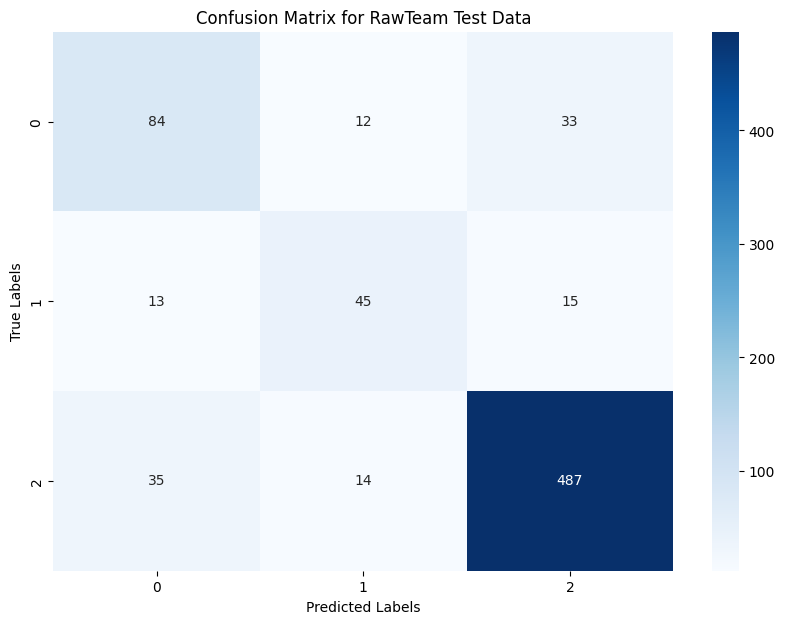

24/24 [==============================] - 0s 4ms/step


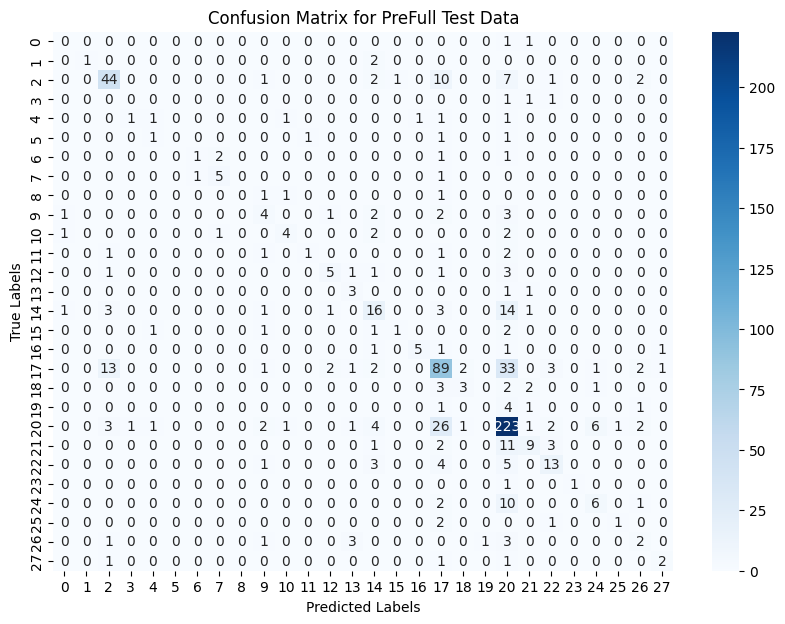

24/24 [==============================] - 0s 4ms/step


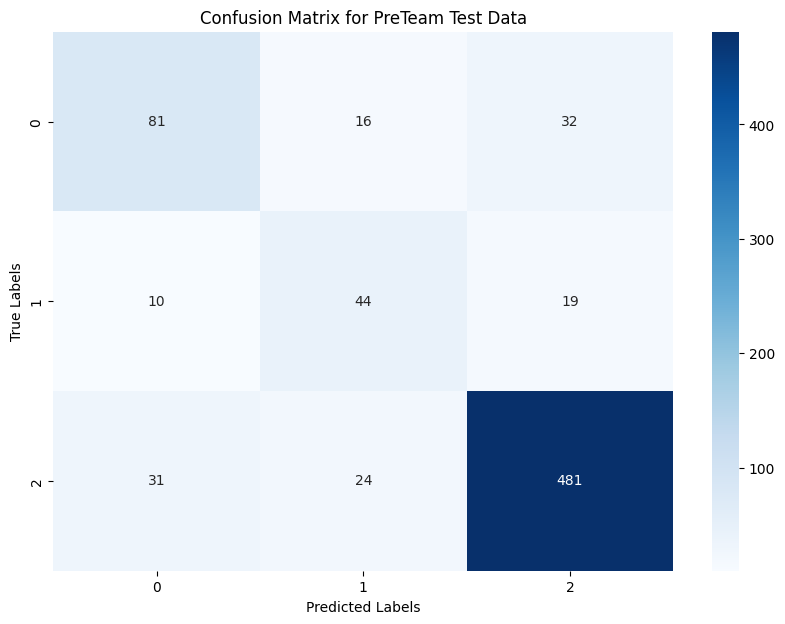

24/24 [==============================] - 0s 6ms/step


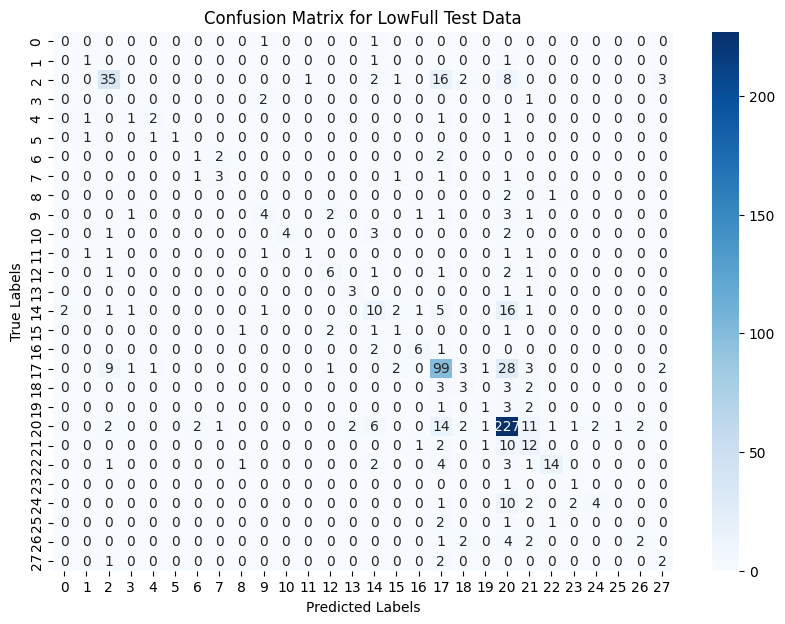

24/24 [==============================] - 0s 6ms/step


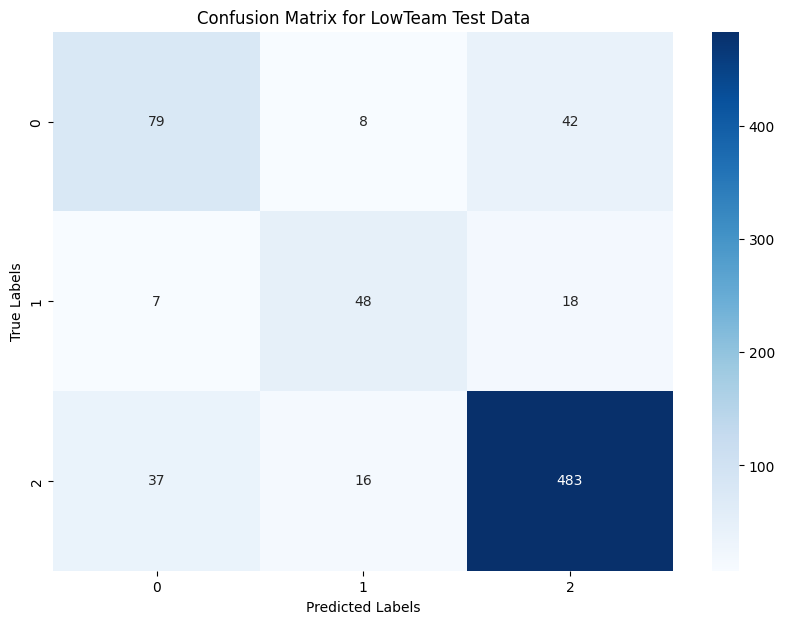

24/24 [==============================] - 0s 5ms/step


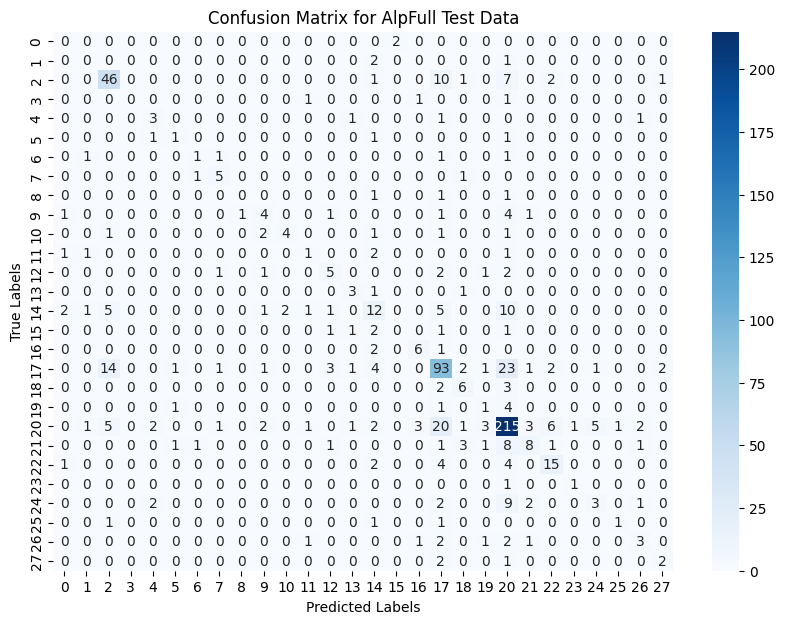

24/24 [==============================] - 0s 5ms/step


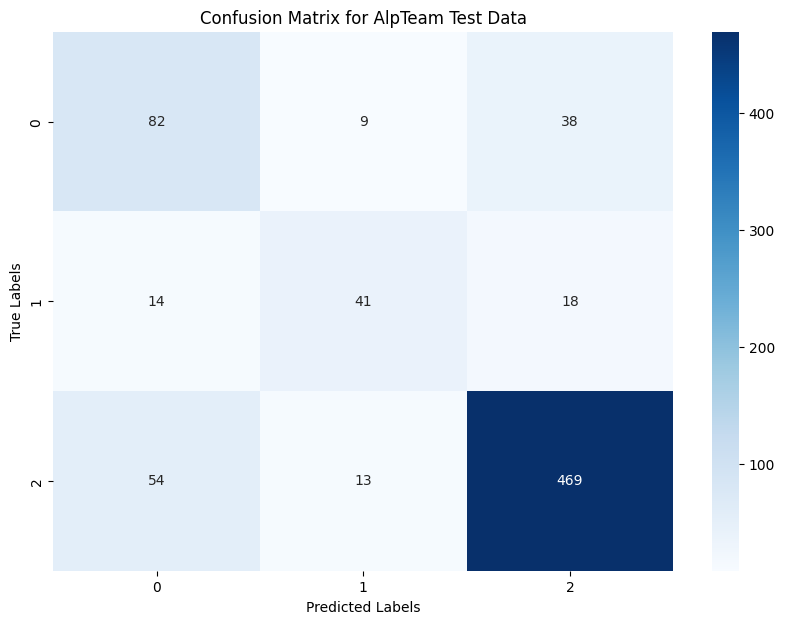

24/24 [==============================] - 0s 5ms/step


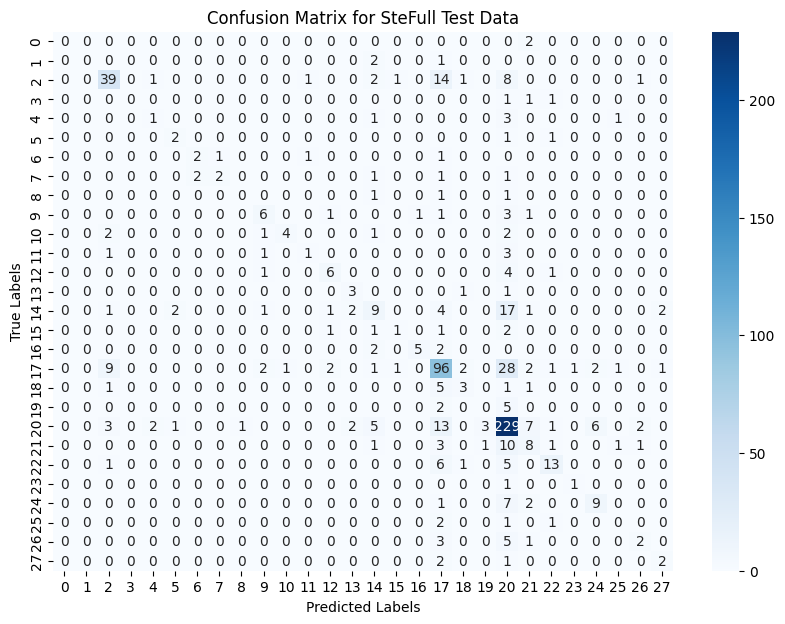

24/24 [==============================] - 0s 5ms/step


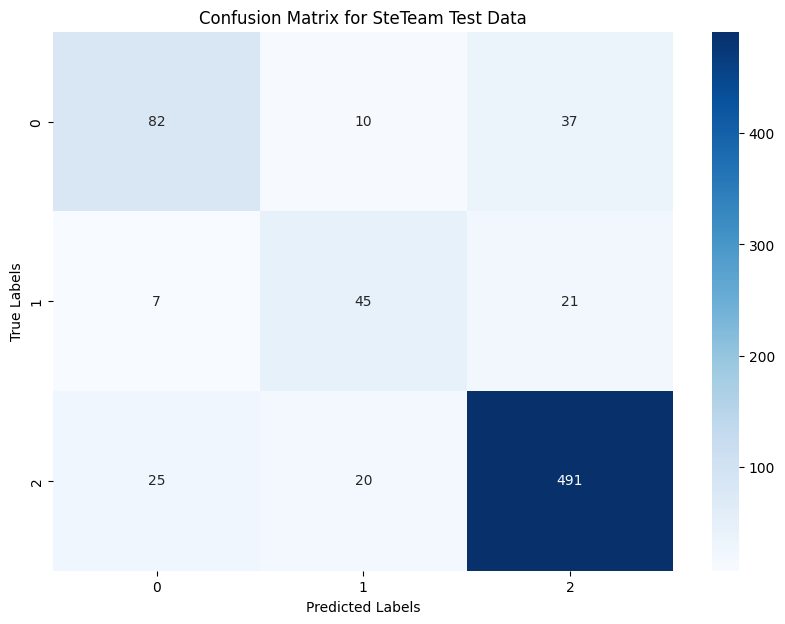

24/24 [==============================] - 0s 6ms/step


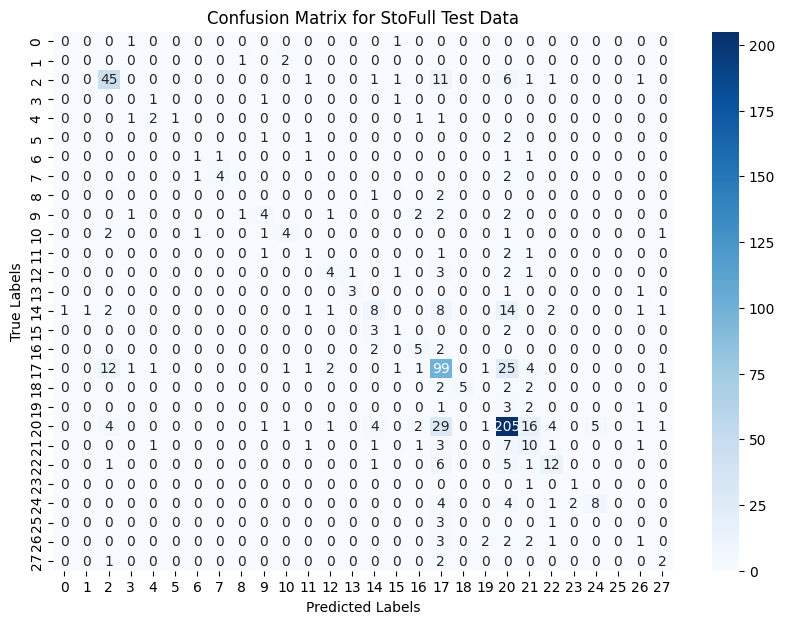

24/24 [==============================] - 0s 6ms/step


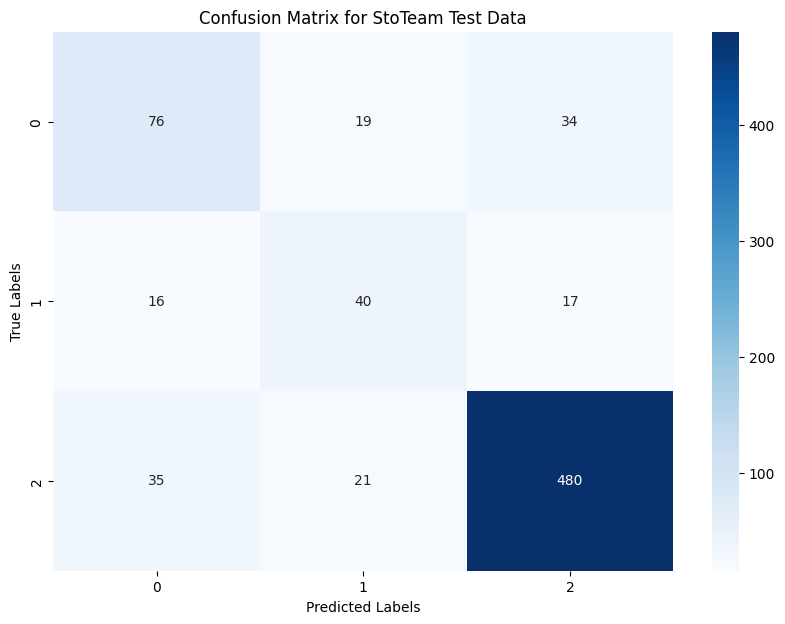

24/24 [==============================] - 0s 4ms/step


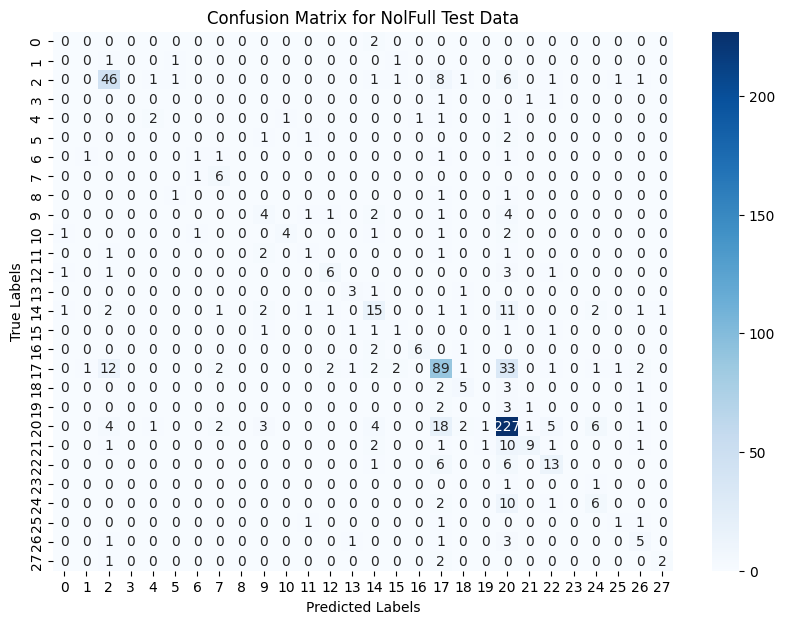

24/24 [==============================] - 0s 4ms/step


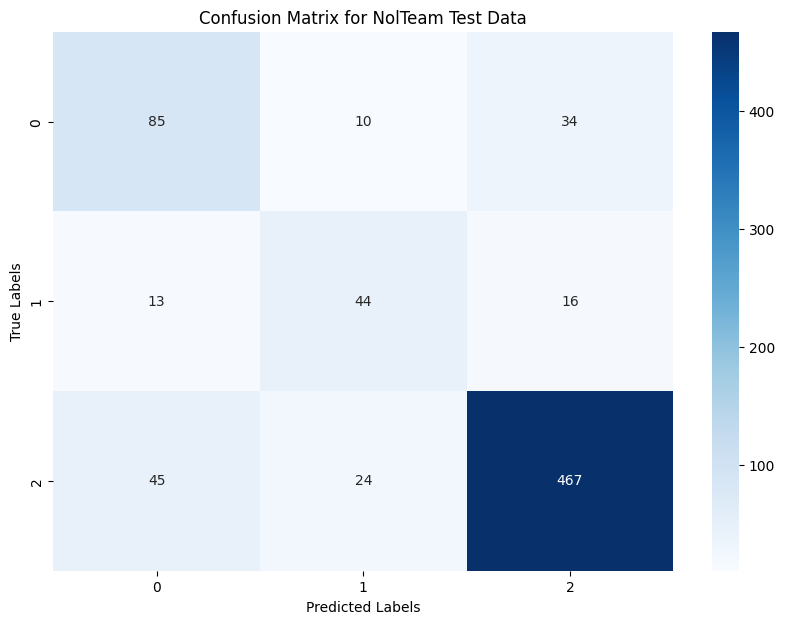

24/24 [==============================] - 0s 5ms/step


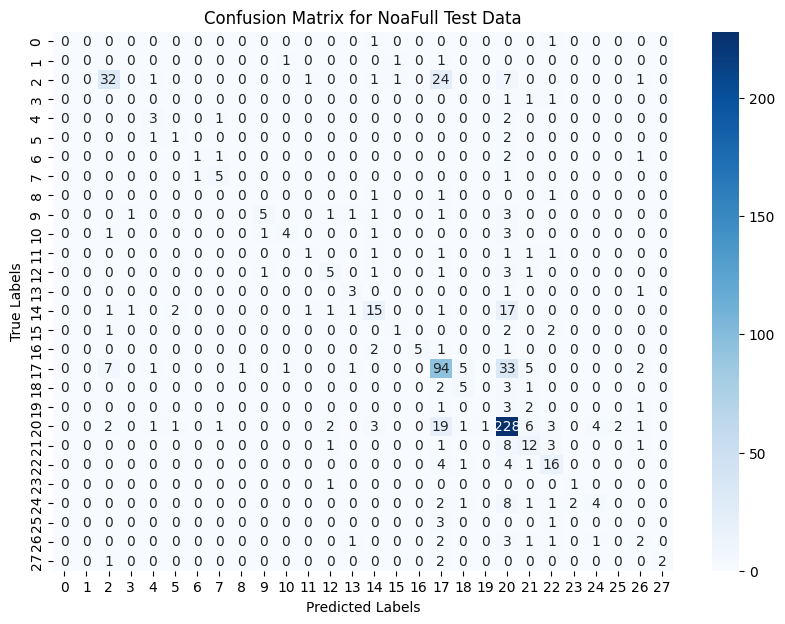

24/24 [==============================] - 0s 5ms/step


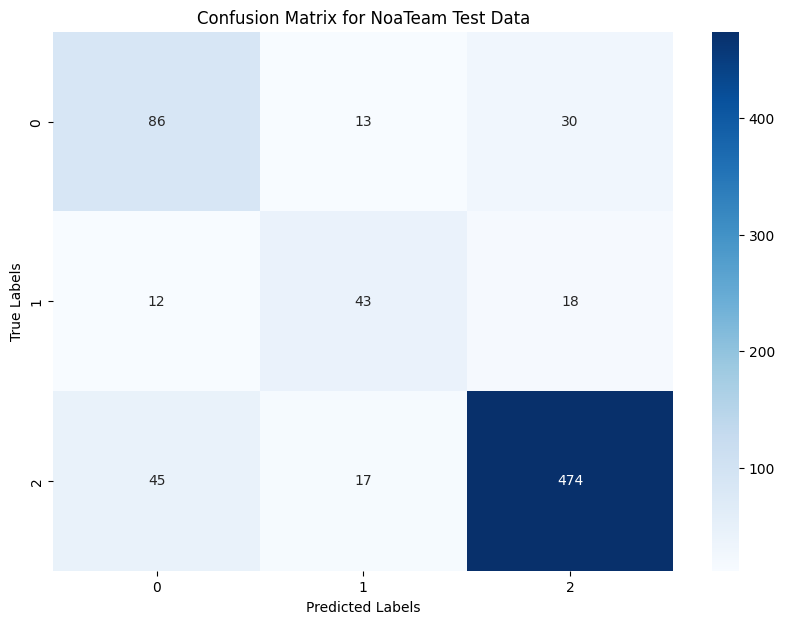

24/24 [==============================] - 0s 5ms/step


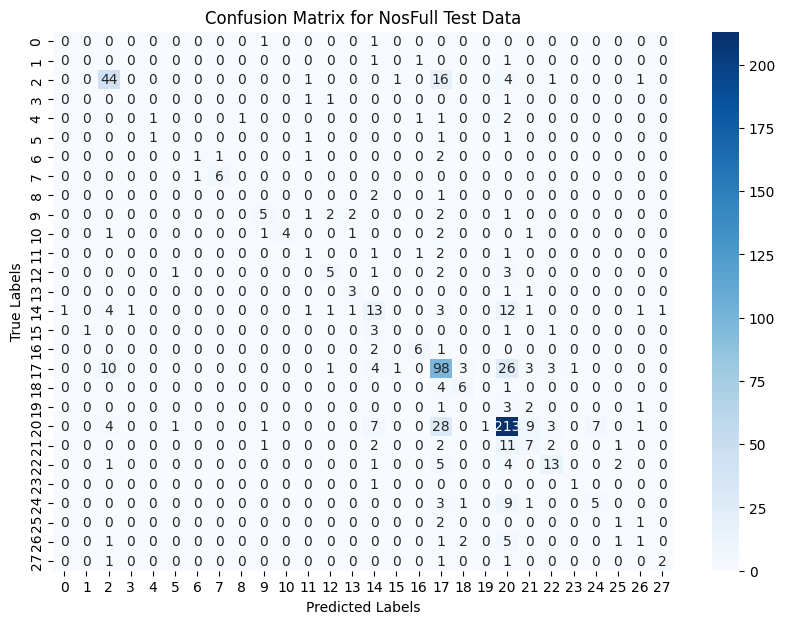

24/24 [==============================] - 0s 5ms/step


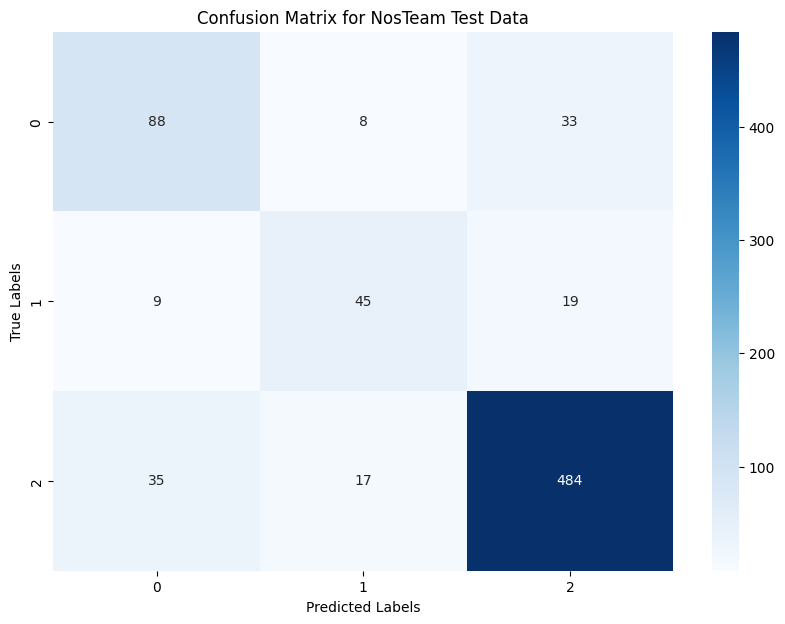

24/24 [==============================] - 0s 5ms/step


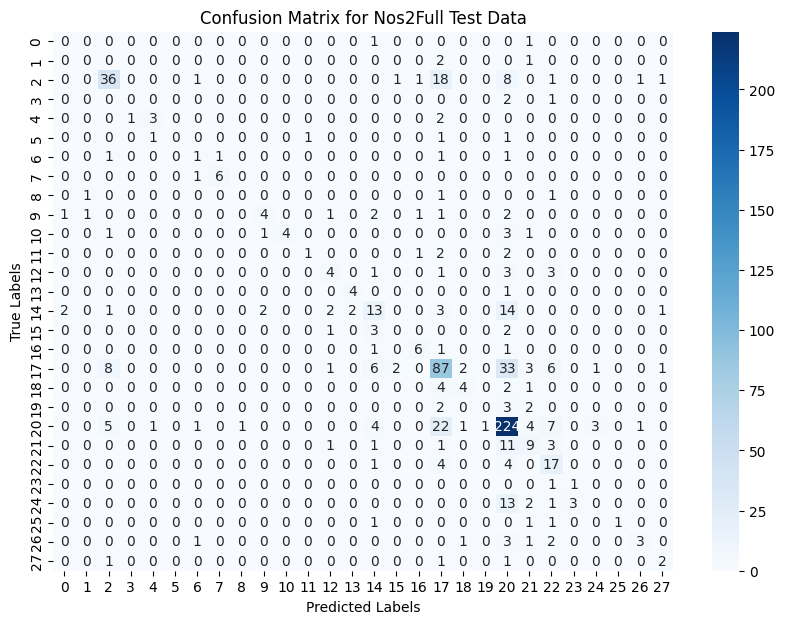

24/24 [==============================] - 0s 5ms/step


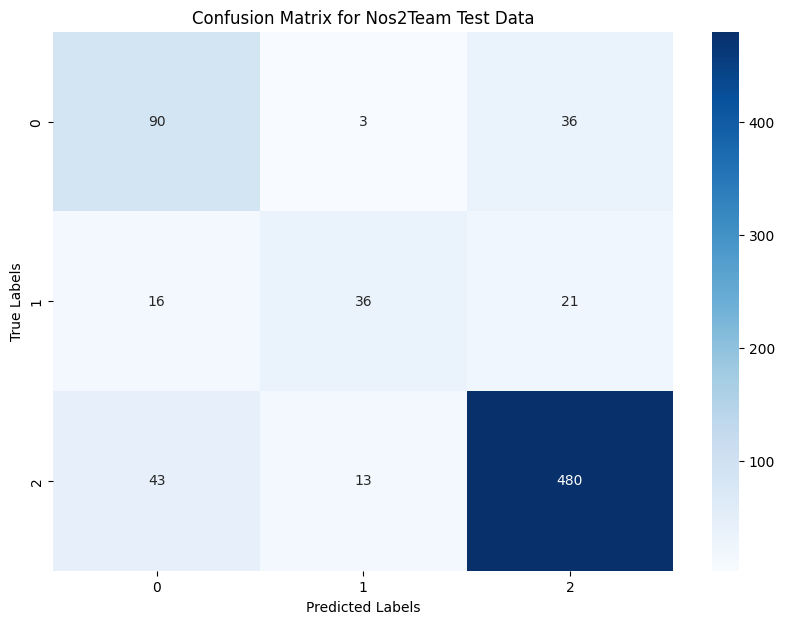

     Dataset  Validation Accuracy  Test Accuracy  Test F1 Score
0    RawFull             0.532520       0.585366       0.562020
1    RawTeam             0.819783       0.834688       0.834843
2    PreFull             0.573171       0.596206       0.578841
3    PreTeam             0.814363       0.821138       0.822463
4    LowFull             0.550135       0.600271       0.587296
5    LowTeam             0.803523       0.826558       0.825310
6    AlpFull             0.556911       0.594851       0.583539
7    AlpTeam             0.792683       0.802168       0.804478
8    SteFull             0.551490       0.601626       0.581893
9    SteTeam             0.803523       0.837398       0.835462
10   StoFull             0.529810       0.575881       0.565759
11   StoTeam             0.826558       0.807588       0.808961
12   NolFull             0.596206       0.612466       0.597348
13   NolTeam             0.814363       0.807588       0.811104
14   NoaFull             0.531165       

In [33]:
def train_and_evaluate_cnn(prefix):
    # Set random seed for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Retrieve the dataset using dynamic variable names
    train_data = np.array(globals()[f'{prefix}_train_data'])
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = np.array(globals()[f'{prefix}_val_data'])
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = np.array(globals()[f'{prefix}_test_data'])
    test_labels = globals()[f'{prefix}_test_labels']

    # Encoding labels
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    val_labels_encoded = label_encoder.transform(val_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Convert labels to categorical
    train_labels_categorical = to_categorical(train_labels_encoded)
    val_labels_categorical = to_categorical(val_labels_encoded)
    test_labels_categorical = to_categorical(test_labels_encoded)

    # Reshape data for 1D CNN input
    train_data_reshaped = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
    val_data_reshaped = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)
    test_data_reshaped = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(train_data_reshaped.shape[1], 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(train_labels_categorical.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the CNN model
    model.fit(train_data_reshaped, train_labels_categorical, epochs=25, batch_size=32, verbose=0)

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(val_data_reshaped, val_labels_categorical, verbose=0)
    val_f1 = f1_score(val_labels_encoded, model.predict(val_data_reshaped).argmax(axis=1), average='weighted')

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_data_reshaped, test_labels_categorical, verbose=0)
    test_f1 = f1_score(test_labels_encoded, model.predict(test_data_reshaped).argmax(axis=1), average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels_encoded, model.predict(test_data_reshaped).argmax(axis=1))
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df

# Example usage
prefixes = [prefix for _, _, prefix in datasets.values()]

combined_results = pd.DataFrame()

for prefix in prefixes:
    results = train_and_evaluate_cnn(prefix)
    combined_results = pd.concat([combined_results, results], ignore_index=True)

print(combined_results)

## 6.4 FFNN (MLP)

24/24 [==============================] - 0s 1ms/step


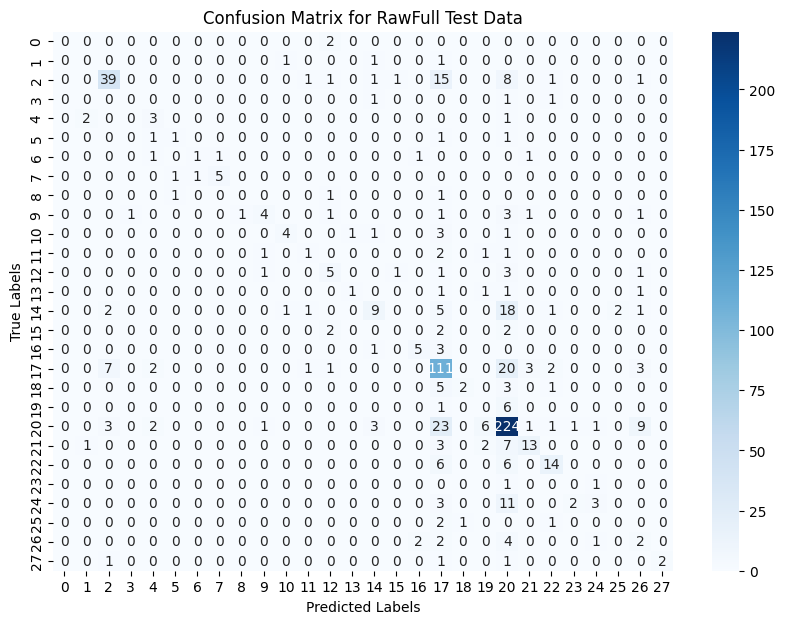

24/24 [==============================] - 0s 1ms/step


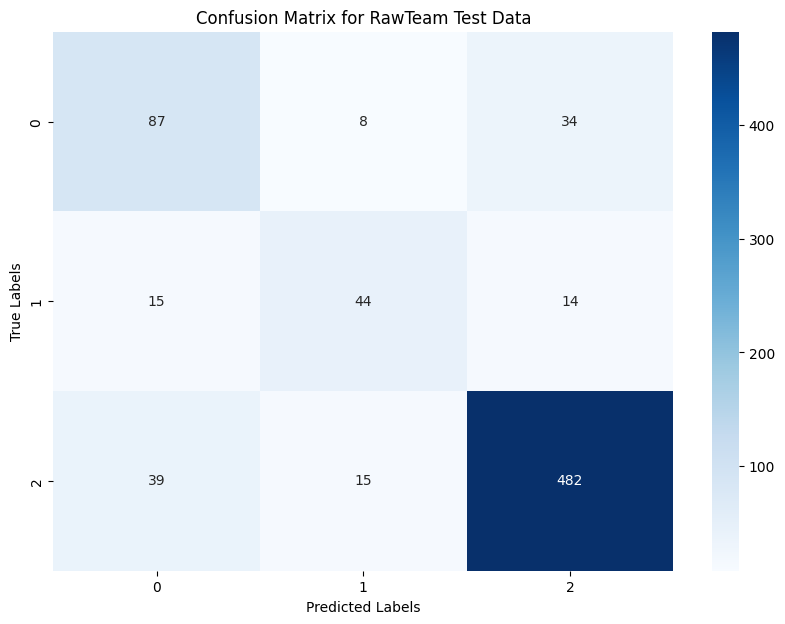

24/24 [==============================] - 0s 1ms/step


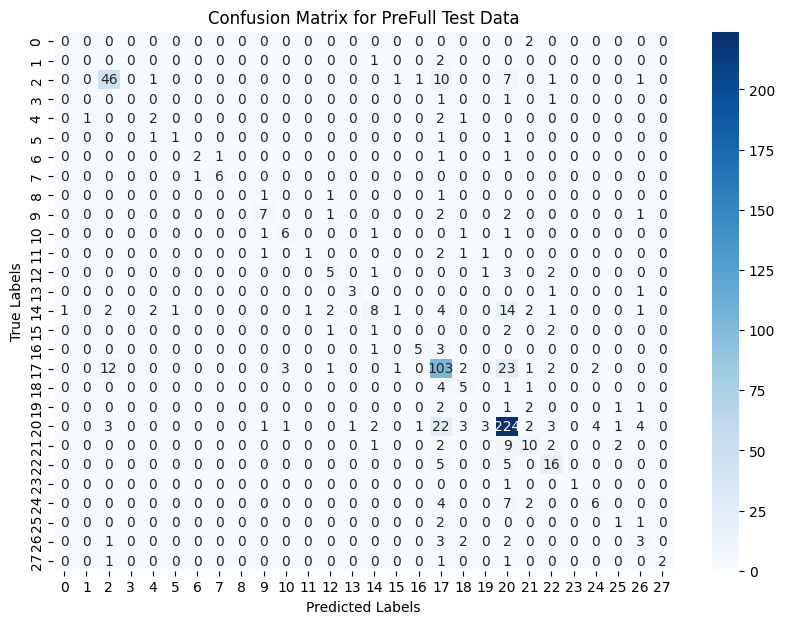

24/24 [==============================] - 0s 1ms/step


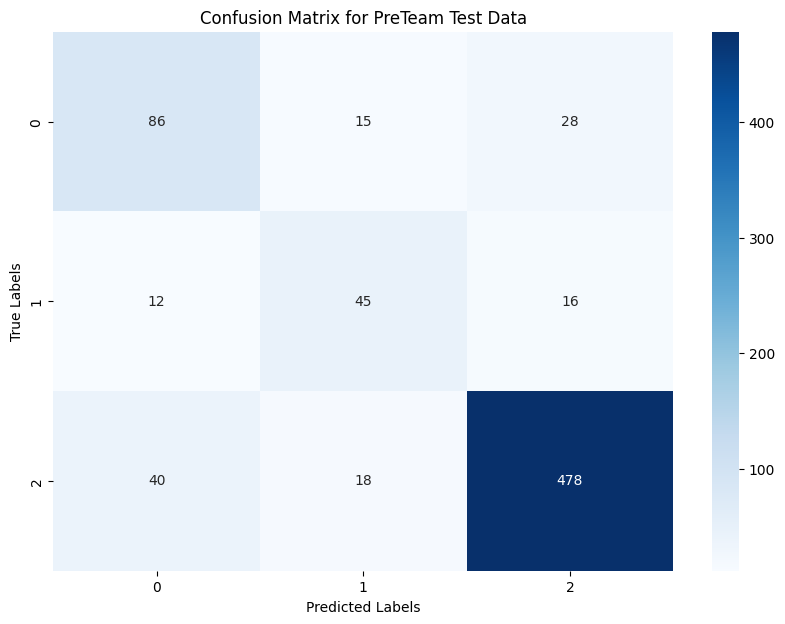

24/24 [==============================] - 0s 1ms/step


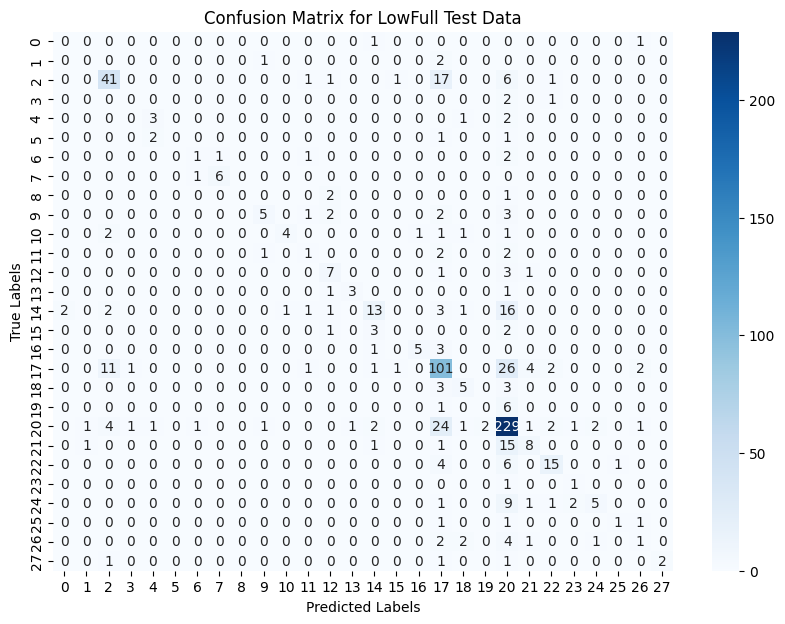

24/24 [==============================] - 0s 1ms/step


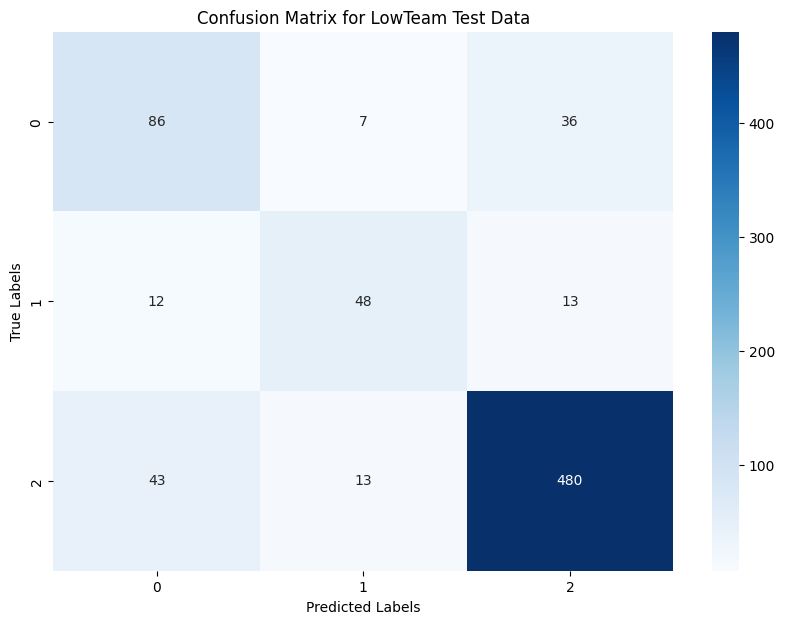

24/24 [==============================] - 0s 1ms/step


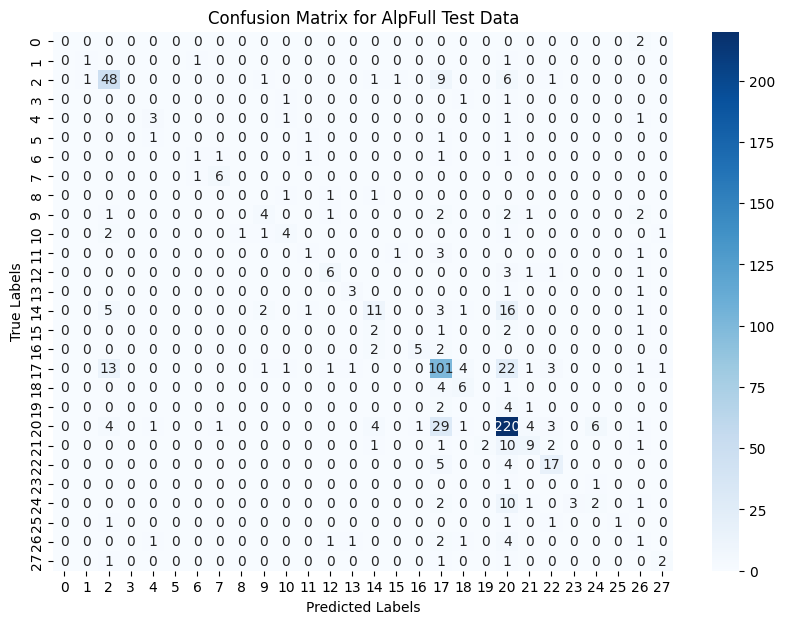

24/24 [==============================] - 0s 1ms/step


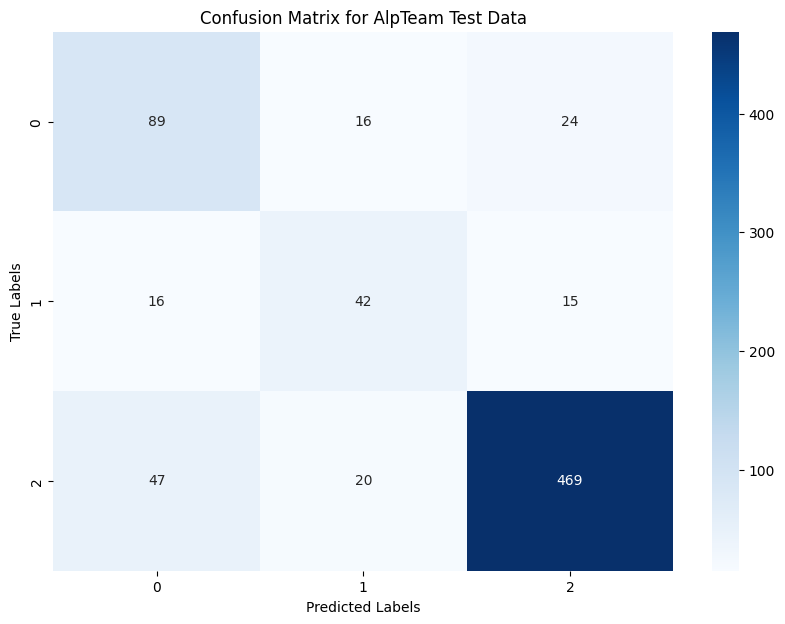

24/24 [==============================] - 0s 1ms/step


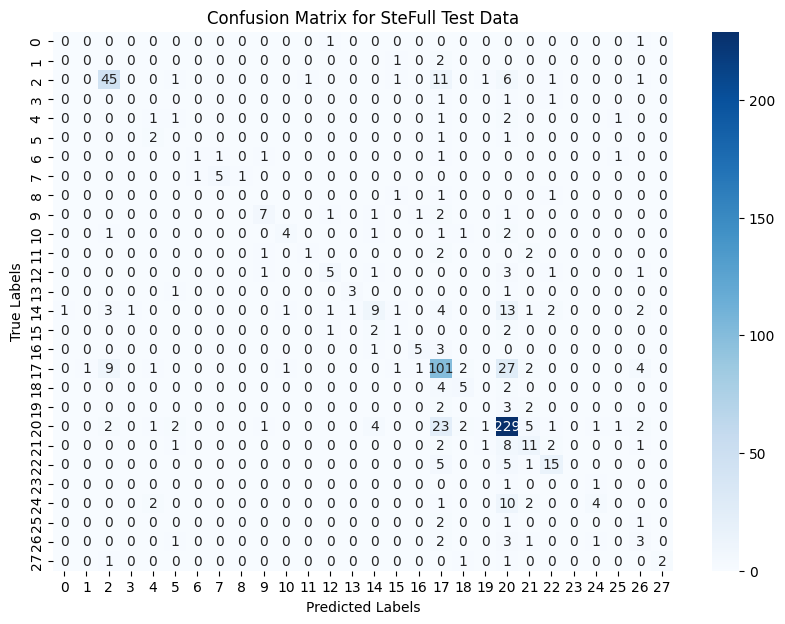

24/24 [==============================] - 0s 1ms/step


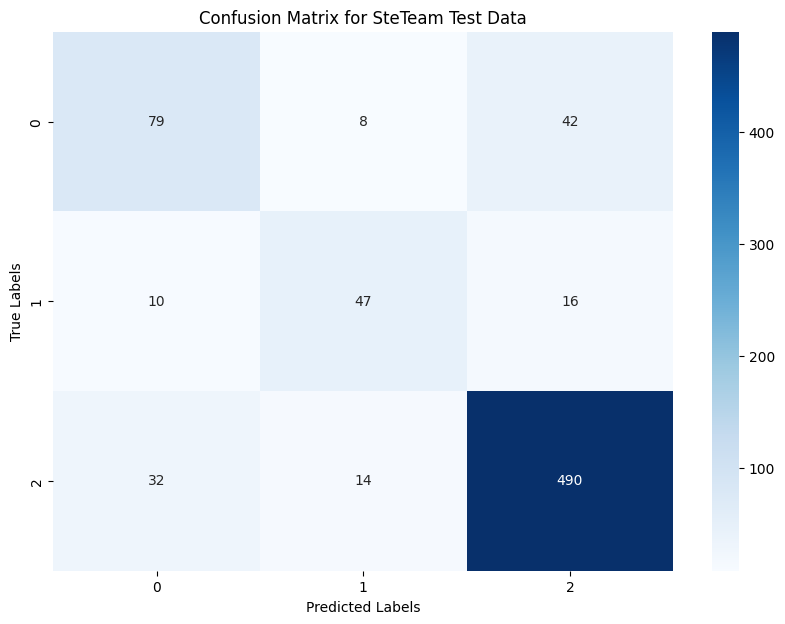

24/24 [==============================] - 0s 1ms/step


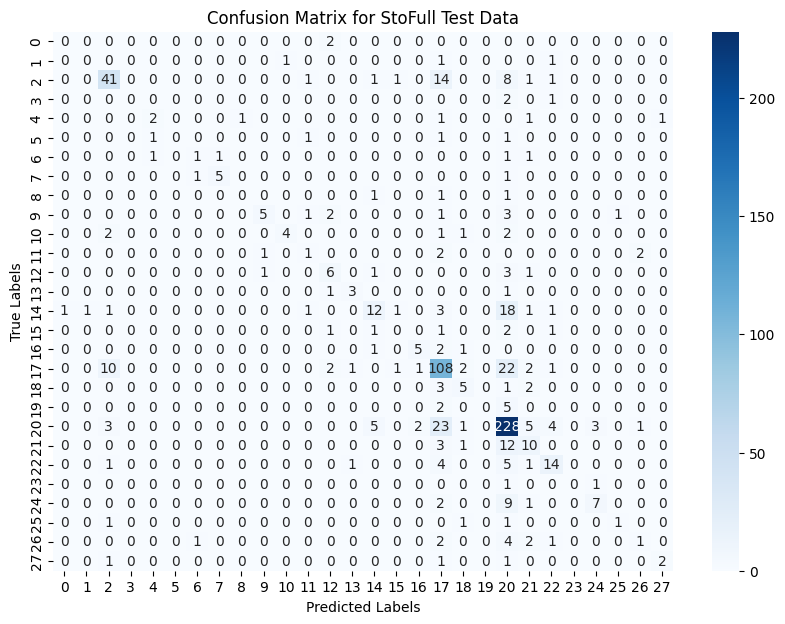

24/24 [==============================] - 0s 1ms/step


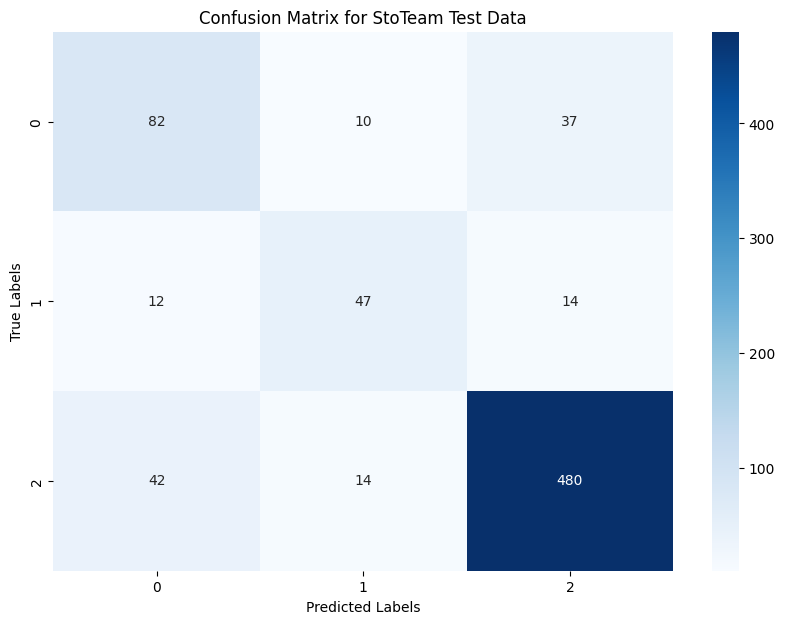

24/24 [==============================] - 0s 1ms/step


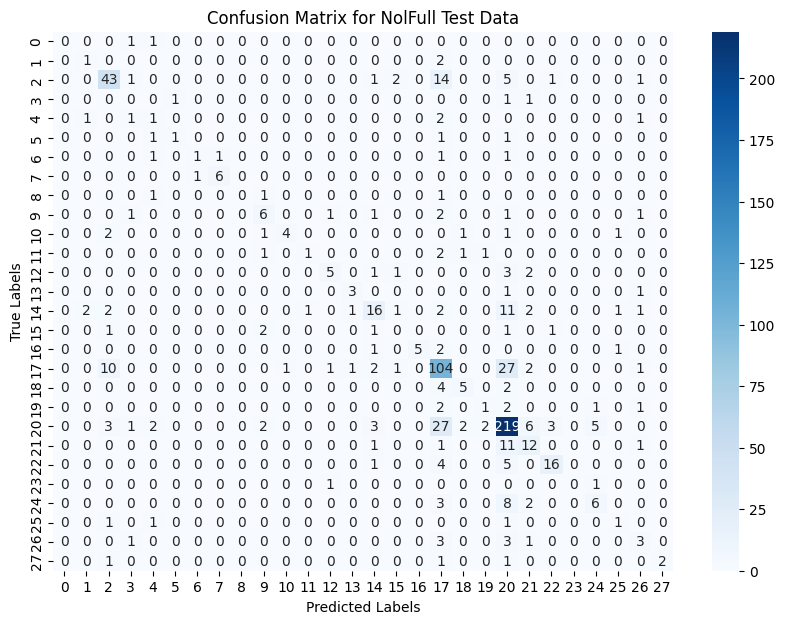

24/24 [==============================] - 0s 1ms/step


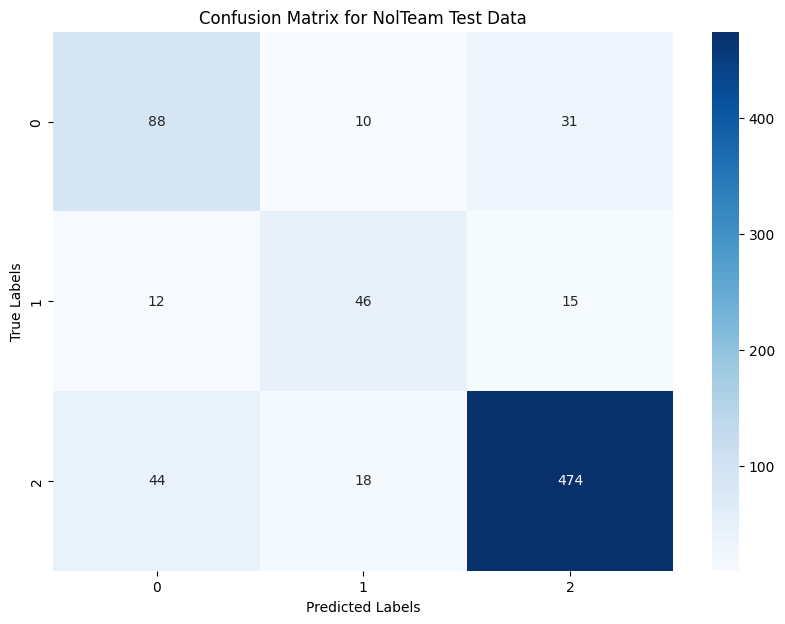

24/24 [==============================] - 0s 1ms/step


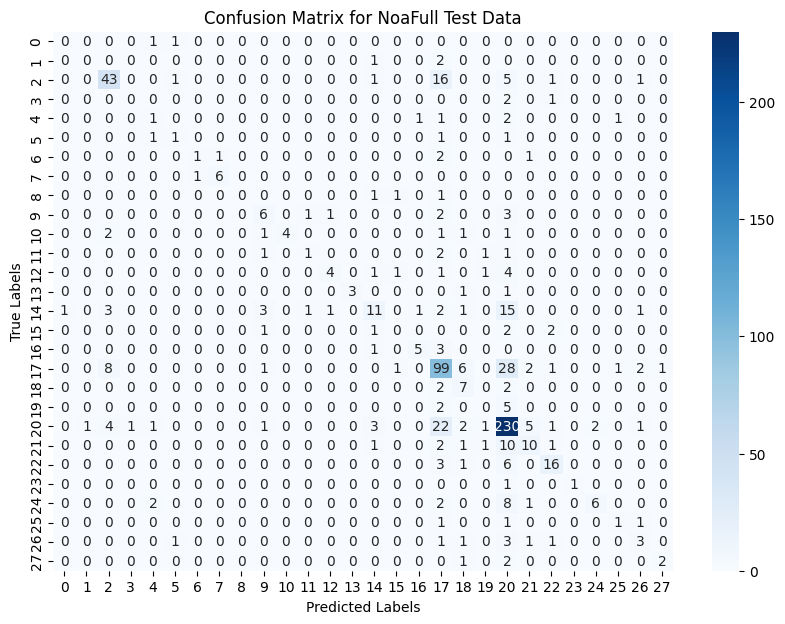

24/24 [==============================] - 0s 1ms/step


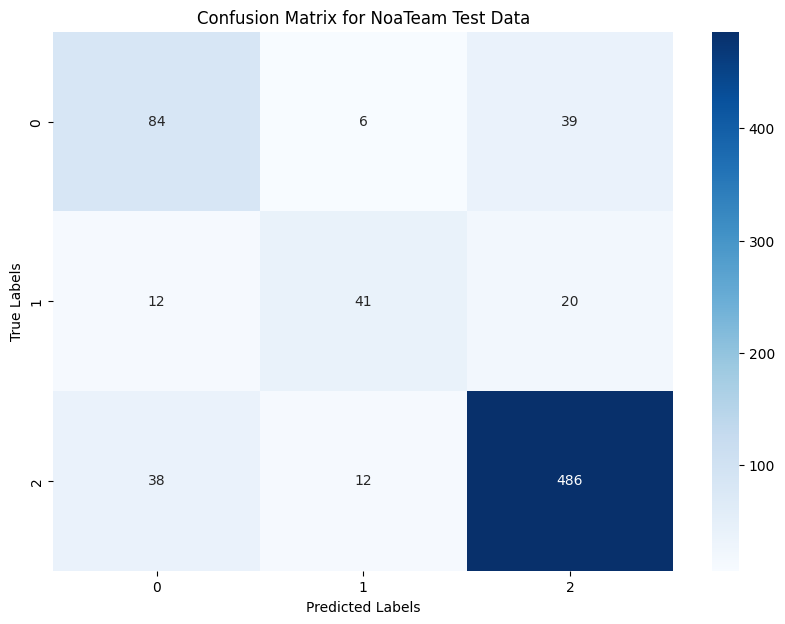

24/24 [==============================] - 0s 1ms/step


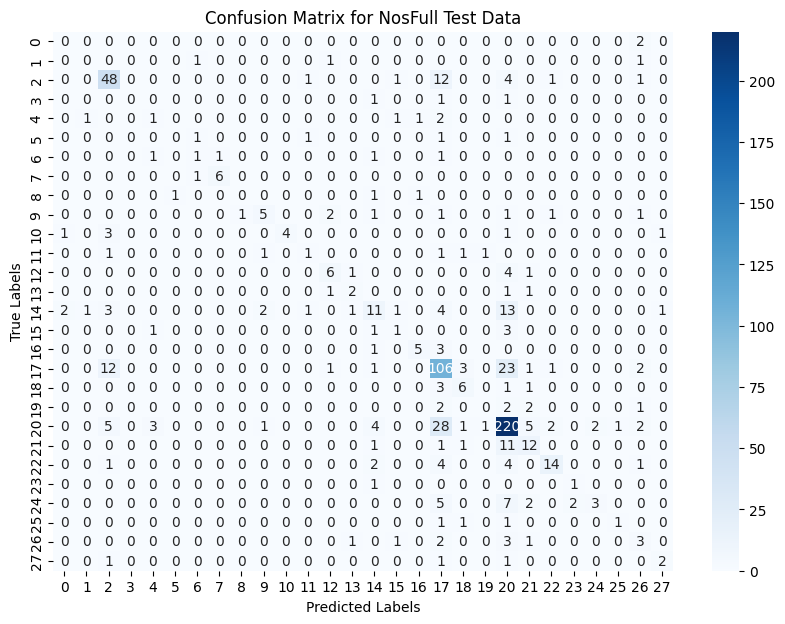

24/24 [==============================] - 0s 1ms/step


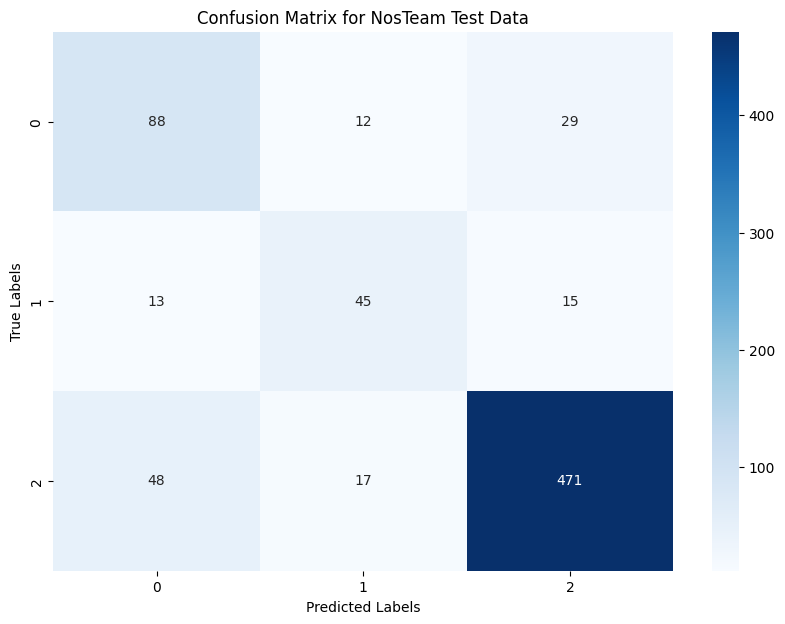

24/24 [==============================] - 0s 1ms/step


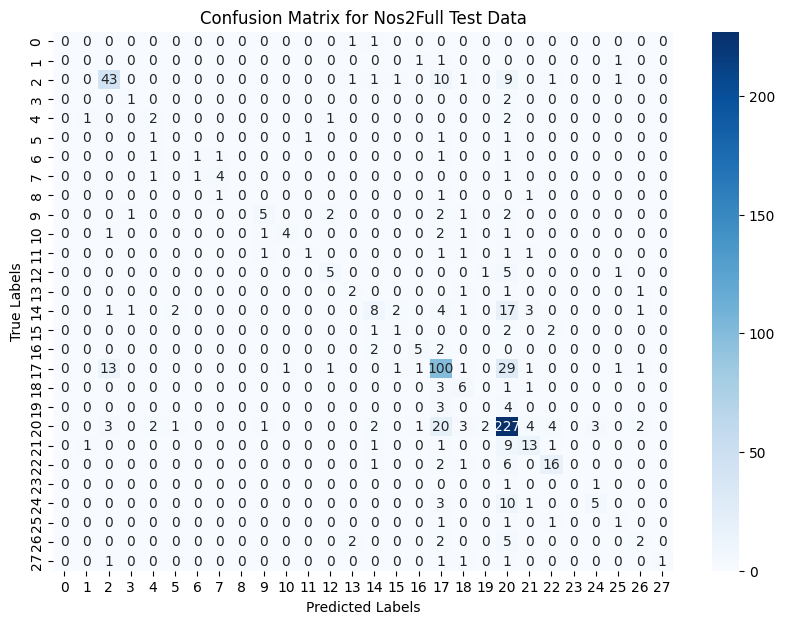

24/24 [==============================] - 0s 1ms/step


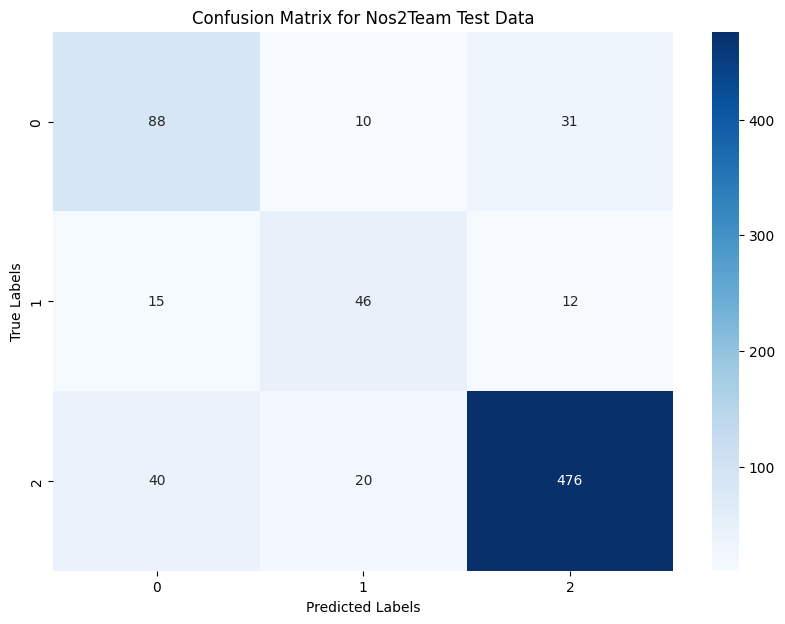

     Dataset  Validation Accuracy  Test Accuracy  Test F1 Score
0    RawFull             0.575881       0.608401       0.590014
1    RawTeam             0.813008       0.830623       0.831615
2    PreFull             0.581301       0.627371       0.611039
3    PreTeam             0.808943       0.825203       0.827827
4    LowFull             0.594851       0.619241       0.597380
5    LowTeam             0.819783       0.831978       0.833381
6    AlpFull             0.600271       0.612466       0.592002
7    AlpTeam             0.794038       0.813008       0.818297
8    SteFull             0.573171       0.619241       0.602640
9    SteTeam             0.825203       0.834688       0.832558
10   StoFull             0.584011       0.624661       0.601175
11   StoTeam             0.817073       0.825203       0.826201
12   NolFull             0.593496       0.626016       0.616544
13   NolTeam             0.810298       0.823848       0.826604
14   NoaFull             0.588076       

In [37]:
def train_and_evaluate_mlp(prefix):
    # Set random seed for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Retrieve the dataset using dynamic variable names
    train_data = np.array(globals()[f'{prefix}_train_data'])
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = np.array(globals()[f'{prefix}_val_data'])
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = np.array(globals()[f'{prefix}_test_data'])
    test_labels = globals()[f'{prefix}_test_labels']

    # Encoding labels
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    val_labels_encoded = label_encoder.transform(val_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Convert labels to categorical
    train_labels_categorical = to_categorical(train_labels_encoded)
    val_labels_categorical = to_categorical(val_labels_encoded)
    test_labels_categorical = to_categorical(test_labels_encoded)

    # Flatten the data for MLP input
    train_data_flattened = train_data.reshape(train_data.shape[0], -1)
    val_data_flattened = val_data.reshape(val_data.shape[0], -1)
    test_data_flattened = test_data.reshape(test_data.shape[0], -1)

    # Model architecture
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(train_data_flattened.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(train_labels_categorical.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the MLP model
    model.fit(train_data_flattened, train_labels_categorical, epochs=25, batch_size=32, verbose=0)

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(val_data_flattened, val_labels_categorical, verbose=0)
    val_f1 = f1_score(val_labels_encoded, model.predict(val_data_flattened).argmax(axis=1), average='weighted')

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_data_flattened, test_labels_categorical, verbose=0)
    test_f1 = f1_score(test_labels_encoded, model.predict(test_data_flattened).argmax(axis=1), average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels_encoded, model.predict(test_data_flattened).argmax(axis=1))
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df


# Example usage
prefixes = [prefix for _, _, prefix in datasets.values()]

combined_results = pd.DataFrame()

for prefix in prefixes:
    results = train_and_evaluate_mlp(prefix)
    combined_results = pd.concat([combined_results, results], ignore_index=True)

print(combined_results)

# 7. BERT

In [38]:
# Load Dutch RoBERTa tokenizer and model
MODEL_NAME = 'pdelobelle/robbert-v2-dutch-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaModel.from_pretrained(MODEL_NAME)

def extract_features(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**inputs)
    # Use the output corresponding to the CLS token (first token)
    cls_token_output = output['last_hidden_state'][:,0,:].numpy()
    return cls_token_output

Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# For Raw
Bert_Raw = pd.DataFrame()
Bert_Raw['Features'] = Dataset['Contents'].apply(extract_features)
Bert_Raw_Team = pd.DataFrame()
Bert_Raw_Full = pd.DataFrame()
Bert_Raw_Team['Features'] = Bert_Raw['Features']
Bert_Raw_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Raw_Full['Features'] = Bert_Raw['Features']
Bert_Raw_Full['Label'] = Dataset['Label']

In [10]:
Bert_Raw_Team.to_pickle('Bert_Raw_Team.pkl')
Bert_Raw_Full.to_pickle('Bert_Raw_Full.pkl')

In [11]:
# For Preprocessed
Bert_Pre = pd.DataFrame()
Bert_Pre['Features'] = Dataset['Preprocessed'].apply(extract_features)
Bert_Pre_Team = pd.DataFrame()
Bert_Pre_Full = pd.DataFrame()
Bert_Pre_Team['Features'] = Bert_Pre['Features']
Bert_Pre_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Pre_Full['Features'] = Bert_Pre['Features']
Bert_Pre_Full['Label'] = Dataset['Label']

In [13]:
Bert_Pre_Team.to_pickle('Bert_Pre_Team.pkl')
Bert_Pre_Full.to_pickle('Bert_Pre_Full.pkl')

In [35]:
# For Lower Casing
Bert_Low = pd.DataFrame()
Bert_Low['Features'] = Dataset['LowerCasing'].apply(extract_features)
Bert_Low_Team = pd.DataFrame()
Bert_Low_Full = pd.DataFrame()
Bert_Low_Team['Features'] = Bert_Low['Features']
Bert_Low_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Low_Full['Features'] = Bert_Low['Features']
Bert_Low_Full['Label'] = Dataset['Label']

In [36]:
Bert_Low_Team.to_pickle('Bert_Low_Team.pkl')
Bert_Low_Full.to_pickle('Bert_Low_Full.pkl')

In [37]:
# For Alphabetical
Bert_Alp = pd.DataFrame()
Bert_Alp['Features'] = Dataset['Alphabetical'].apply(extract_features)
Bert_Alp_Team = pd.DataFrame()
Bert_Alp_Full = pd.DataFrame()
Bert_Alp_Team['Features'] = Bert_Alp['Features']
Bert_Alp_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Alp_Full['Features'] = Bert_Alp['Features']
Bert_Alp_Full['Label'] = Dataset['Label']

In [38]:
Bert_Alp_Team.to_pickle('Bert_Alp_Team.pkl')
Bert_Alp_Full.to_pickle('Bert_Alp_Full.pkl')

In [39]:
# For Stemming
Bert_Ste = pd.DataFrame()
Bert_Ste['Features'] = Dataset['Stemming'].apply(extract_features)
Bert_Ste_Team = pd.DataFrame()
Bert_Ste_Full = pd.DataFrame()
Bert_Ste_Team['Features'] = Bert_Ste['Features']
Bert_Ste_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Ste_Full['Features'] = Bert_Ste['Features']
Bert_Ste_Full['Label'] = Dataset['Label']

In [40]:
Bert_Ste_Team.to_pickle('Bert_Ste_Team.pkl')
Bert_Ste_Full.to_pickle('Bert_Ste_Full.pkl')

In [7]:
# For Stop Word Removal
Bert_Sto = pd.DataFrame()
Bert_Sto['Features'] = Dataset['StopWords'].apply(extract_features)
Bert_Sto_Team = pd.DataFrame()
Bert_Sto_Full = pd.DataFrame()
Bert_Sto_Team['Features'] = Bert_Sto['Features']
Bert_Sto_Team['Label'] = Dataset['AfdelingLabel'] 
Bert_Sto_Full['Features'] = Bert_Sto['Features']
Bert_Sto_Full['Label'] = Dataset['Label']

In [8]:
Bert_Sto_Team.to_pickle('Bert_Sto_Team.pkl')
Bert_Sto_Full.to_pickle('Bert_Sto_Full.pkl')

In [39]:
import pickle
# Function to split data and assign to global variables
def split_and_assign_data(df, label_column, prefix):
    # Split the data into train, validation, and test sets
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        df.drop(label_column, axis=1), 
        df[label_column], 
        test_size=0.4, 
        random_state=42, 
        stratify=df[label_column]
    )

    val_data, test_data, val_labels, test_labels = train_test_split(
        temp_data, 
        temp_labels, 
        test_size=0.5, 
        random_state=42, 
        stratify=temp_labels
    )

    # Assigning to variables with dynamic names
    globals()[f'{prefix}_train_data'] = train_data
    globals()[f'{prefix}_train_labels'] = train_labels
    globals()[f'{prefix}_test_data'] = test_data
    globals()[f'{prefix}_test_labels'] = test_labels
    globals()[f'{prefix}_val_data'] = val_data
    globals()[f'{prefix}_val_labels'] = val_labels

# Paths to the pickle files
bert_raw_team_path = 'Bert_Raw_Team.pkl'
bert_raw_full_path = 'Bert_Raw_Full.pkl'
bert_pre_team_path = 'Bert_Pre_Team.pkl'
bert_pre_full_path = 'Bert_Pre_Full.pkl'

bert_low_team_path = 'Bert_Low_Team.pkl'
bert_low_full_path = 'Bert_Low_Full.pkl'
bert_alp_team_path = 'Bert_Alp_Team.pkl'
bert_alp_full_path = 'Bert_Alp_Full.pkl'

bert_ste_team_path = 'Bert_Ste_Team.pkl'
bert_ste_full_path = 'Bert_Ste_Full.pkl'
bert_sto_team_path = 'Bert_Sto_Team.pkl'
bert_sto_full_path = 'Bert_Sto_Full.pkl'

# Load the BERT pickle files
with open(bert_raw_team_path, 'rb') as file:
    Bert_Raw_Team = pickle.load(file)
with open(bert_raw_full_path, 'rb') as file:
    Bert_Raw_Full = pickle.load(file)
with open(bert_pre_team_path, 'rb') as file:
    Bert_Pre_Team = pickle.load(file)
with open(bert_pre_full_path, 'rb') as file:
    Bert_Pre_Full = pickle.load(file)
with open(bert_low_team_path, 'rb') as file:
    Bert_Low_Team = pickle.load(file)
with open(bert_low_full_path, 'rb') as file:
    Bert_Low_Full = pickle.load(file)
with open(bert_alp_team_path, 'rb') as file:
    Bert_Alp_Team = pickle.load(file)
with open(bert_alp_full_path, 'rb') as file:
    Bert_Alp_Full = pickle.load(file)
with open(bert_ste_team_path, 'rb') as file:
    Bert_Ste_Team = pickle.load(file)
with open(bert_ste_full_path, 'rb') as file:
    Bert_Ste_Full = pickle.load(file)
with open(bert_sto_team_path, 'rb') as file:
    Bert_Sto_Team = pickle.load(file)
with open(bert_sto_full_path, 'rb') as file:
    Bert_Sto_Full = pickle.load(file)

# Split and assign data for the Bert datasets
split_and_assign_data(Bert_Raw_Team, 'Label', 'Bert_Raw_Team')
split_and_assign_data(Bert_Raw_Full, 'Label', 'Bert_Raw_Full')
split_and_assign_data(Bert_Pre_Team, 'Label', 'Bert_Pre_Team')
split_and_assign_data(Bert_Pre_Full, 'Label', 'Bert_Pre_Full')

split_and_assign_data(Bert_Low_Team, 'Label', 'Bert_Low_Team')
split_and_assign_data(Bert_Low_Full, 'Label', 'Bert_Low_Full')
split_and_assign_data(Bert_Alp_Team, 'Label', 'Bert_Alp_Team')
split_and_assign_data(Bert_Alp_Full, 'Label', 'Bert_Alp_Full')

split_and_assign_data(Bert_Ste_Team, 'Label', 'Bert_Ste_Team')
split_and_assign_data(Bert_Ste_Full, 'Label', 'Bert_Ste_Full')
split_and_assign_data(Bert_Sto_Team, 'Label', 'Bert_Sto_Team')
split_and_assign_data(Bert_Sto_Full, 'Label', 'Bert_Sto_Full')



In [40]:
def extract_bert_vectors_general(data):
    # Check if the input is a DataFrame and has a 'Features' column
    if isinstance(data, pd.DataFrame) and 'Features' in data.columns:
        return np.array([row[0] for row in data['Features']])
    
    # Check if the input is an array of arrays
    elif isinstance(data, np.ndarray) and data.ndim == 2 and isinstance(data[0, 0], np.ndarray):
        return np.array([row[0] for row in data])
    
    # If the input is not recognized, print an error message
    else:
        print("Error: Unrecognized data format.")
        return None

# Example usage for different datasets
Bert_Raw_Team_train_data_processed = extract_bert_vectors_general(Bert_Raw_Team_train_data)
Bert_Raw_Team_val_data_processed = extract_bert_vectors_general(Bert_Raw_Team_val_data)
Bert_Raw_Team_test_data_processed = extract_bert_vectors_general(Bert_Raw_Team_test_data)

Bert_Raw_Full_train_data_processed = extract_bert_vectors_general(Bert_Raw_Full_train_data)
Bert_Raw_Full_val_data_processed = extract_bert_vectors_general(Bert_Raw_Full_val_data)
Bert_Raw_Full_test_data_processed = extract_bert_vectors_general(Bert_Raw_Full_test_data)

Bert_Pre_Team_train_data_processed = extract_bert_vectors_general(Bert_Pre_Team_train_data)
Bert_Pre_Team_val_data_processed = extract_bert_vectors_general(Bert_Pre_Team_val_data)
Bert_Pre_Team_test_data_processed = extract_bert_vectors_general(Bert_Pre_Team_test_data)

Bert_Pre_Full_train_data_processed = extract_bert_vectors_general(Bert_Pre_Full_train_data)
Bert_Pre_Full_val_data_processed = extract_bert_vectors_general(Bert_Pre_Full_val_data)
Bert_Pre_Full_test_data_processed = extract_bert_vectors_general(Bert_Pre_Full_test_data)



Bert_Low_Team_train_data_processed = extract_bert_vectors_general(Bert_Low_Team_train_data)
Bert_Low_Team_val_data_processed = extract_bert_vectors_general(Bert_Low_Team_val_data)
Bert_Low_Team_test_data_processed = extract_bert_vectors_general(Bert_Low_Team_test_data)

Bert_Low_Full_train_data_processed = extract_bert_vectors_general(Bert_Low_Full_train_data)
Bert_Low_Full_val_data_processed = extract_bert_vectors_general(Bert_Low_Full_val_data)
Bert_Low_Full_test_data_processed = extract_bert_vectors_general(Bert_Low_Full_test_data)

Bert_Alp_Team_train_data_processed = extract_bert_vectors_general(Bert_Alp_Team_train_data)
Bert_Alp_Team_val_data_processed = extract_bert_vectors_general(Bert_Alp_Team_val_data)
Bert_Alp_Team_test_data_processed = extract_bert_vectors_general(Bert_Alp_Team_test_data)

Bert_Alp_Full_train_data_processed = extract_bert_vectors_general(Bert_Alp_Full_train_data)
Bert_Alp_Full_val_data_processed = extract_bert_vectors_general(Bert_Alp_Full_val_data)
Bert_Alp_Full_test_data_processed = extract_bert_vectors_general(Bert_Alp_Full_test_data)



Bert_Ste_Team_train_data_processed = extract_bert_vectors_general(Bert_Ste_Team_train_data)
Bert_Ste_Team_val_data_processed = extract_bert_vectors_general(Bert_Ste_Team_val_data)
Bert_Ste_Team_test_data_processed = extract_bert_vectors_general(Bert_Ste_Team_test_data)

Bert_Ste_Full_train_data_processed = extract_bert_vectors_general(Bert_Ste_Full_train_data)
Bert_Ste_Full_val_data_processed = extract_bert_vectors_general(Bert_Ste_Full_val_data)
Bert_Ste_Full_test_data_processed = extract_bert_vectors_general(Bert_Ste_Full_test_data)

Bert_Sto_Team_train_data_processed = extract_bert_vectors_general(Bert_Sto_Team_train_data)
Bert_Sto_Team_val_data_processed = extract_bert_vectors_general(Bert_Sto_Team_val_data)
Bert_Sto_Team_test_data_processed = extract_bert_vectors_general(Bert_Sto_Team_test_data)

Bert_Sto_Full_train_data_processed = extract_bert_vectors_general(Bert_Sto_Full_train_data)
Bert_Sto_Full_val_data_processed = extract_bert_vectors_general(Bert_Sto_Full_val_data)
Bert_Sto_Full_test_data_processed = extract_bert_vectors_general(Bert_Sto_Full_test_data)

In [41]:
# Dataset prefixes for the BERT datasets
bert_prefixes = ['Bert_Raw_Team', 'Bert_Raw_Full', 'Bert_Pre_Team', 'Bert_Pre_Full', 'Bert_Low_Team', 'Bert_Low_Full', 'Bert_Alp_Team', 'Bert_Alp_Full', 'Bert_Ste_Team', 'Bert_Ste_Full', 'Bert_Sto_Team', 'Bert_Sto_Full']

def ensure_1d_labels(labels):
    if isinstance(labels, pd.Series):
        labels = labels.values  # Convert to numpy array
    if isinstance(labels, np.ndarray) and labels.ndim > 1:
        labels = labels.ravel()  # Flatten to 1D
    return labels

# Process labels for all datasets
for prefix in bert_prefixes:
    globals()[f'{prefix}_train_labels'] = ensure_1d_labels(globals()[f'{prefix}_train_labels'])
    globals()[f'{prefix}_val_labels'] = ensure_1d_labels(globals()[f'{prefix}_val_labels'])
    globals()[f'{prefix}_test_labels'] = ensure_1d_labels(globals()[f'{prefix}_test_labels'])


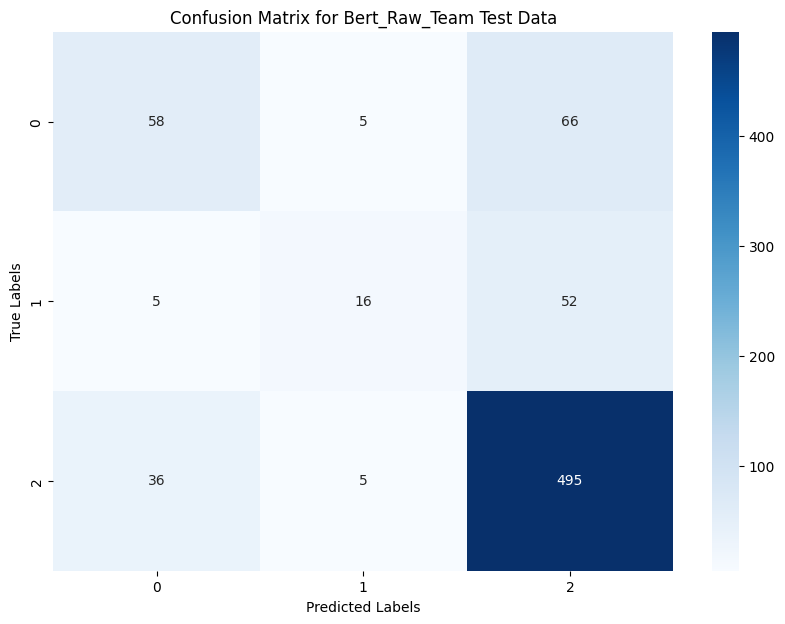

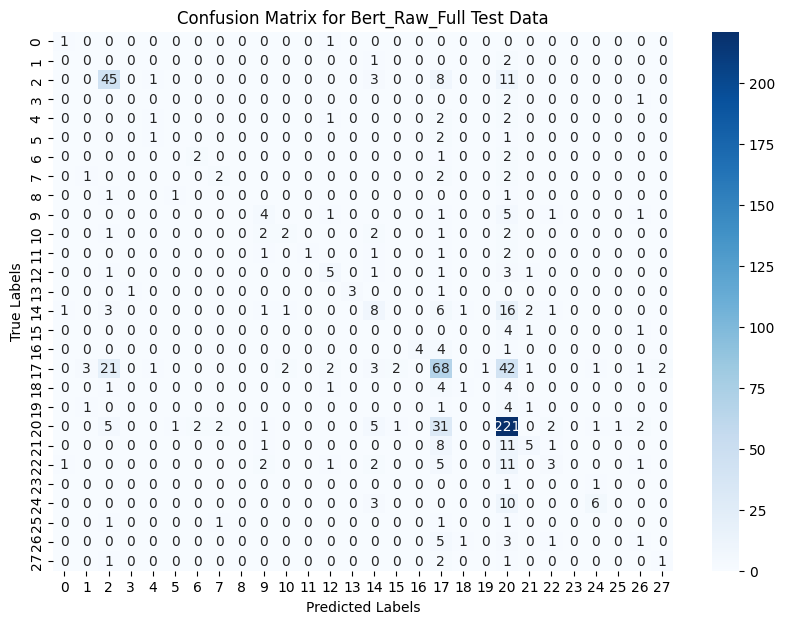

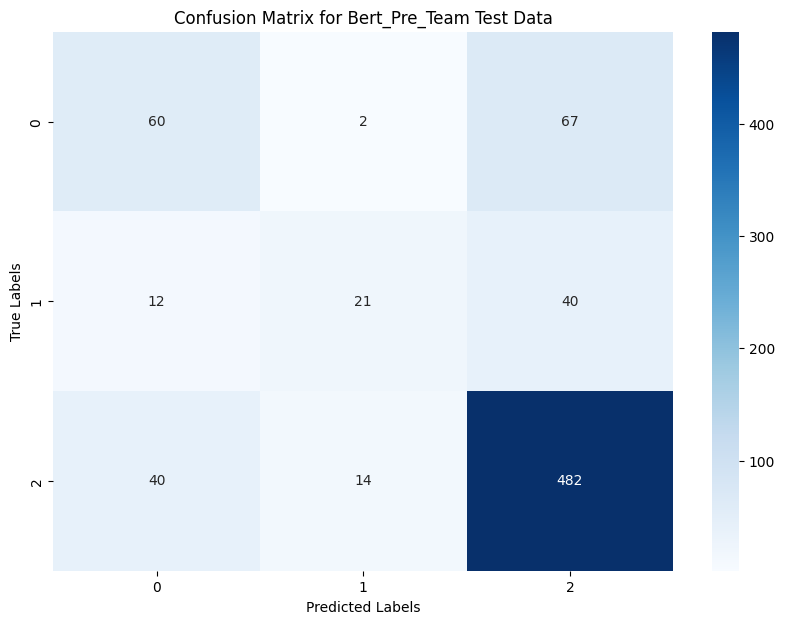

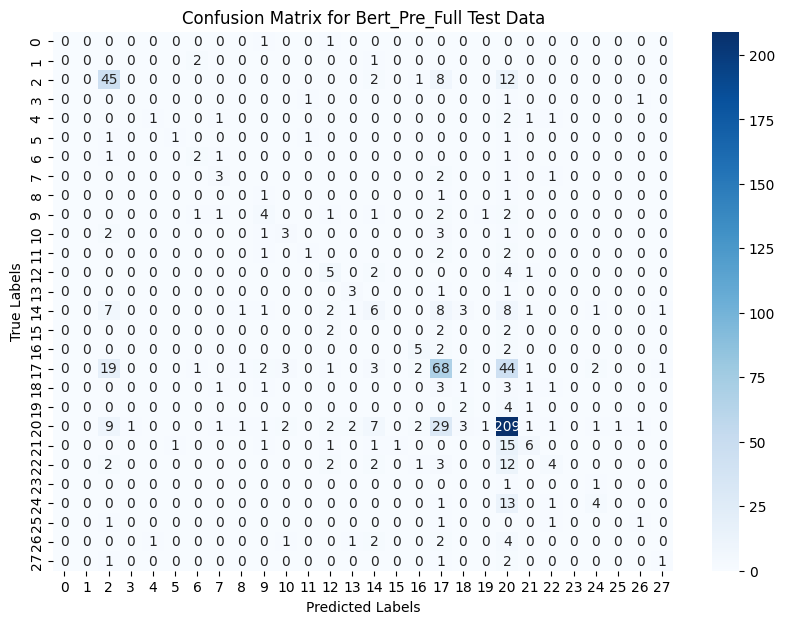

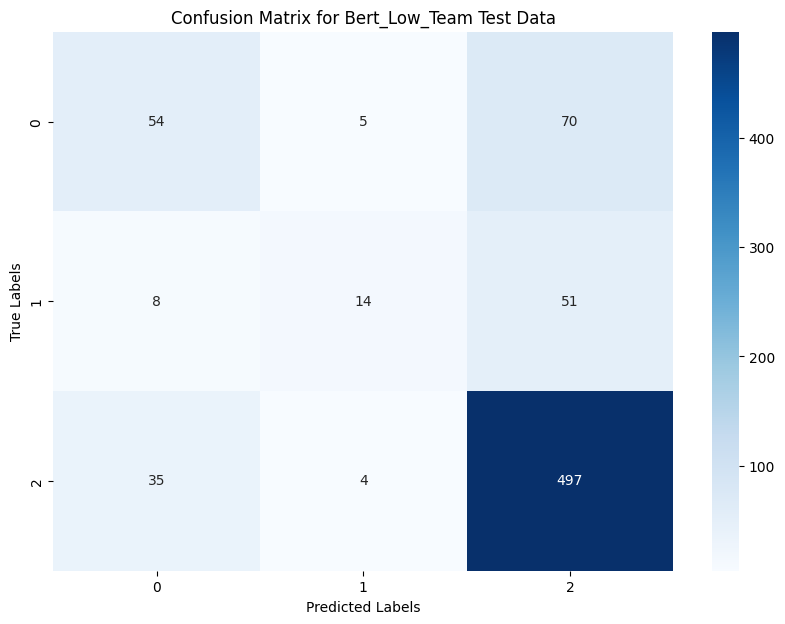

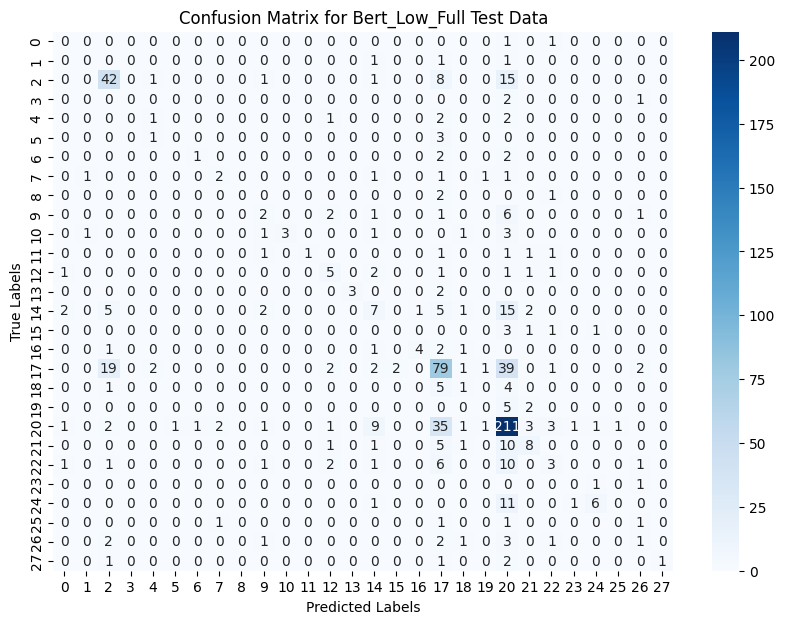

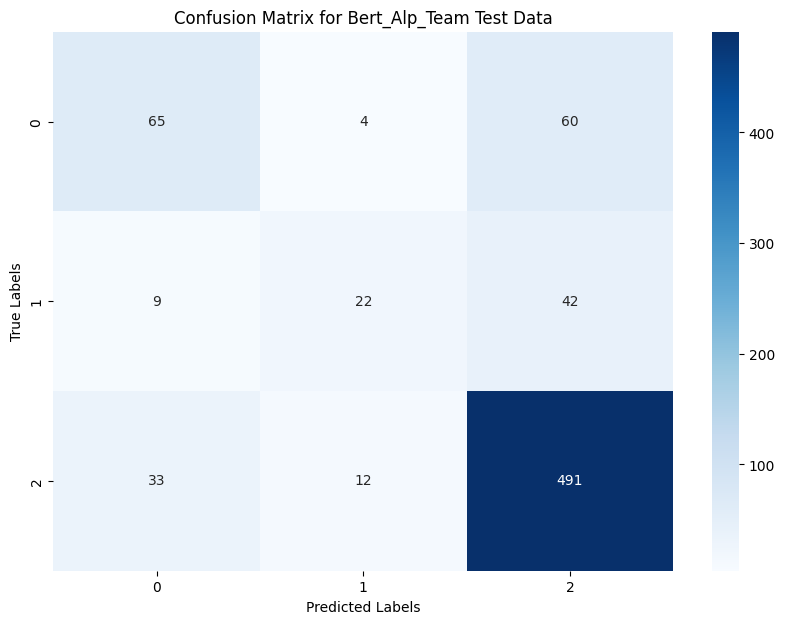

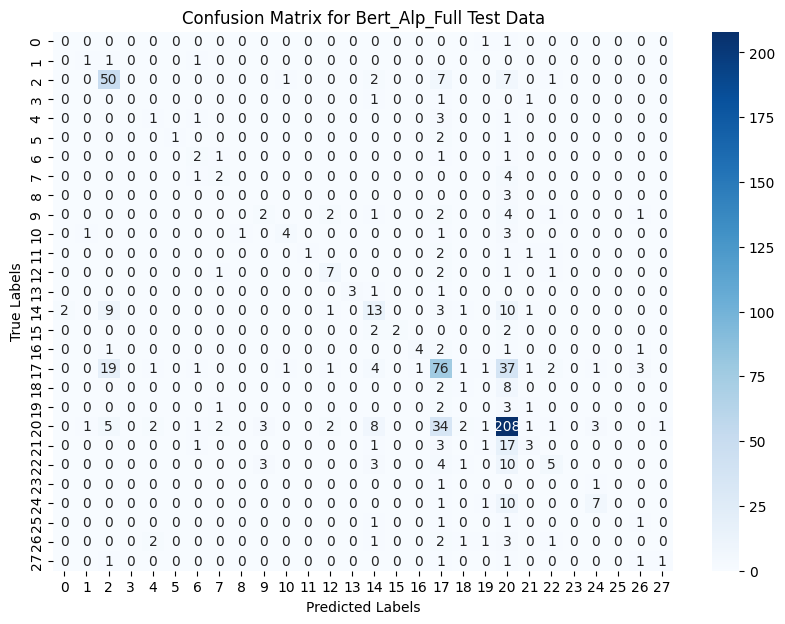

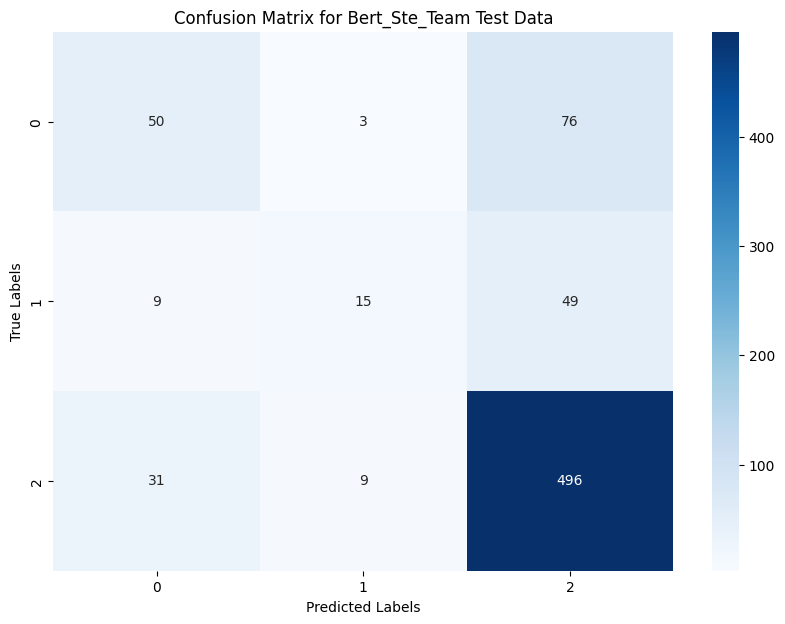

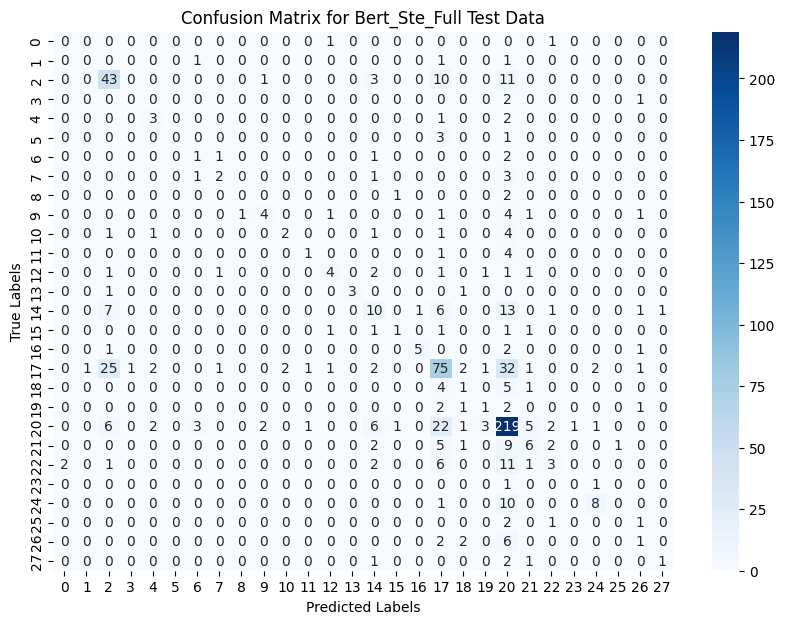

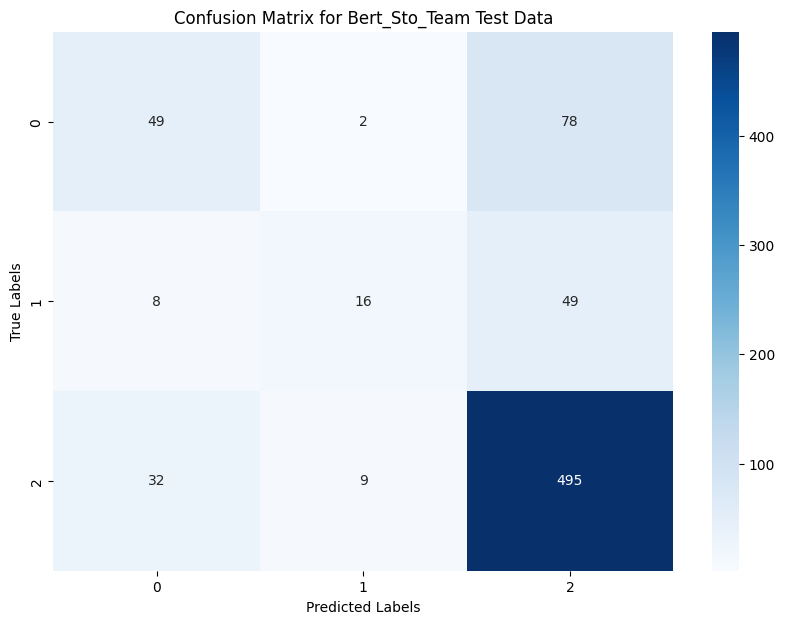

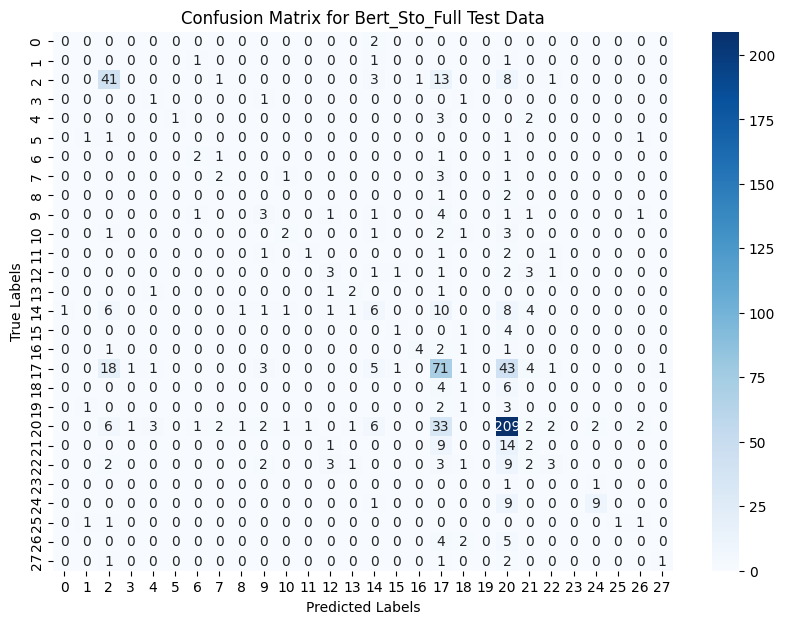

          Dataset  Validation Accuracy  Validation F1 Score  Test Accuracy  \
0   Bert_Raw_Team             0.762873             0.740889       0.771003   
1   Bert_Raw_Full             0.495935             0.474713       0.520325   
2   Bert_Pre_Team             0.768293             0.745714       0.762873   
3   Bert_Pre_Full             0.508130             0.484951       0.504065   
4   Bert_Low_Team             0.758808             0.734218       0.765583   
5   Bert_Low_Full             0.508130             0.487508       0.516260   
6   Bert_Alp_Team             0.771003             0.757066       0.783198   
7   Bert_Alp_Full             0.523035             0.504009       0.533875   
8   Bert_Ste_Team             0.762873             0.737476       0.760163   
9   Bert_Ste_Full             0.513550             0.488356       0.533875   
10  Bert_Sto_Team             0.747967             0.719681       0.758808   
11  Bert_Sto_Full             0.482385             0.456450     

In [42]:
def train_and_evaluate_svm(prefix):
    # Retrieve the dataset using dynamic variable names
    train_data = globals()[f'{prefix}_train_data_processed']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data_processed']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data_processed']
    test_labels = globals()[f'{prefix}_test_labels']

    # Train the SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(train_data, train_labels)

    # Evaluate on the validation set
    val_predictions = svm_model.predict(val_data)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions, average='weighted')

    # Evaluate on the test set
    test_predictions = svm_model.predict(test_data)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Validation F1 Score': [val_f1],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df

# Dataset prefixes for the BERT datasets
bert_prefixes = ['Bert_Raw_Team', 'Bert_Raw_Full', 'Bert_Pre_Team', 'Bert_Pre_Full', 'Bert_Low_Team', 'Bert_Low_Full', 'Bert_Alp_Team', 'Bert_Alp_Full', 'Bert_Ste_Team', 'Bert_Ste_Full', 'Bert_Sto_Team', 'Bert_Sto_Full']

# Combine results from both BERT datasets
combined_results_bert = pd.DataFrame()

for prefix in bert_prefixes:
    results = train_and_evaluate_svm(prefix)
    if results is not None:
        combined_results_bert = pd.concat([combined_results_bert, results], ignore_index=True)

# Display the combined results
print(combined_results_bert)


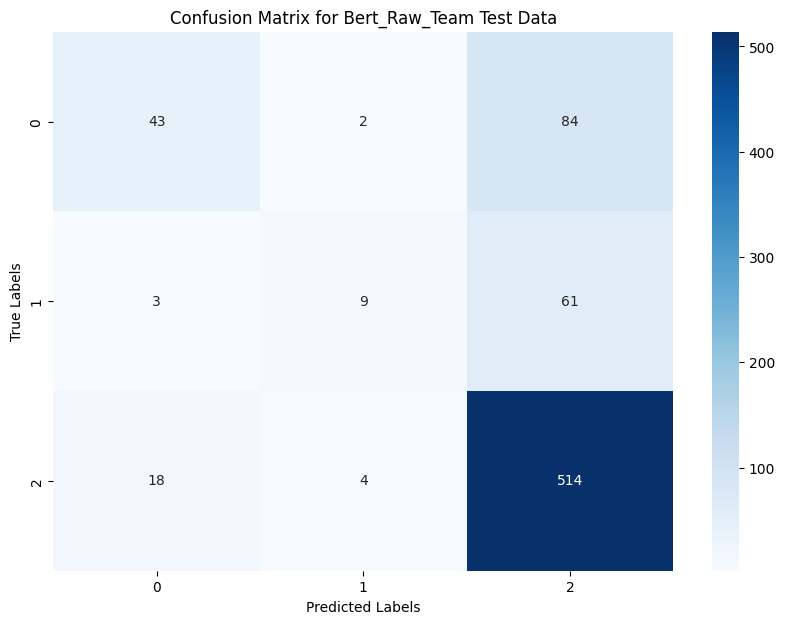

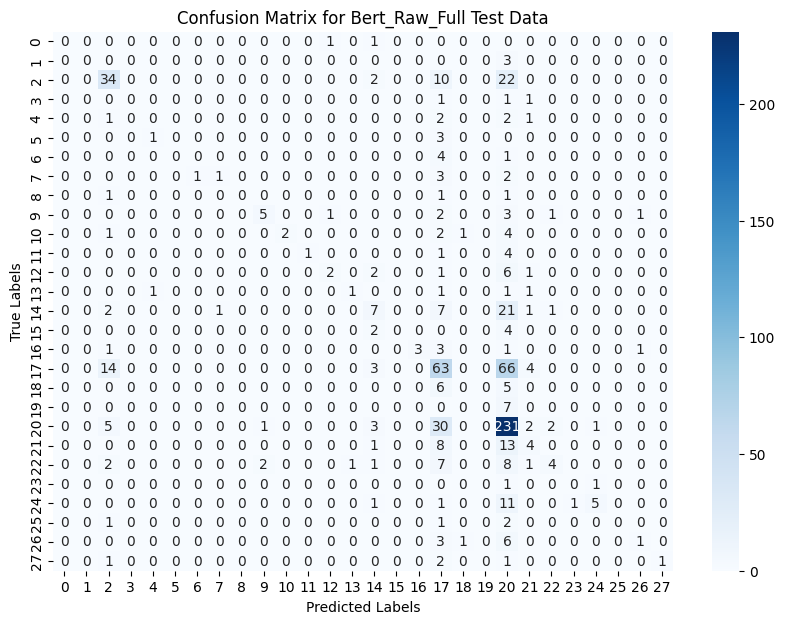

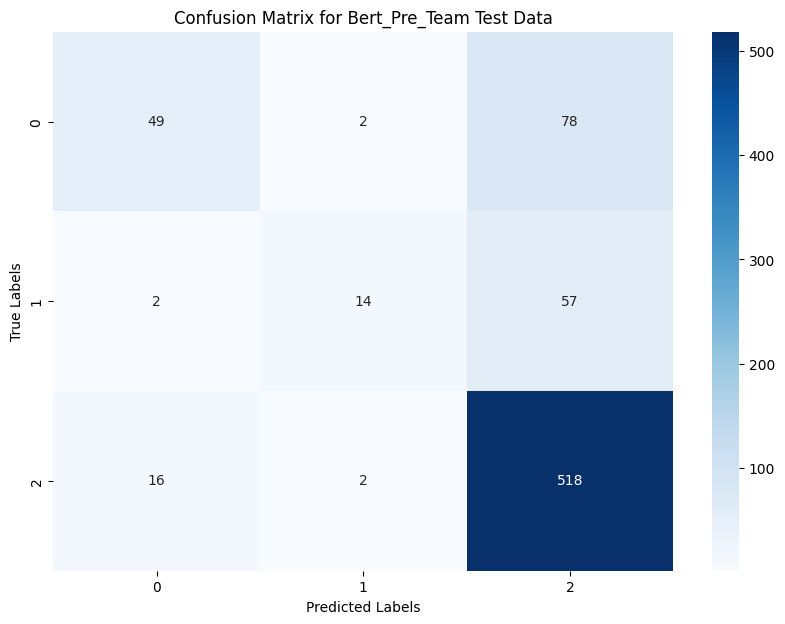

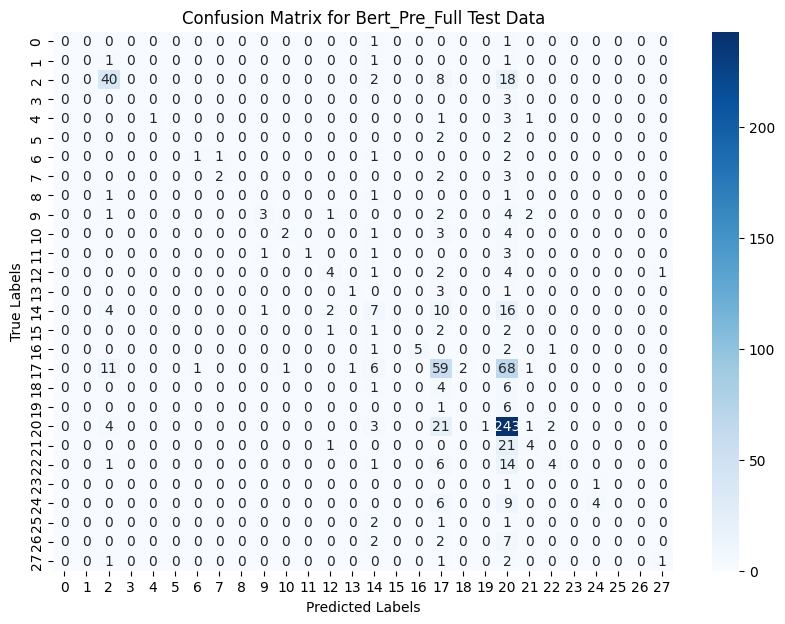

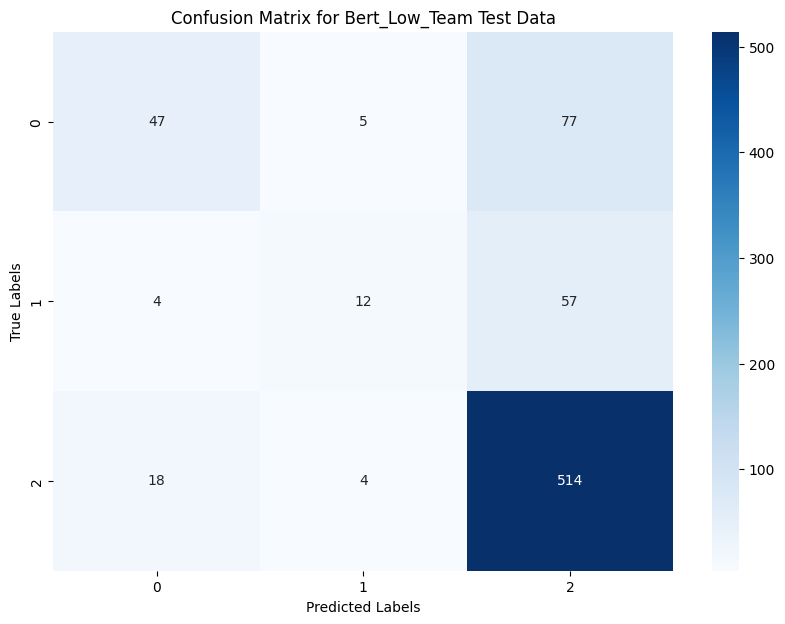

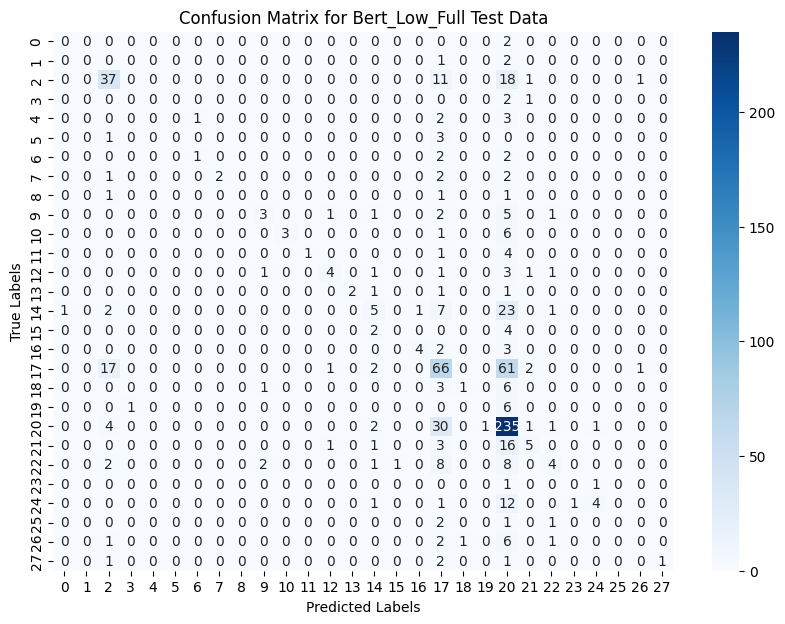

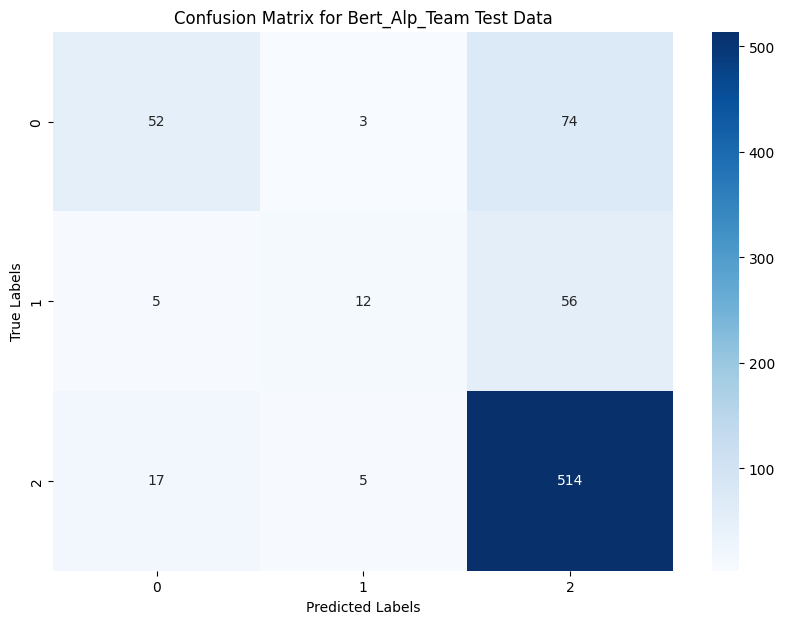

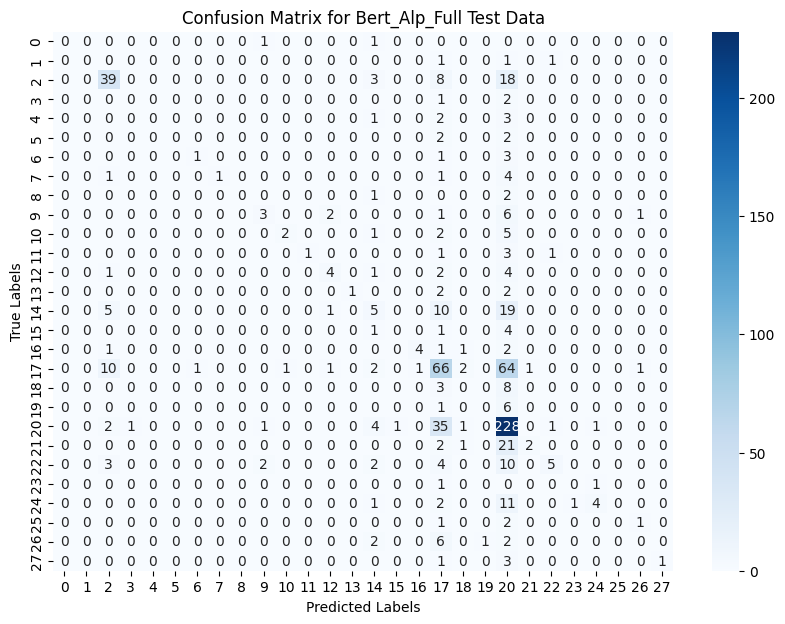

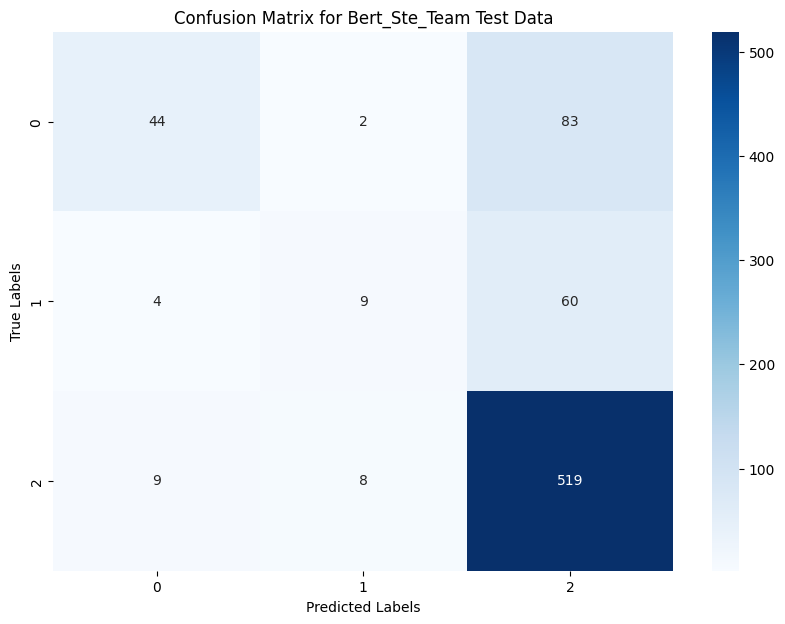

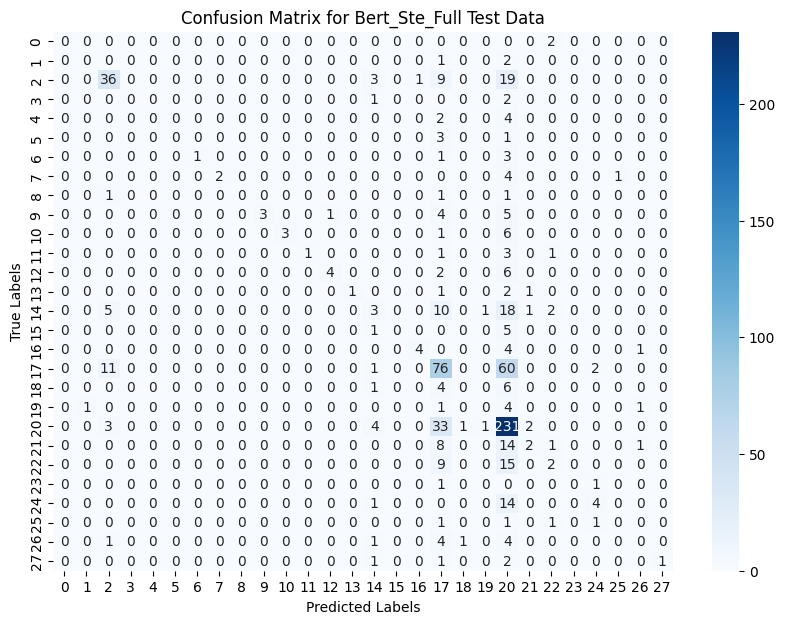

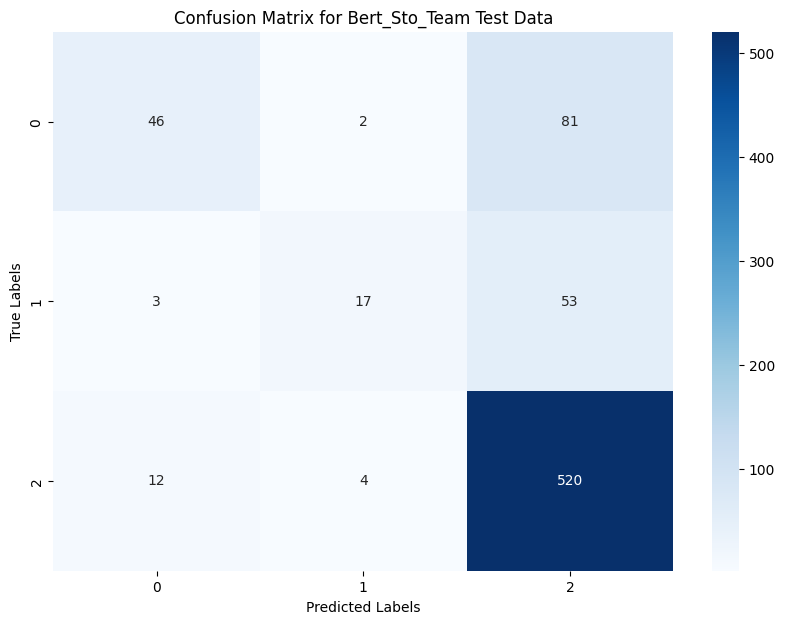

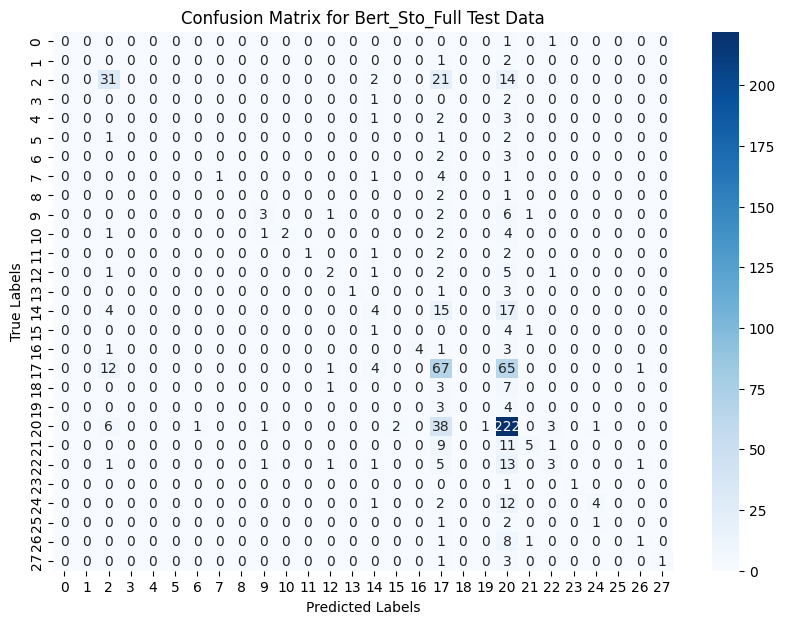

          Dataset  Validation Accuracy  Validation F1 Score  Test Accuracy  \
0   Bert_Raw_Team             0.785908             0.747475       0.766938   
1   Bert_Raw_Full             0.490515             0.450682       0.494580   
2   Bert_Pre_Team             0.791328             0.755848       0.787263   
3   Bert_Pre_Full             0.512195             0.474758       0.517615   
4   Bert_Low_Team             0.775068             0.736689       0.776423   
5   Bert_Low_Full             0.463415             0.421975       0.512195   
6   Bert_Alp_Team             0.781843             0.748193       0.783198   
7   Bert_Alp_Full             0.533875             0.490435       0.497290   
8   Bert_Ste_Team             0.765583             0.719600       0.775068   
9   Bert_Ste_Full             0.485095             0.443402       0.506775   
10  Bert_Sto_Team             0.766938             0.721362       0.789973   
11  Bert_Sto_Full             0.475610             0.430089     

In [43]:
def train_and_evaluate_xgboost(prefix):
    # Retrieve and encode the dataset using dynamic variable names
    train_data = globals()[f'{prefix}_train_data_processed']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data_processed']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data_processed']
    test_labels = globals()[f'{prefix}_test_labels']

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the encoder on the train labels and transform all label sets
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    val_labels_encoded = label_encoder.transform(val_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Instantiate and train the XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(train_data, train_labels_encoded)

    # Evaluate on the validation set
    val_predictions_encoded = xgb_model.predict(val_data)
    val_accuracy = accuracy_score(val_labels_encoded, val_predictions_encoded)
    val_f1 = f1_score(val_labels, label_encoder.inverse_transform(val_predictions_encoded), average='weighted')

    # Evaluate on the test set
    test_predictions_encoded = xgb_model.predict(test_data)
    test_accuracy = accuracy_score(test_labels_encoded, test_predictions_encoded)
    test_f1 = f1_score(test_labels, label_encoder.inverse_transform(test_predictions_encoded), average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(test_labels_encoded, test_predictions_encoded)
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Dataset': [prefix],
        'Validation Accuracy': [val_accuracy],
        'Validation F1 Score': [val_f1],
        'Test Accuracy': [test_accuracy],
        'Test F1 Score': [test_f1]
    })

    return results_df

# Dataset prefixes for the BERT datasets
bert_prefixes = ['Bert_Raw_Team', 'Bert_Raw_Full', 'Bert_Pre_Team', 'Bert_Pre_Full', 'Bert_Low_Team', 'Bert_Low_Full', 'Bert_Alp_Team', 'Bert_Alp_Full', 'Bert_Ste_Team', 'Bert_Ste_Full', 'Bert_Sto_Team', 'Bert_Sto_Full']

# Combine results from both BERT datasets
combined_results_xgb = pd.DataFrame()

for prefix in bert_prefixes:
    results = train_and_evaluate_xgboost(prefix)
    if results is not None:
        combined_results_xgb = pd.concat([combined_results_xgb, results], ignore_index=True)

# Display the combined results
print(combined_results_xgb)


Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 20ms/step - loss: 0.7841 - accuracy: 0.7220 - val_loss: 0.7483 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7345 - accuracy: 0.7274 - val_loss: 0.7286 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 18ms/step - loss: 0.7108 

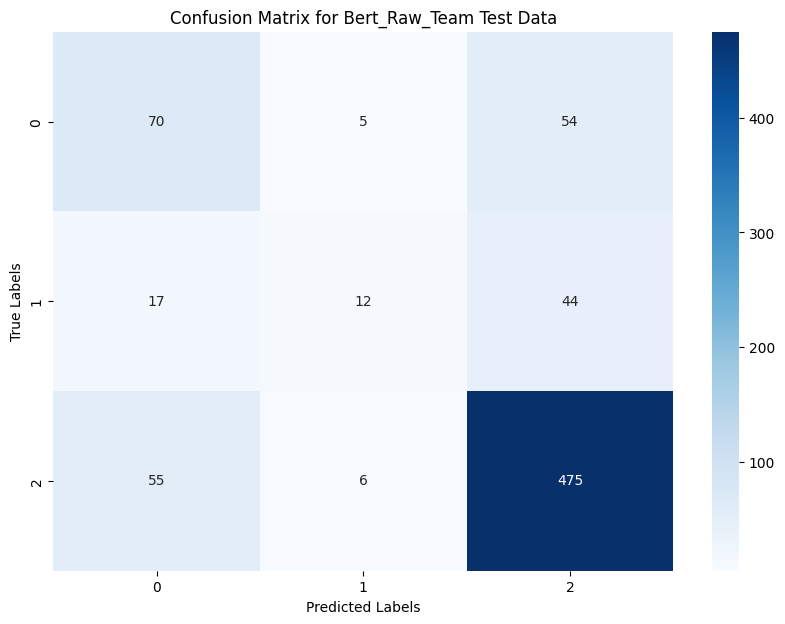

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 21ms/step - loss: 2.3903 - accuracy: 0.3373 - val_loss: 2.2561 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 17ms/step - loss: 2.2461 - accuracy: 0.3725 - val_loss: 2.1941 - val_accuracy: 0.3726
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3699 - val_f1_score: 0.2020
70/70 [==============================] - 1s 18ms/step - loss:

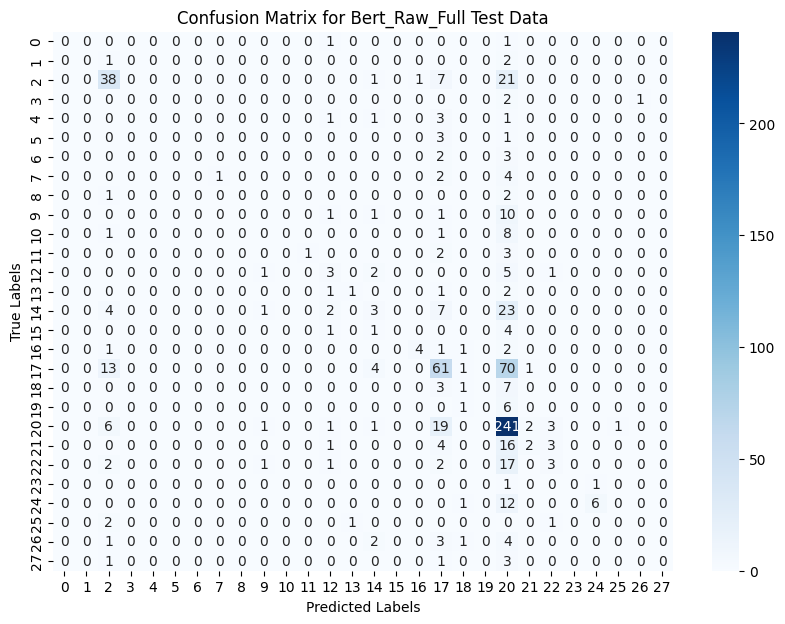

Epoch 1/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 21ms/step - loss: 0.7762 - accuracy: 0.7202 - val_loss: 0.7539 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7476 - accuracy: 0.7274 - val_loss: 0.7280 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7290 - val_f1_score: 0.6161
70/70 [==============================] - 1s 18ms/step - loss: 0.7174 

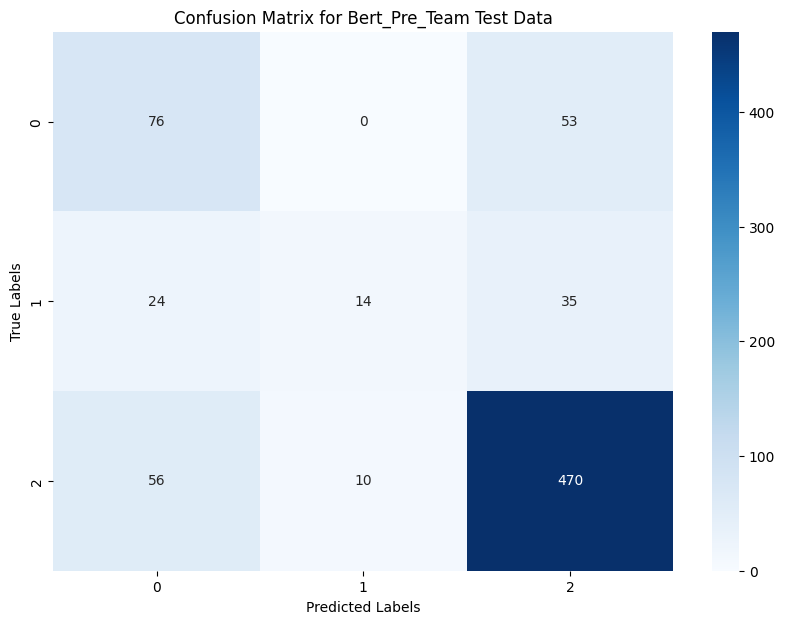

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 20ms/step - loss: 2.3777 - accuracy: 0.3653 - val_loss: 2.2280 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3415 - val_f1_score: 0.2676
70/70 [==============================] - 1s 17ms/step - loss: 2.2302 - accuracy: 0.3739 - val_loss: 2.2082 - val_accuracy: 0.3415
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 17ms/step - loss:

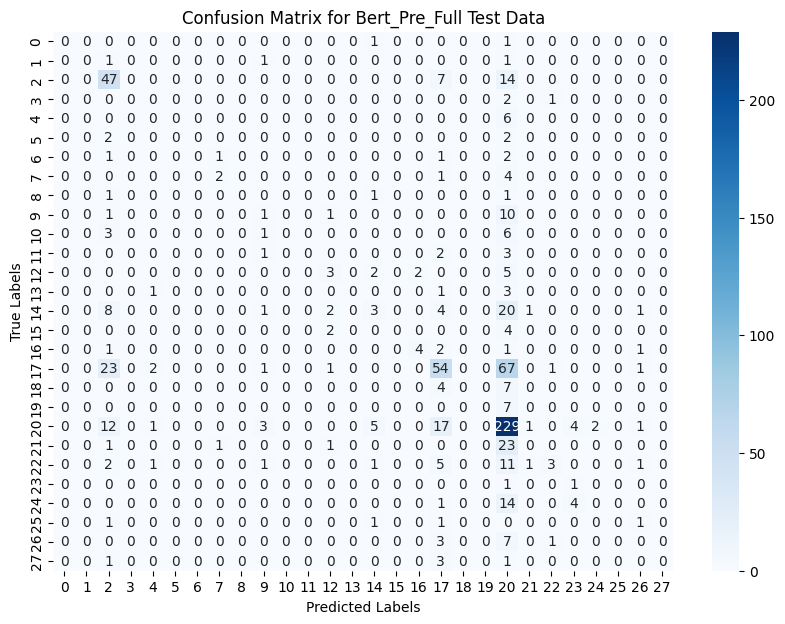

Epoch 1/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 21ms/step - loss: 0.7772 - accuracy: 0.7202 - val_loss: 0.7522 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7379 - accuracy: 0.7274 - val_loss: 0.7245 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7290 - val_f1_score: 0.6185
70/70 [==============================] - 1s 17ms/step - loss: 0.7119 

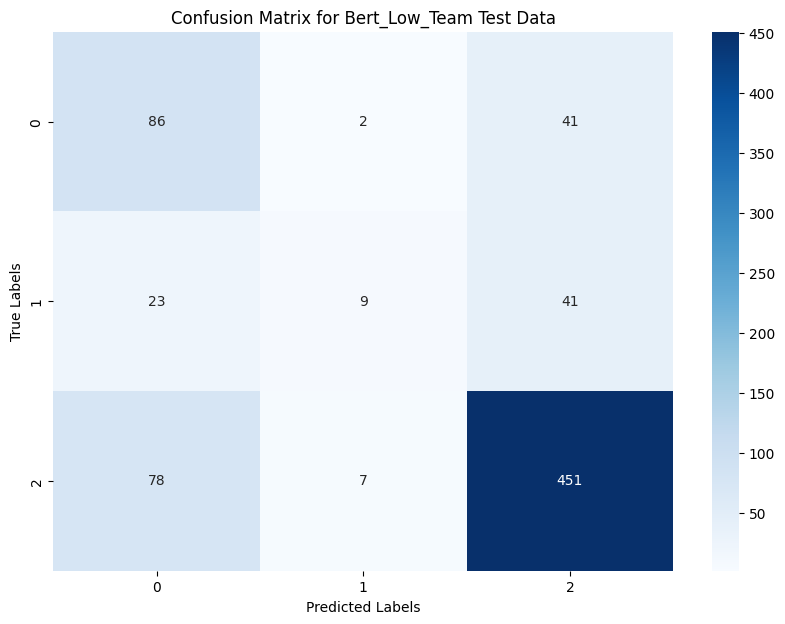

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 20ms/step - loss: 2.3640 - accuracy: 0.3675 - val_loss: 2.2405 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3238 - val_f1_score: 0.2595
70/70 [==============================] - 1s 17ms/step - loss: 2.2145 - accuracy: 0.3766 - val_loss: 2.1909 - val_accuracy: 0.3238
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3672 - val_f1_score: 0.2101
70/70 [==============================] - 1s 17ms/step - loss: 2.1730 

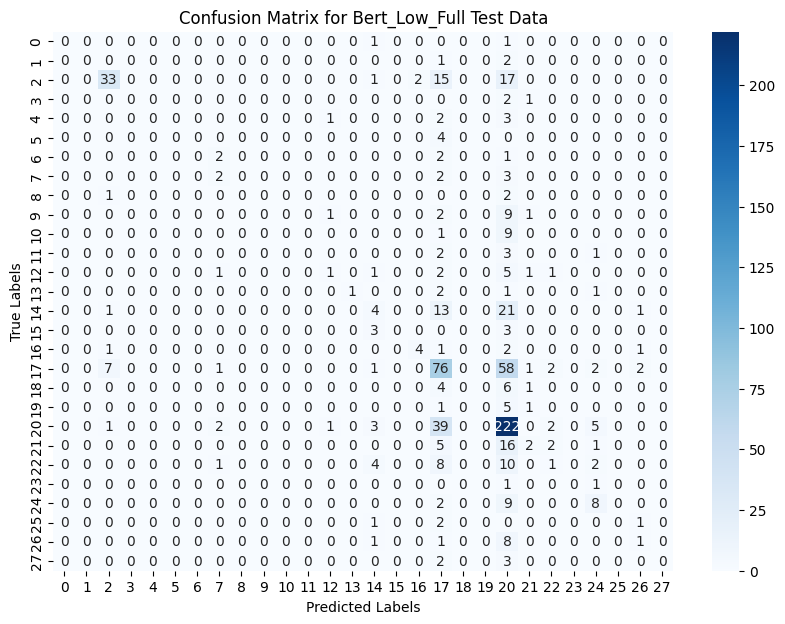

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 21ms/step - loss: 0.7791 - accuracy: 0.7233 - val_loss: 0.7557 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7381 - accuracy: 0.7274 - val_loss: 0.7234 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7138 

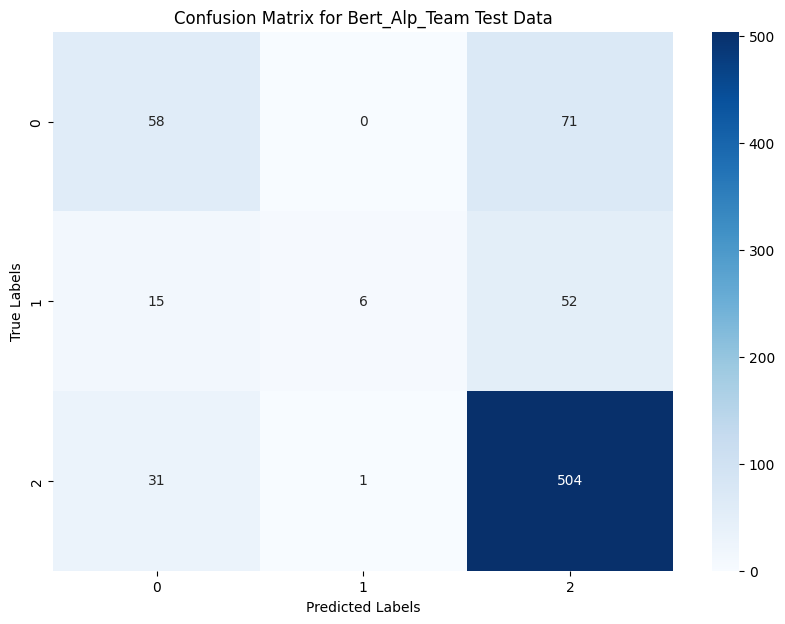

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 20ms/step - loss: 2.3543 - accuracy: 0.3612 - val_loss: 2.2401 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.3455 - val_f1_score: 0.2537
70/70 [==============================] - 1s 17ms/step - loss: 2.2265 - accuracy: 0.3698 - val_loss: 2.1846 - val_accuracy: 0.3455
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2059
70/70 [==============================] - 1s 17ms/step - loss:

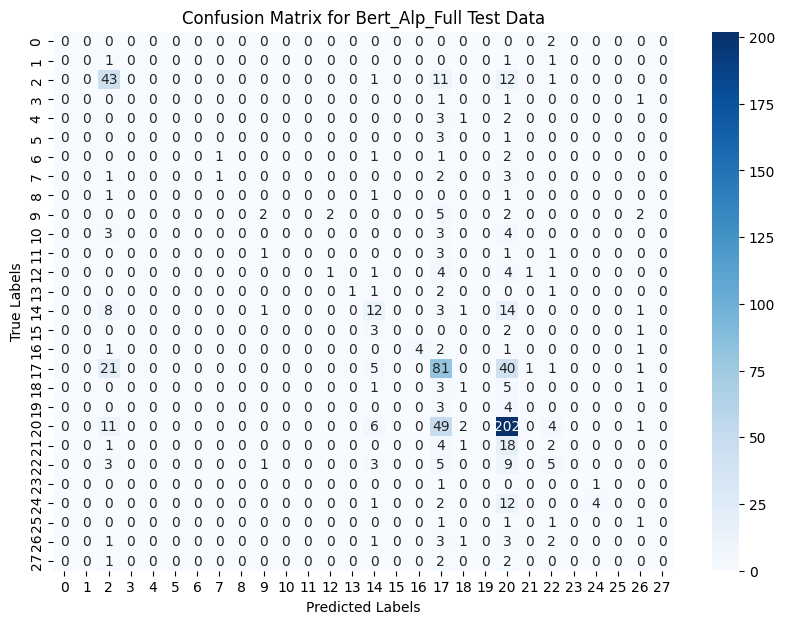

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 20ms/step - loss: 0.7870 - accuracy: 0.7202 - val_loss: 0.7565 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7434 - accuracy: 0.7274 - val_loss: 0.7288 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 17ms/step - loss: 0.7222 

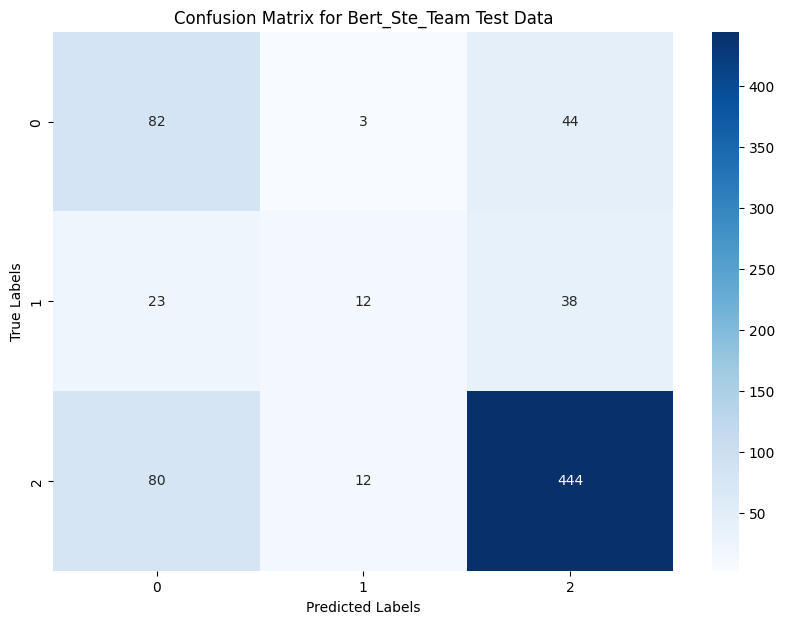

Epoch 1/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 20ms/step - loss: 2.3846 - accuracy: 0.3386 - val_loss: 2.2661 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3767 - val_f1_score: 0.2162
70/70 [==============================] - 1s 17ms/step - loss: 2.2414 - accuracy: 0.3734 - val_loss: 2.1973 - val_accuracy: 0.3767
Epoch 3/25
24/24 [==============================] - 0s 3ms/step
 - val_accuracy: 0.3767 - val_f1_score: 0.2269
70/70 [==============================] - 1s 17ms/step - loss: 2.1936 

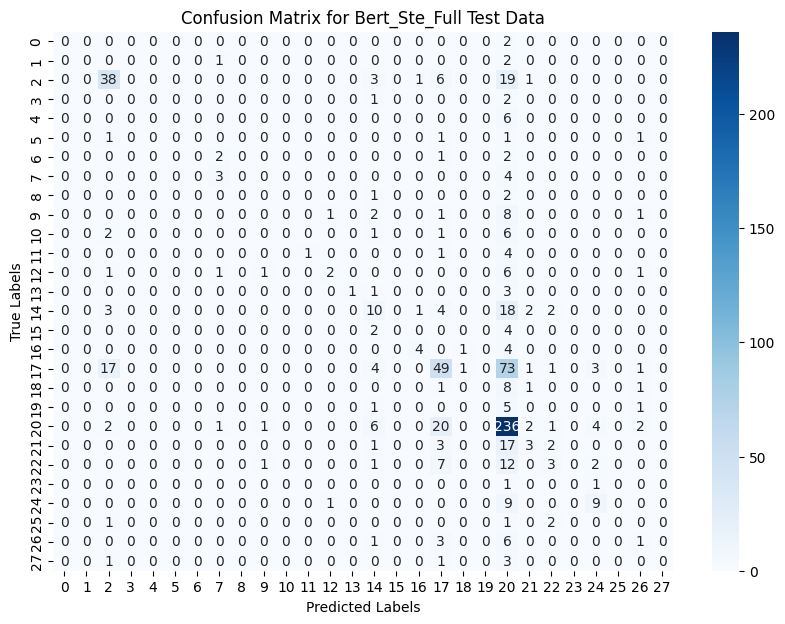

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 2s 21ms/step - loss: 0.7845 - accuracy: 0.7202 - val_loss: 0.7522 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 18ms/step - loss: 0.7418 - accuracy: 0.7274 - val_loss: 0.7293 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 18ms/step - loss: 0.7207 

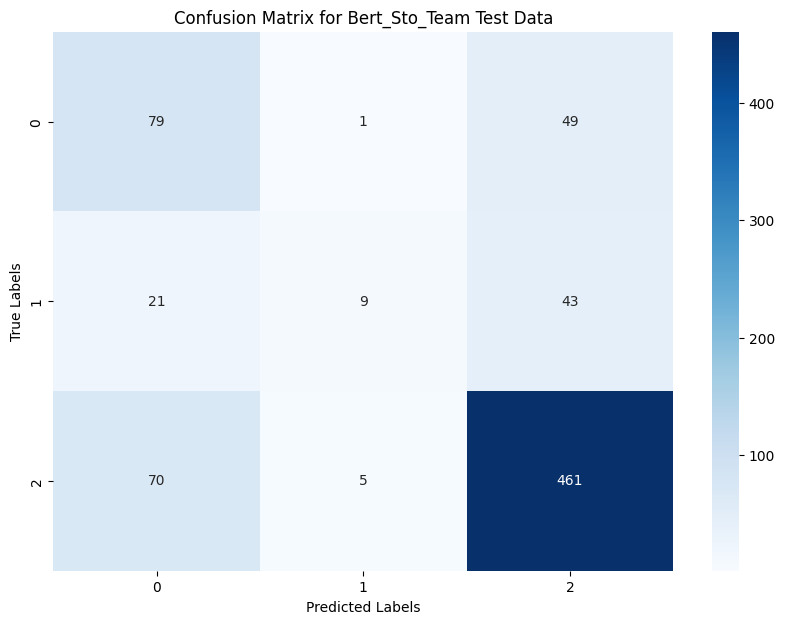

Epoch 1/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 2s 22ms/step - loss: 2.3848 - accuracy: 0.3635 - val_loss: 2.2432 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3794 - val_f1_score: 0.2213
70/70 [==============================] - 1s 19ms/step - loss: 2.2288 - accuracy: 0.3725 - val_loss: 2.1879 - val_accuracy: 0.3794
Epoch 3/25
24/24 [==============================] - 0s 4ms/step
 - val_accuracy: 0.3767 - val_f1_score: 0.2181
70/70 [==============================] - 1s 17ms/step - loss: 2.1878 

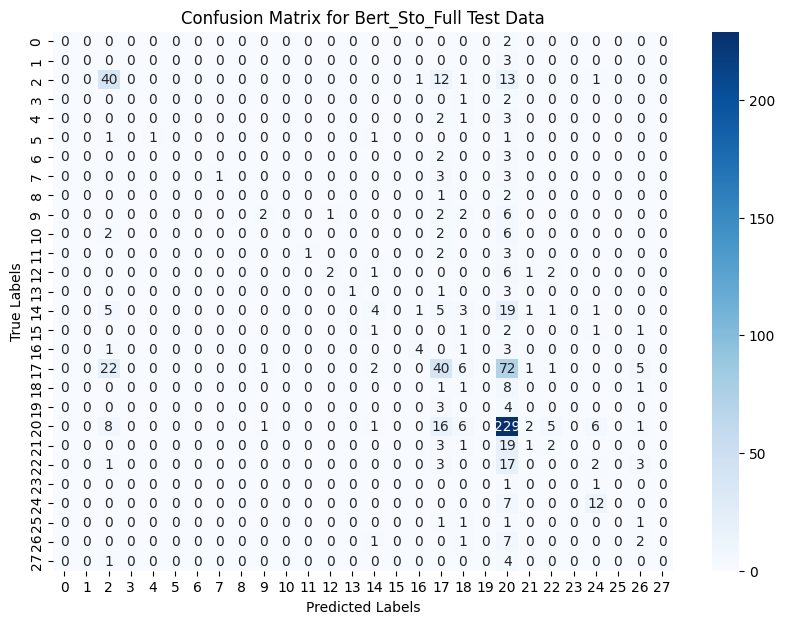

Dataset         Val Accuracy    Test Accuracy   Test F1 Score  
Bert_Raw_Team   0.7710          0.7547          0.7372         
Bert_Raw_Full   0.4932          0.4946          0.4292         
Bert_Pre_Team   0.7778          0.7588          0.7458         
Bert_Pre_Full   0.5027          0.4702          0.3996         
Bert_Low_Team   0.7710          0.7398          0.7275         
Bert_Low_Full   0.4702          0.4810          0.4215         
Bert_Alp_Team   0.7683          0.7696          0.7314         
Bert_Alp_Full   0.5149          0.4837          0.4377         
Bert_Ste_Team   0.7561          0.7290          0.7223         
Bert_Ste_Full   0.5095          0.4878          0.4289         
Bert_Sto_Team   0.7507          0.7439          0.7275         
Bert_Sto_Full   0.4621          0.4607          0.4007         


In [48]:
# Function to train and evaluate the model on a given dataset prefix
def train_and_evaluate(prefix):
    # Accessing the global variables based on the prefix
    train_data = globals()[f'{prefix}_train_data_processed']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data_processed']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data_processed']
    test_labels = globals()[f'{prefix}_test_labels']

    # Custom Callback for F1 Score
    class MetricsCallback(Callback):
        def __init__(self, model, X_val, y_val):
            self.model = model
            self.X_val = X_val
            self.y_val = y_val
            self.best_val_accuracy = 0

        def on_epoch_end(self, epoch, logs=None):
            val_accuracy = logs.get("val_accuracy")
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            predictions = self.model.predict(self.X_val)
            predictions = np.argmax(predictions, axis=1)
            f1 = calculate_f1_score(np.argmax(self.y_val, axis=1), predictions, average='weighted')
            print(f' - val_accuracy: {val_accuracy:.4f} - val_f1_score: {f1:.4f}')

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(train_labels)
    y_val_encoded = label_encoder.transform(val_labels)
    y_test_encoded = label_encoder.transform(test_labels)

    y_train_onehot = to_categorical(y_train_encoded)
    y_val_onehot = to_categorical(y_val_encoded)
    y_test_onehot = to_categorical(y_test_encoded)
    num_classes = y_train_onehot.shape[1]

    # Model architecture
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(768, 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Reshape data for Conv1D
    X_train_reshaped = train_data.reshape(-1, 768, 1)
    X_val_reshaped = val_data.reshape(-1, 768, 1)
    X_test_reshaped = test_data.reshape(-1, 768, 1)

    # Initialize F1 Score callback
    metrics_callback = MetricsCallback(model, X_val_reshaped, y_val_onehot)

    # Train the model
    model.fit(X_train_reshaped, y_train_onehot, validation_data=(X_val_reshaped, y_val_onehot), epochs=25, batch_size=32, callbacks=[metrics_callback])

    # Evaluate on test data
    test_accuracy = model.evaluate(X_test_reshaped, y_test_onehot, verbose=0)[1]

    # Calculate F1 score for test data
    test_predictions = model.predict(X_test_reshaped)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_f1_score = calculate_f1_score(np.argmax(y_test_onehot, axis=1), test_predictions, average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(np.argmax(y_test_onehot, axis=1), test_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return metrics_callback.best_val_accuracy, test_accuracy, test_f1_score

# List to store results
results = []

# Train and evaluate for each dataset
prefixes = ['Bert_Raw_Team', 'Bert_Raw_Full', 'Bert_Pre_Team', 'Bert_Pre_Full', 'Bert_Low_Team', 'Bert_Low_Full', 'Bert_Alp_Team', 'Bert_Alp_Full', 'Bert_Ste_Team', 'Bert_Ste_Full', 'Bert_Sto_Team', 'Bert_Sto_Full']

for prefix in prefixes:
    val_accuracy, test_accuracy, test_f1_score = train_and_evaluate(prefix)
    results.append({
        'Dataset': prefix,
        'Val Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1_score
    })

# Display the results in a table format
print("{:<15} {:<15} {:<15} {:<15}".format('Dataset', 'Val Accuracy', 'Test Accuracy', 'Test F1 Score'))
for result in results:
    print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(result['Dataset'], result['Val Accuracy'], result['Test Accuracy'], result['Test F1 Score']))

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 7ms/step - loss: 0.7983 - accuracy: 0.7220 - val_loss: 0.7423 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 0s 4ms/step - loss: 0.7269 - accuracy: 0.7269 - val_loss: 0.7313 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7290 - val_f1_score: 0.6185
70/70 [==============================] - 0s 4ms/step - loss: 0.7201 - a

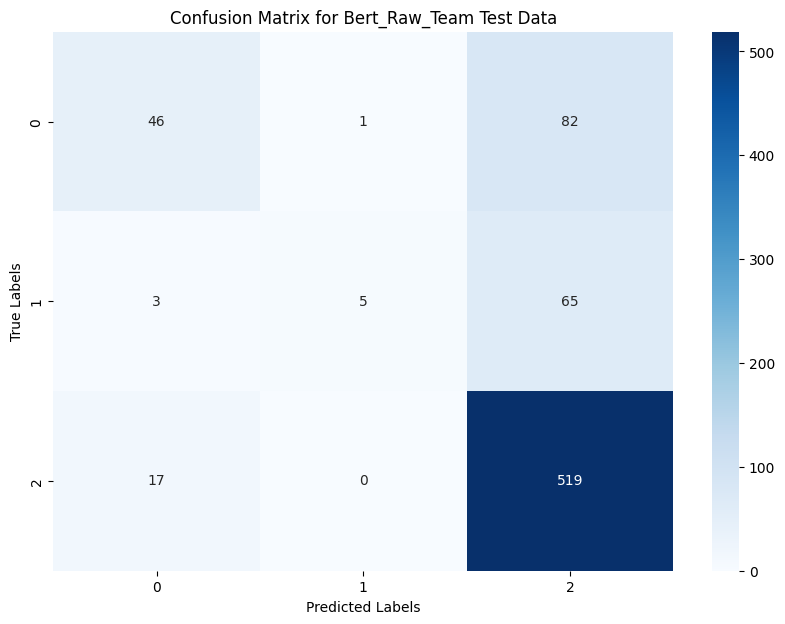

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3740 - val_f1_score: 0.2309
70/70 [==============================] - 1s 6ms/step - loss: 2.3007 - accuracy: 0.3698 - val_loss: 2.1718 - val_accuracy: 0.3740
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3713 - val_f1_score: 0.3083
70/70 [==============================] - 0s 4ms/step - loss: 2.1852 - accuracy: 0.3757 - val_loss: 2.1344 - val_accuracy: 0.3713
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.4011 - val_f1_score: 0.3100
70/70 [==============================] - 0s 4ms/step - loss: 2.1074 - a

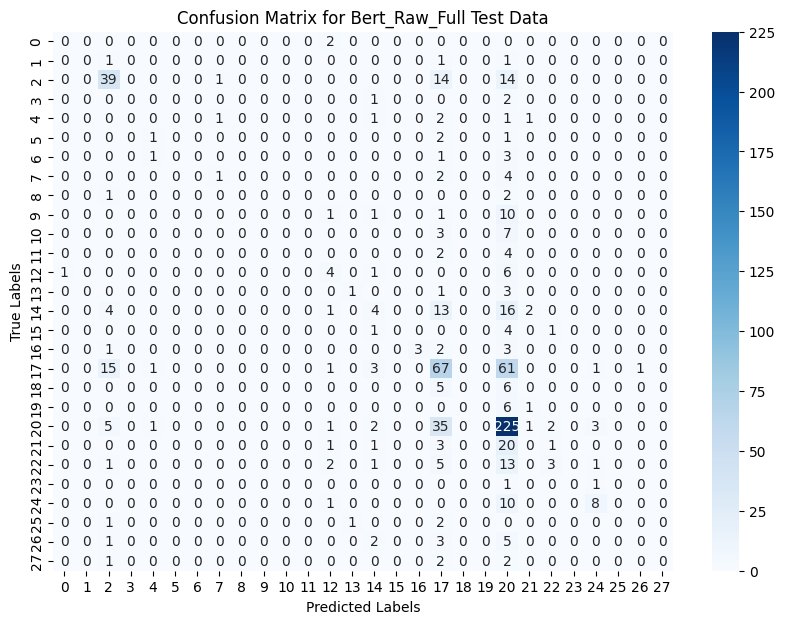

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 7ms/step - loss: 0.7897 - accuracy: 0.7242 - val_loss: 0.7405 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.7265 - val_loss: 0.7420 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6159
70/70 [==============================] - 0s 4ms/step - loss: 0.7023 - a

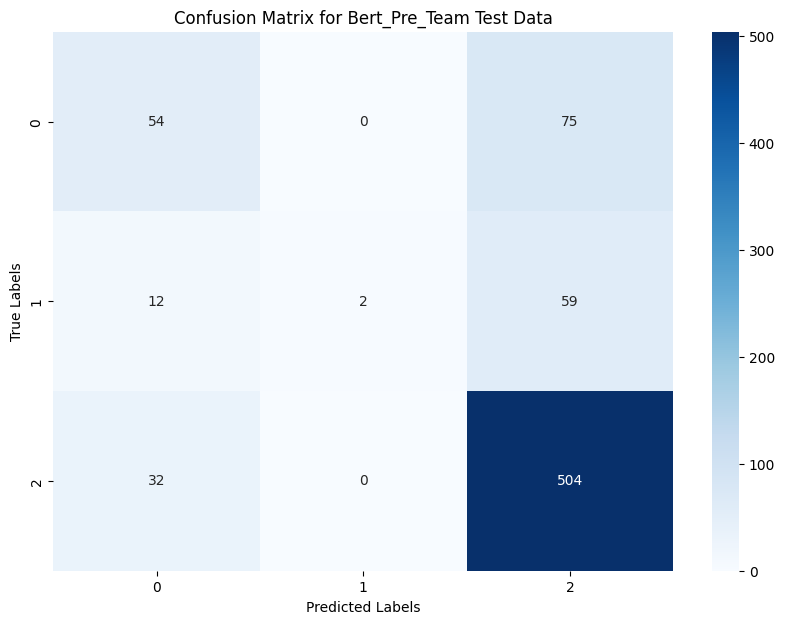

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 6ms/step - loss: 2.3283 - accuracy: 0.3571 - val_loss: 2.2094 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3753 - val_f1_score: 0.2803
70/70 [==============================] - 0s 4ms/step - loss: 2.1846 - accuracy: 0.3648 - val_loss: 2.1435 - val_accuracy: 0.3753
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 0s 4ms/step - loss: 2.

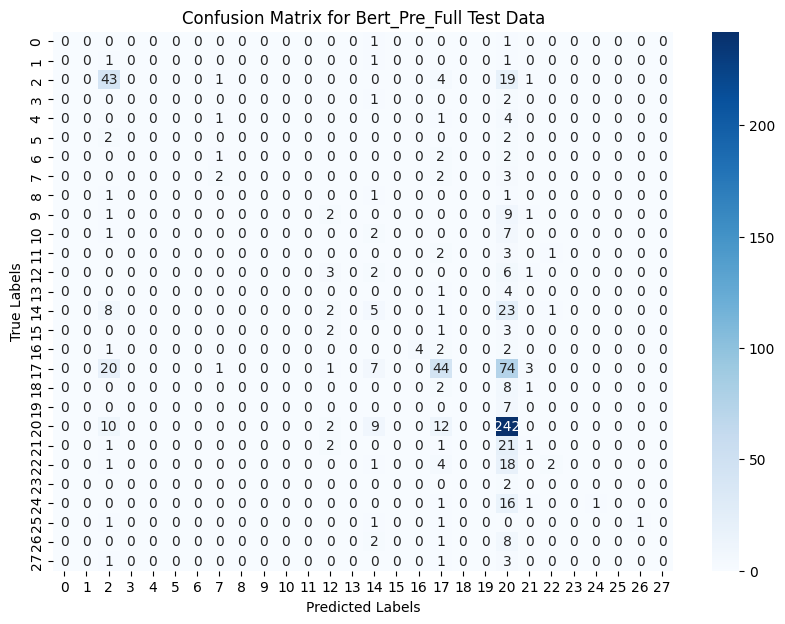

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 6ms/step - loss: 0.7731 - accuracy: 0.7220 - val_loss: 0.7303 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7290 - val_f1_score: 0.6161
70/70 [==============================] - 0s 4ms/step - loss: 0.7217 - accuracy: 0.7306 - val_loss: 0.7410 - val_accuracy: 0.7290
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7358 - val_f1_score: 0.6399
70/70 [==============================] - 0s 4ms/step - loss: 0.7005 - a

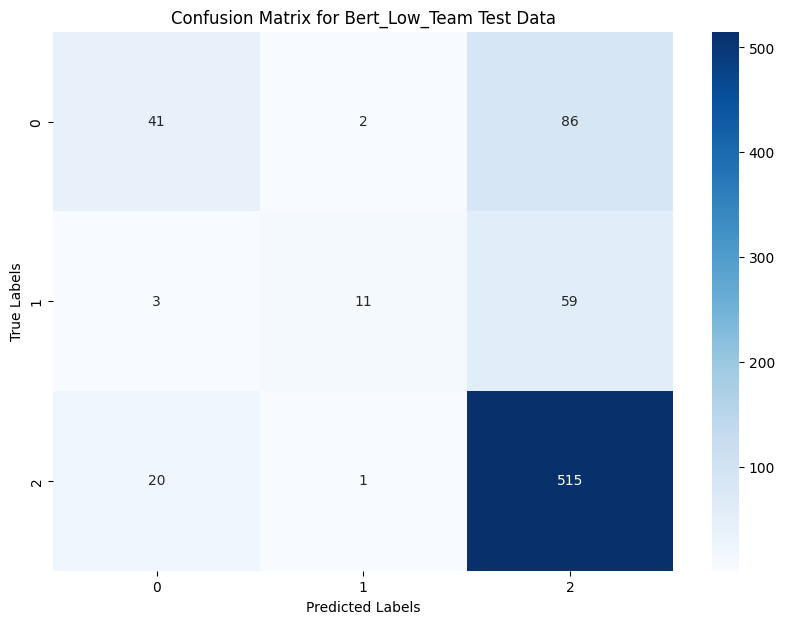

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 6ms/step - loss: 2.3869 - accuracy: 0.3571 - val_loss: 2.1995 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3388 - val_f1_score: 0.2697
70/70 [==============================] - 0s 4ms/step - loss: 2.1826 - accuracy: 0.3662 - val_loss: 2.1444 - val_accuracy: 0.3388
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3780 - val_f1_score: 0.2615
70/70 [==============================] - 0s 4ms/step - loss: 2.1441 - a

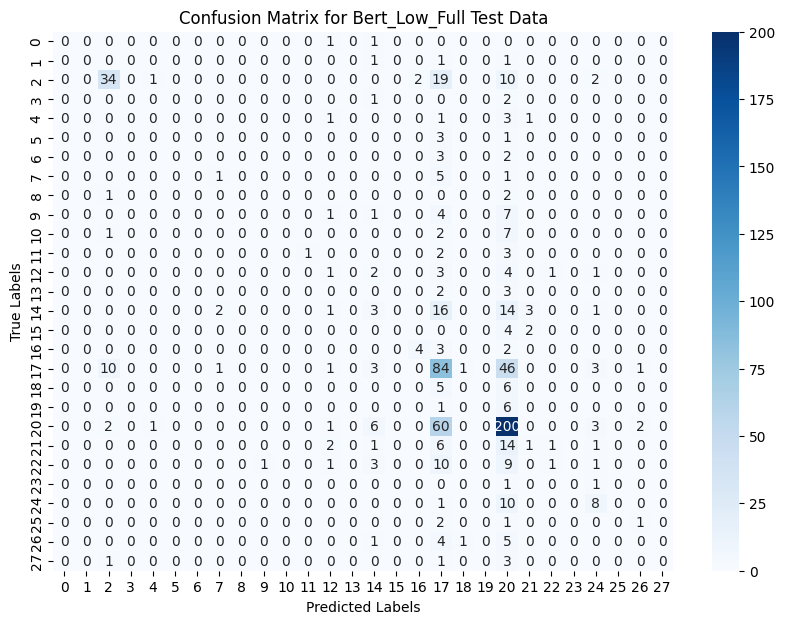

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 6ms/step - loss: 0.7724 - accuracy: 0.7215 - val_loss: 0.7478 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7304 - val_f1_score: 0.6192
70/70 [==============================] - 0s 4ms/step - loss: 0.7263 - accuracy: 0.7297 - val_loss: 0.7342 - val_accuracy: 0.7304
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7263 - val_f1_score: 0.6221
70/70 [==============================] - 0s 4ms/step - loss: 0.7046 - a

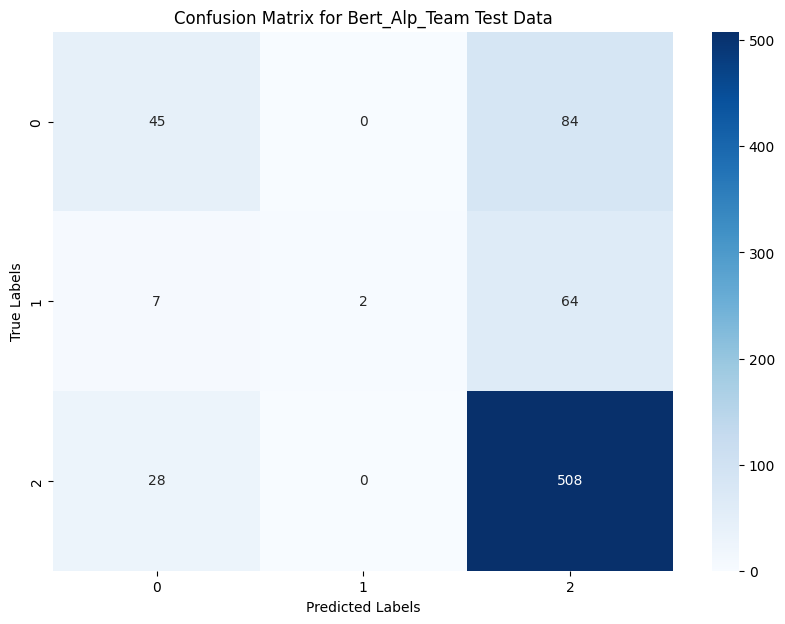

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 6ms/step - loss: 2.3422 - accuracy: 0.3558 - val_loss: 2.2274 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3401 - val_f1_score: 0.2591
70/70 [==============================] - 0s 4ms/step - loss: 2.1962 - accuracy: 0.3721 - val_loss: 2.1475 - val_accuracy: 0.3401
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3930 - val_f1_score: 0.2440
70/70 [==============================] - 0s 4ms/step - loss: 2.

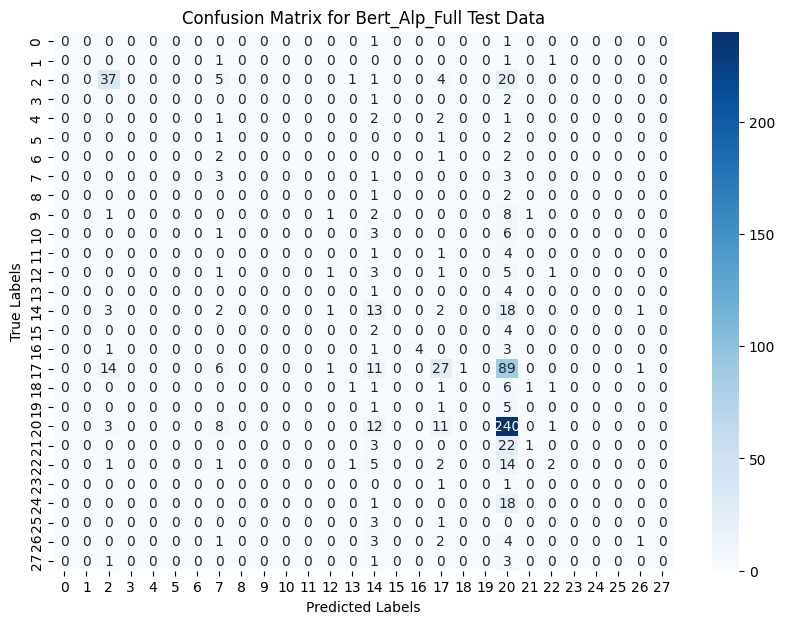

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 6ms/step - loss: 0.7760 - accuracy: 0.7274 - val_loss: 0.7390 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 993us/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 0s 4ms/step - loss: 0.7355 - accuracy: 0.7274 - val_loss: 0.7186 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 992us/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 0s 4ms/step - loss: 0.7253 - a

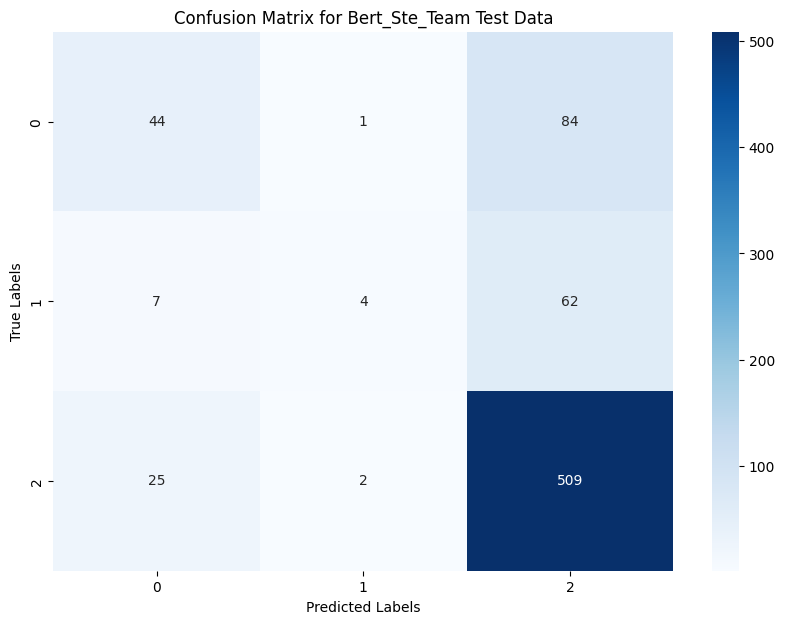

Epoch 1/25
24/24 [==============================] - 0s 981us/step
 - val_accuracy: 0.3699 - val_f1_score: 0.2016
70/70 [==============================] - 1s 6ms/step - loss: 2.3274 - accuracy: 0.3562 - val_loss: 2.2049 - val_accuracy: 0.3699
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3238 - val_f1_score: 0.2606
70/70 [==============================] - 0s 4ms/step - loss: 2.1928 - accuracy: 0.3761 - val_loss: 2.1791 - val_accuracy: 0.3238
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2046
70/70 [==============================] - 0s 4ms/step - loss: 2.

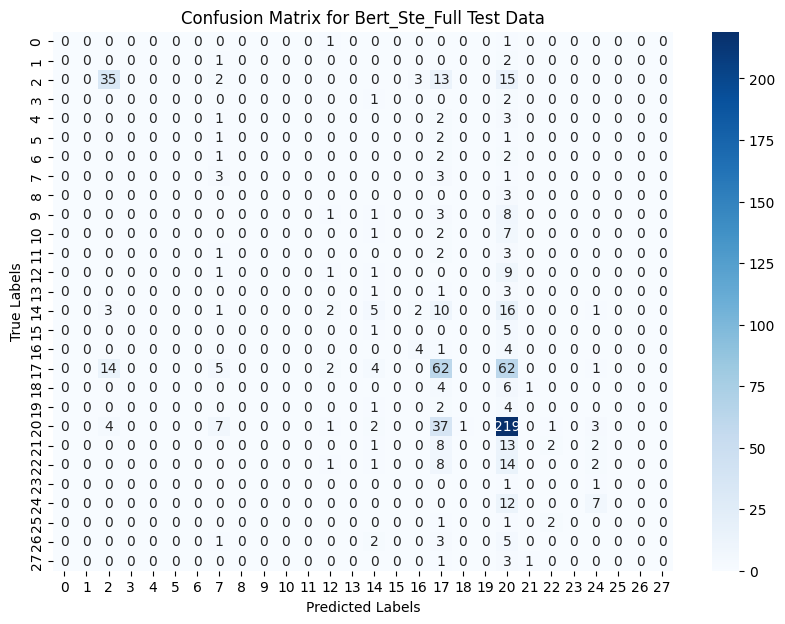

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 1s 6ms/step - loss: 0.7787 - accuracy: 0.7220 - val_loss: 0.7379 - val_accuracy: 0.7276
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6129
70/70 [==============================] - 0s 4ms/step - loss: 0.7430 - accuracy: 0.7274 - val_loss: 0.7454 - val_accuracy: 0.7276
Epoch 3/25
24/24 [==============================] - 0s 984us/step
 - val_accuracy: 0.7276 - val_f1_score: 0.6154
70/70 [==============================] - 0s 4ms/step - loss: 0.7333 - a

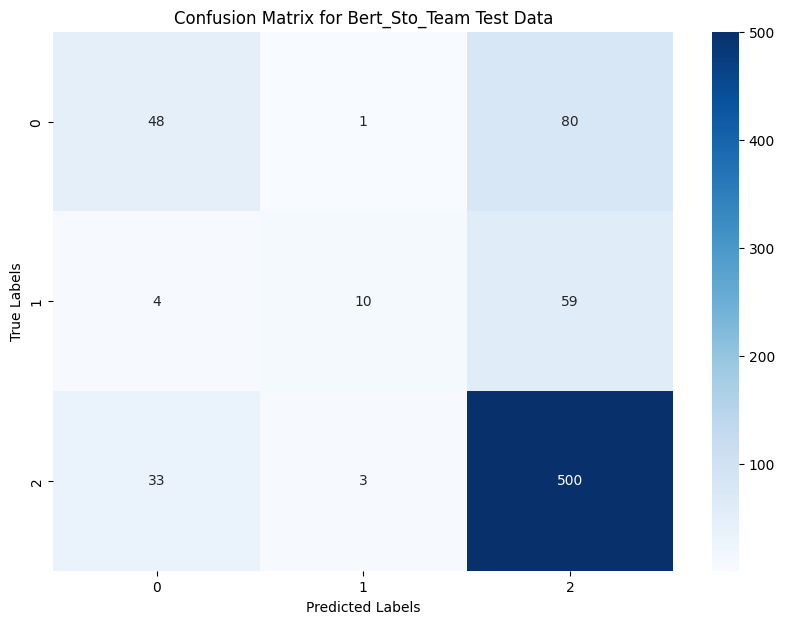

Epoch 1/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3726 - val_f1_score: 0.2023
70/70 [==============================] - 1s 7ms/step - loss: 2.4085 - accuracy: 0.3585 - val_loss: 2.2316 - val_accuracy: 0.3726
Epoch 2/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3537 - val_f1_score: 0.2684
70/70 [==============================] - 0s 4ms/step - loss: 2.2082 - accuracy: 0.3698 - val_loss: 2.1697 - val_accuracy: 0.3537
Epoch 3/25
24/24 [==============================] - 0s 1ms/step
 - val_accuracy: 0.3753 - val_f1_score: 0.2156
70/70 [==============================] - 0s 4ms/step - loss: 2.

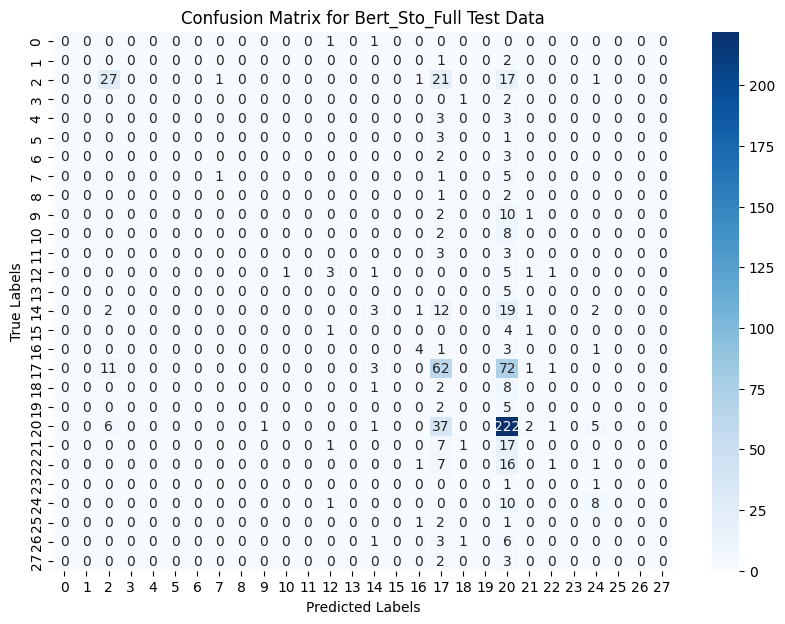

Dataset         Val Accuracy    Test Accuracy   Test F1 Score  
Bert_Raw_Team   0.7710          0.7724          0.7222         
Bert_Raw_Full   0.4729          0.4810          0.4174         
Bert_Pre_Team   0.7615          0.7588          0.7120         
Bert_Pre_Full   0.4932          0.4702          0.3926         
Bert_Low_Team   0.7656          0.7683          0.7248         
Bert_Low_Full   0.4770          0.4580          0.4058         
Bert_Alp_Team   0.7656          0.7520          0.6996         
Bert_Alp_Full   0.5108          0.4458          0.3723         
Bert_Ste_Team   0.7615          0.7547          0.7057         
Bert_Ste_Full   0.4743          0.4553          0.3922         
Bert_Sto_Team   0.7547          0.7561          0.7193         
Bert_Sto_Full   0.4512          0.4485          0.3808         


In [49]:
# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Function to train and evaluate the model on a given dataset prefix
def train_and_evaluate(prefix):
    # Accessing the global variables based on the prefix
    train_data = globals()[f'{prefix}_train_data_processed']
    train_labels = globals()[f'{prefix}_train_labels']
    val_data = globals()[f'{prefix}_val_data_processed']
    val_labels = globals()[f'{prefix}_val_labels']
    test_data = globals()[f'{prefix}_test_data_processed']
    test_labels = globals()[f'{prefix}_test_labels']

    # Custom Callback for F1 Score and Validation Accuracy
    class MetricsCallback(Callback):
        def __init__(self, model, X_val, y_val):
            self.model = model
            self.X_val = X_val
            self.y_val = y_val
            self.best_val_accuracy = 0

        def on_epoch_end(self, epoch, logs={}):
            val_accuracy = logs.get("val_accuracy")
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            predictions = self.model.predict(self.X_val)
            predictions = np.argmax(predictions, axis=1)
            f1 = calculate_f1_score(np.argmax(self.y_val, axis=1), predictions, average='weighted')
            print(f' - val_accuracy: {val_accuracy:.4f} - val_f1_score: {f1:.4f}')

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(train_labels)
    y_val_encoded = label_encoder.transform(val_labels)
    y_test_encoded = label_encoder.transform(test_labels)

    y_train_onehot = to_categorical(y_train_encoded)
    y_val_onehot = to_categorical(y_val_encoded)
    y_test_onehot = to_categorical(y_test_encoded)
    num_classes = y_train_onehot.shape[1]

    # Model architecture
    model = Sequential()
    model.add(Flatten(input_shape=(768,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Initialize F1 Score callback
    metrics_callback = MetricsCallback(model, val_data, y_val_onehot)

    # Train the model
    model.fit(train_data, y_train_onehot, validation_data=(val_data, y_val_onehot), epochs=25, batch_size=32, callbacks=[metrics_callback])

    # Evaluate on test data
    test_accuracy = model.evaluate(test_data, y_test_onehot, verbose=0)[1]

    # Calculate F1 score for test data
    test_predictions = model.predict(test_data)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_f1_score = calculate_f1_score(np.argmax(y_test_onehot, axis=1), test_predictions, average='weighted')

    # Compute and visualize the confusion matrix for the test data
    test_confusion_matrix = confusion_matrix(np.argmax(y_test_onehot, axis=1), test_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {prefix} Test Data")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return metrics_callback.best_val_accuracy, test_accuracy, test_f1_score

# List to store results
results = []

# Train and evaluate for each dataset
prefixes = ['Bert_Raw_Team', 'Bert_Raw_Full', 'Bert_Pre_Team', 'Bert_Pre_Full', 'Bert_Low_Team', 'Bert_Low_Full', 'Bert_Alp_Team', 'Bert_Alp_Full', 'Bert_Ste_Team', 'Bert_Ste_Full', 'Bert_Sto_Team', 'Bert_Sto_Full']

for prefix in prefixes:
    val_accuracy, test_accuracy, test_f1_score = train_and_evaluate(prefix)
    results.append({
        'Dataset': prefix,
        'Val Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1_score
    })

# Display the results in a table format
print("{:<15} {:<15} {:<15} {:<15}".format('Dataset', 'Val Accuracy', 'Test Accuracy', 'Test F1 Score'))
for result in results:
    print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(result['Dataset'], result['Val Accuracy'], result['Test Accuracy'], result['Test F1 Score']))
